In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


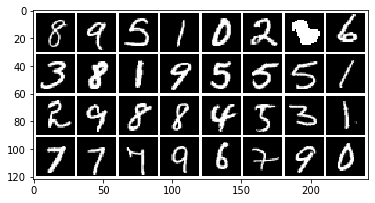

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = calc_mags(data)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [7]:
# Define Gen and Disc loss
def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [110]:
### Create new models ###

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

Version 0.4


In [111]:
# Set training parameters

lmd = 1e2 # loss signal

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [112]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_magnitudes], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 48.10154724121094
Discriminator initial loss: 0.698203444480896


In [113]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            magnitudes = calc_mags(x)
            
            # stack magnitudes to noise / generator input
            z = torch.randn(*x.shape).to(device)
            zm = torch.cat([z, magnitudes], dim=1)
            
            # calc gen output
            gen.train()
            gen_output = gen(zm)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen(zm), x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_outputs, test_images = test_generator(gen, device, dataloader['val'])
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        torch.save(gen_weights, "../cache/FCGenerator2048MNIST_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        torch.save(disc_weights, "../cache/ConvDiscriminator64MNIST_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return mse_val

epoch:  1 	 step:0 	 loss: 48.08
epoch:  1 	 step:100 	 loss: 15.0
epoch:  1 	 step:200 	 loss: 11.23
epoch:  1 	 step:300 	 loss: 10.03
epoch:  1 	 step:400 	 loss: 9.573
epoch:  1 	 step:500 	 loss: 10.77
epoch:  1 	 step:600 	 loss: 9.567
epoch:  1 	 step:700 	 loss: 11.85
epoch:  1 	 step:800 	 loss: 9.553
epoch:  1 	 step:900 	 loss: 10.09
epoch:  1 	 step:1000 	 loss: 8.82
epoch:  1 	 step:1100 	 loss: 9.513
epoch:  1 	 step:1200 	 loss: 9.45
epoch:  1 	 step:1300 	 loss: 9.345
epoch:  1 	 step:1400 	 loss: 10.24
epoch:  1 	 step:1500 	 loss: 10.62
epoch:  1 	 step:1600 	 loss: 8.979
epoch:  1 	 step:1700 	 loss: 8.608
epoch:  1 	 step:1800 	 loss: 8.851


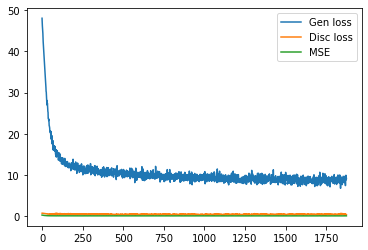

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


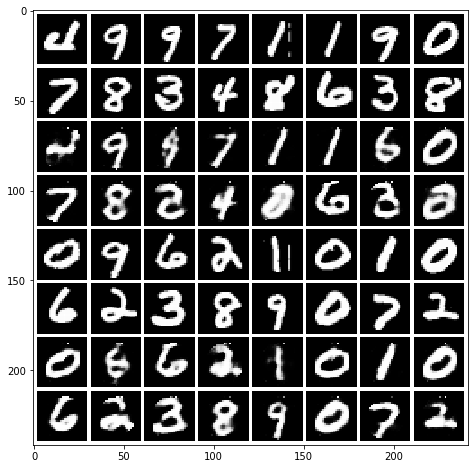

Mean squared dist: 0.040469207
epoch:  2 	 step:0 	 loss: 8.064
epoch:  2 	 step:100 	 loss: 7.732
epoch:  2 	 step:200 	 loss: 7.759
epoch:  2 	 step:300 	 loss: 8.557
epoch:  2 	 step:400 	 loss: 7.719
epoch:  2 	 step:500 	 loss: 8.665
epoch:  2 	 step:600 	 loss: 8.15
epoch:  2 	 step:700 	 loss: 8.189
epoch:  2 	 step:800 	 loss: 7.522
epoch:  2 	 step:900 	 loss: 8.849
epoch:  2 	 step:1000 	 loss: 7.892
epoch:  2 	 step:1100 	 loss: 9.93
epoch:  2 	 step:1200 	 loss: 8.199
epoch:  2 	 step:1300 	 loss: 8.346
epoch:  2 	 step:1400 	 loss: 7.369
epoch:  2 	 step:1500 	 loss: 8.901
epoch:  2 	 step:1600 	 loss: 8.158
epoch:  2 	 step:1700 	 loss: 7.67
epoch:  2 	 step:1800 	 loss: 7.969


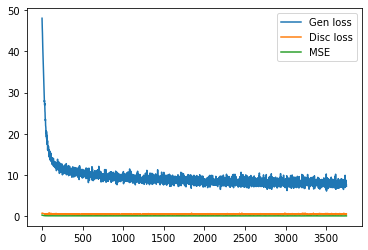

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


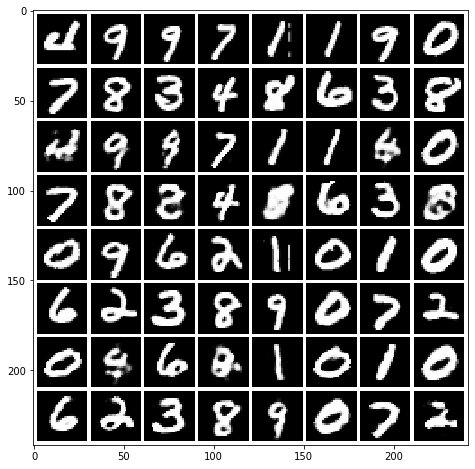

Mean squared dist: 0.03483254
epoch:  3 	 step:0 	 loss: 7.912
epoch:  3 	 step:100 	 loss: 6.851
epoch:  3 	 step:200 	 loss: 7.208
epoch:  3 	 step:300 	 loss: 7.267
epoch:  3 	 step:400 	 loss: 7.282
epoch:  3 	 step:500 	 loss: 8.687
epoch:  3 	 step:600 	 loss: 7.38
epoch:  3 	 step:700 	 loss: 7.864
epoch:  3 	 step:800 	 loss: 7.978
epoch:  3 	 step:900 	 loss: 7.799
epoch:  3 	 step:1000 	 loss: 7.485
epoch:  3 	 step:1100 	 loss: 7.733
epoch:  3 	 step:1200 	 loss: 7.95
epoch:  3 	 step:1300 	 loss: 8.026
epoch:  3 	 step:1400 	 loss: 7.053
epoch:  3 	 step:1500 	 loss: 8.863
epoch:  3 	 step:1600 	 loss: 8.301
epoch:  3 	 step:1700 	 loss: 7.113
epoch:  3 	 step:1800 	 loss: 6.618


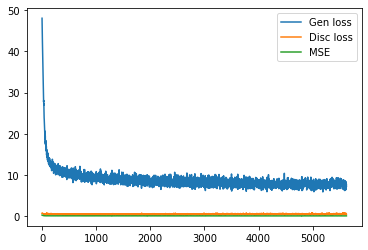

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


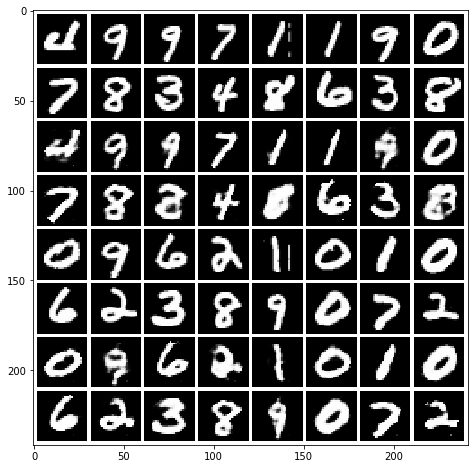

Mean squared dist: 0.032636553
epoch:  4 	 step:0 	 loss: 7.033
epoch:  4 	 step:100 	 loss: 7.014
epoch:  4 	 step:200 	 loss: 7.718
epoch:  4 	 step:300 	 loss: 7.326
epoch:  4 	 step:400 	 loss: 7.005
epoch:  4 	 step:500 	 loss: 8.03
epoch:  4 	 step:600 	 loss: 6.873
epoch:  4 	 step:700 	 loss: 7.799
epoch:  4 	 step:800 	 loss: 6.624
epoch:  4 	 step:900 	 loss: 7.754
epoch:  4 	 step:1000 	 loss: 8.397
epoch:  4 	 step:1100 	 loss: 6.963
epoch:  4 	 step:1200 	 loss: 6.201
epoch:  4 	 step:1300 	 loss: 7.844
epoch:  4 	 step:1400 	 loss: 6.957
epoch:  4 	 step:1500 	 loss: 8.335
epoch:  4 	 step:1600 	 loss: 8.146
epoch:  4 	 step:1700 	 loss: 7.002
epoch:  4 	 step:1800 	 loss: 7.638


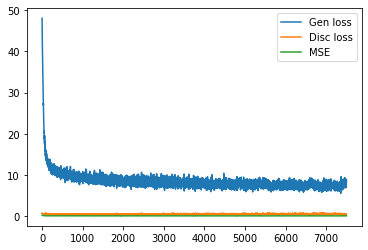

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


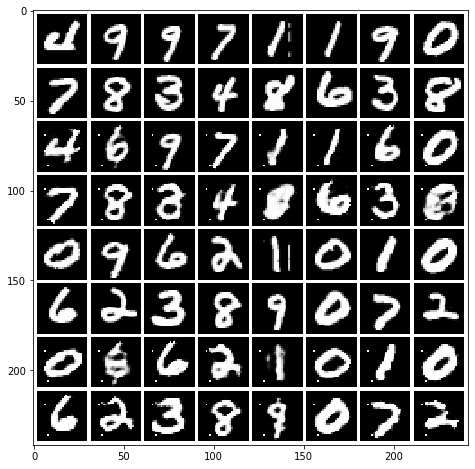

Mean squared dist: 0.03434525
epoch:  5 	 step:0 	 loss: 7.85
epoch:  5 	 step:100 	 loss: 7.163
epoch:  5 	 step:200 	 loss: 6.469
epoch:  5 	 step:300 	 loss: 6.981
epoch:  5 	 step:400 	 loss: 7.675
epoch:  5 	 step:500 	 loss: 9.502
epoch:  5 	 step:600 	 loss: 6.976
epoch:  5 	 step:700 	 loss: 6.111
epoch:  5 	 step:800 	 loss: 6.512
epoch:  5 	 step:900 	 loss: 7.191
epoch:  5 	 step:1000 	 loss: 6.611
epoch:  5 	 step:1100 	 loss: 7.708
epoch:  5 	 step:1200 	 loss: 6.809
epoch:  5 	 step:1300 	 loss: 6.564
epoch:  5 	 step:1400 	 loss: 7.157
epoch:  5 	 step:1500 	 loss: 6.505
epoch:  5 	 step:1600 	 loss: 7.18
epoch:  5 	 step:1700 	 loss: 7.246
epoch:  5 	 step:1800 	 loss: 6.763


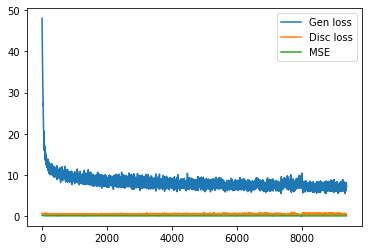

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


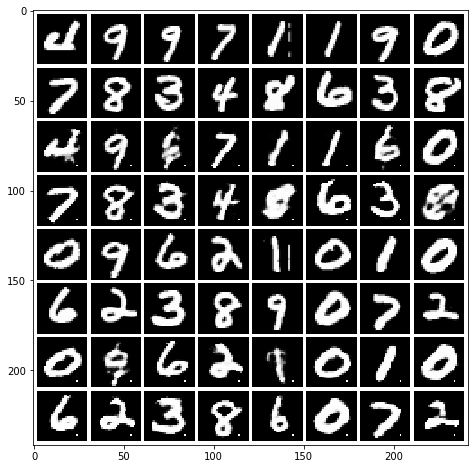

Mean squared dist: 0.032782722
epoch:  6 	 step:0 	 loss: 7.226
epoch:  6 	 step:100 	 loss: 7.397
epoch:  6 	 step:200 	 loss: 7.358
epoch:  6 	 step:300 	 loss: 6.723
epoch:  6 	 step:400 	 loss: 6.584
epoch:  6 	 step:500 	 loss: 7.251
epoch:  6 	 step:600 	 loss: 7.37
epoch:  6 	 step:700 	 loss: 6.604
epoch:  6 	 step:800 	 loss: 6.998
epoch:  6 	 step:900 	 loss: 6.852
epoch:  6 	 step:1000 	 loss: 6.484
epoch:  6 	 step:1100 	 loss: 6.29
epoch:  6 	 step:1200 	 loss: 7.288
epoch:  6 	 step:1300 	 loss: 8.613
epoch:  6 	 step:1400 	 loss: 6.275
epoch:  6 	 step:1500 	 loss: 8.437
epoch:  6 	 step:1600 	 loss: 6.796
epoch:  6 	 step:1700 	 loss: 6.108
epoch:  6 	 step:1800 	 loss: 7.133


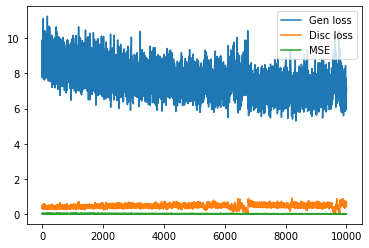

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


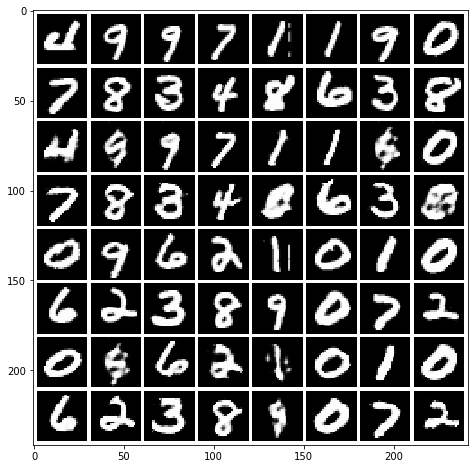

Mean squared dist: 0.029745167
epoch:  7 	 step:0 	 loss: 6.395
epoch:  7 	 step:100 	 loss: 7.094
epoch:  7 	 step:200 	 loss: 6.044
epoch:  7 	 step:300 	 loss: 6.895
epoch:  7 	 step:400 	 loss: 7.038
epoch:  7 	 step:500 	 loss: 6.974
epoch:  7 	 step:600 	 loss: 6.623
epoch:  7 	 step:700 	 loss: 6.815
epoch:  7 	 step:800 	 loss: 6.268
epoch:  7 	 step:900 	 loss: 6.625
epoch:  7 	 step:1000 	 loss: 6.366
epoch:  7 	 step:1100 	 loss: 7.299
epoch:  7 	 step:1200 	 loss: 6.904
epoch:  7 	 step:1300 	 loss: 5.427
epoch:  7 	 step:1400 	 loss: 6.503
epoch:  7 	 step:1500 	 loss: 6.261
epoch:  7 	 step:1600 	 loss: 6.828
epoch:  7 	 step:1700 	 loss: 6.692
epoch:  7 	 step:1800 	 loss: 7.156


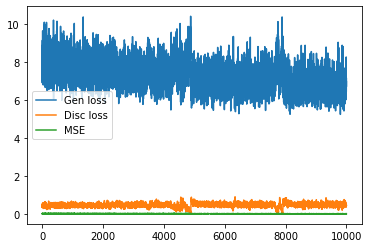

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


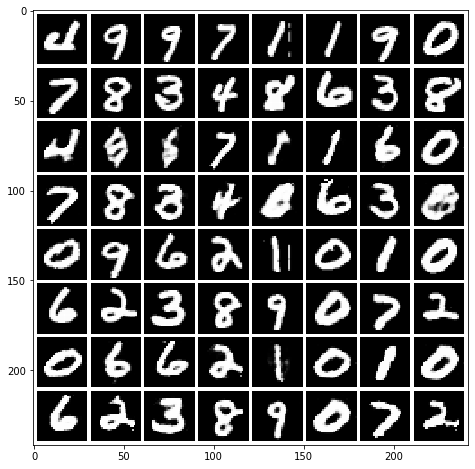

Mean squared dist: 0.029437514
epoch:  8 	 step:0 	 loss: 7.178
epoch:  8 	 step:100 	 loss: 6.162
epoch:  8 	 step:200 	 loss: 6.362
epoch:  8 	 step:300 	 loss: 7.154
epoch:  8 	 step:400 	 loss: 5.673
epoch:  8 	 step:500 	 loss: 6.438
epoch:  8 	 step:600 	 loss: 6.226
epoch:  8 	 step:700 	 loss: 6.102
epoch:  8 	 step:800 	 loss: 6.528
epoch:  8 	 step:900 	 loss: 6.57
epoch:  8 	 step:1000 	 loss: 7.301
epoch:  8 	 step:1100 	 loss: 7.172
epoch:  8 	 step:1200 	 loss: 6.117
epoch:  8 	 step:1300 	 loss: 7.093
epoch:  8 	 step:1400 	 loss: 6.427
epoch:  8 	 step:1500 	 loss: 6.605
epoch:  8 	 step:1600 	 loss: 6.499
epoch:  8 	 step:1700 	 loss: 6.712
epoch:  8 	 step:1800 	 loss: 7.232


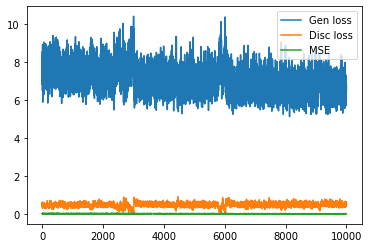

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


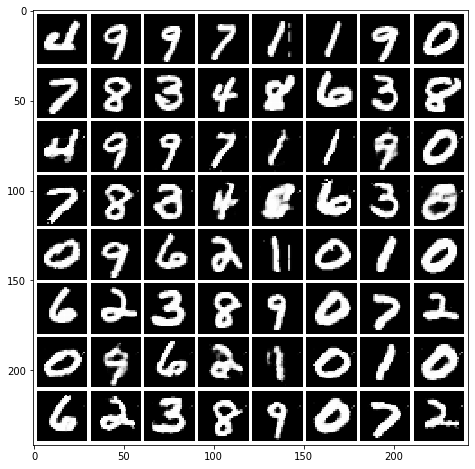

Mean squared dist: 0.029224517
epoch:  9 	 step:0 	 loss: 6.137
epoch:  9 	 step:100 	 loss: 6.485
epoch:  9 	 step:200 	 loss: 6.511
epoch:  9 	 step:300 	 loss: 6.095
epoch:  9 	 step:400 	 loss: 6.837
epoch:  9 	 step:500 	 loss: 6.712
epoch:  9 	 step:600 	 loss: 5.995
epoch:  9 	 step:700 	 loss: 6.497
epoch:  9 	 step:800 	 loss: 6.179
epoch:  9 	 step:900 	 loss: 7.316
epoch:  9 	 step:1000 	 loss: 7.055
epoch:  9 	 step:1100 	 loss: 6.13
epoch:  9 	 step:1200 	 loss: 6.679
epoch:  9 	 step:1300 	 loss: 6.938
epoch:  9 	 step:1400 	 loss: 6.898
epoch:  9 	 step:1500 	 loss: 6.786
epoch:  9 	 step:1600 	 loss: 6.685
epoch:  9 	 step:1700 	 loss: 7.049
epoch:  9 	 step:1800 	 loss: 6.751


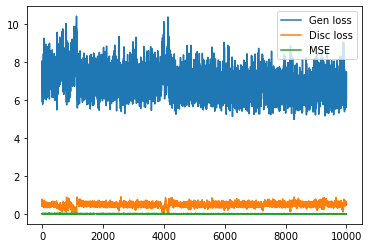

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


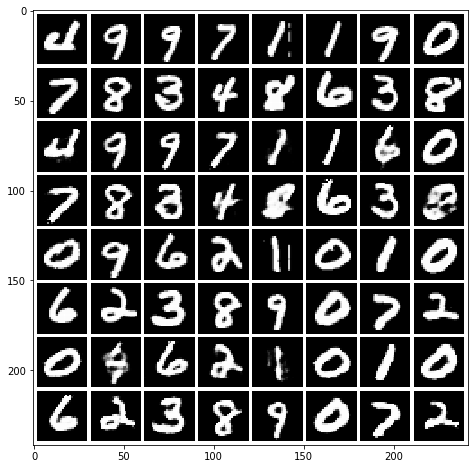

Mean squared dist: 0.028570058
epoch: 10 	 step:0 	 loss: 6.793
epoch: 10 	 step:100 	 loss: 6.192
epoch: 10 	 step:200 	 loss: 6.503
epoch: 10 	 step:300 	 loss: 6.11
epoch: 10 	 step:400 	 loss: 6.515
epoch: 10 	 step:500 	 loss: 5.656
epoch: 10 	 step:600 	 loss: 7.125
epoch: 10 	 step:700 	 loss: 6.194
epoch: 10 	 step:800 	 loss: 6.197
epoch: 10 	 step:900 	 loss: 6.119
epoch: 10 	 step:1000 	 loss: 7.298
epoch: 10 	 step:1100 	 loss: 6.366
epoch: 10 	 step:1200 	 loss: 7.605
epoch: 10 	 step:1300 	 loss: 6.327
epoch: 10 	 step:1400 	 loss: 5.589
epoch: 10 	 step:1500 	 loss: 6.46
epoch: 10 	 step:1600 	 loss: 6.188
epoch: 10 	 step:1700 	 loss: 6.887
epoch: 10 	 step:1800 	 loss: 6.623


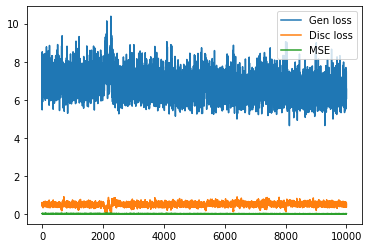

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


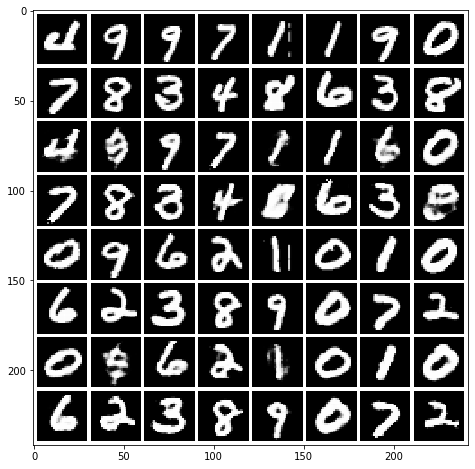

Mean squared dist: 0.028393412
epoch: 11 	 step:0 	 loss: 5.444
epoch: 11 	 step:100 	 loss: 6.441
epoch: 11 	 step:200 	 loss: 5.918
epoch: 11 	 step:300 	 loss: 4.579
epoch: 11 	 step:400 	 loss: 6.485
epoch: 11 	 step:500 	 loss: 7.096
epoch: 11 	 step:600 	 loss: 5.845
epoch: 11 	 step:700 	 loss: 6.0
epoch: 11 	 step:800 	 loss: 6.319
epoch: 11 	 step:900 	 loss: 6.334
epoch: 11 	 step:1000 	 loss: 7.132
epoch: 11 	 step:1100 	 loss: 6.818
epoch: 11 	 step:1200 	 loss: 6.345
epoch: 11 	 step:1300 	 loss: 6.119
epoch: 11 	 step:1400 	 loss: 5.803
epoch: 11 	 step:1500 	 loss: 7.095
epoch: 11 	 step:1600 	 loss: 6.442
epoch: 11 	 step:1700 	 loss: 6.951
epoch: 11 	 step:1800 	 loss: 6.457


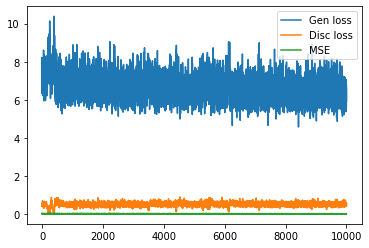

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


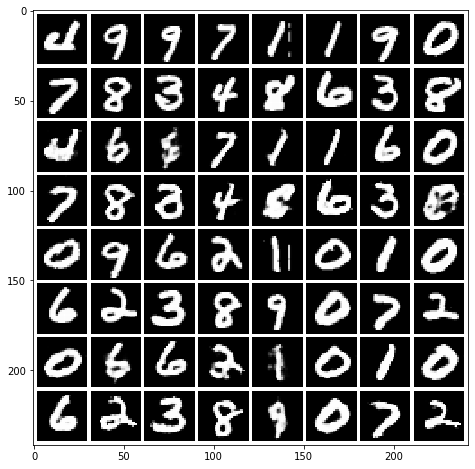

Mean squared dist: 0.028589236
epoch: 12 	 step:0 	 loss: 5.701
epoch: 12 	 step:100 	 loss: 5.749
epoch: 12 	 step:200 	 loss: 7.172
epoch: 12 	 step:300 	 loss: 6.492
epoch: 12 	 step:400 	 loss: 5.33
epoch: 12 	 step:500 	 loss: 6.715
epoch: 12 	 step:600 	 loss: 6.84
epoch: 12 	 step:700 	 loss: 6.214
epoch: 12 	 step:800 	 loss: 6.29
epoch: 12 	 step:900 	 loss: 7.07
epoch: 12 	 step:1000 	 loss: 7.71
epoch: 12 	 step:1100 	 loss: 5.832
epoch: 12 	 step:1200 	 loss: 6.087
epoch: 12 	 step:1300 	 loss: 7.116
epoch: 12 	 step:1400 	 loss: 6.051
epoch: 12 	 step:1500 	 loss: 5.501
epoch: 12 	 step:1600 	 loss: 6.417
epoch: 12 	 step:1700 	 loss: 6.2
epoch: 12 	 step:1800 	 loss: 6.798


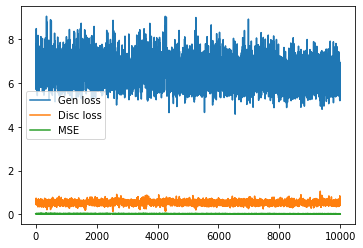

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


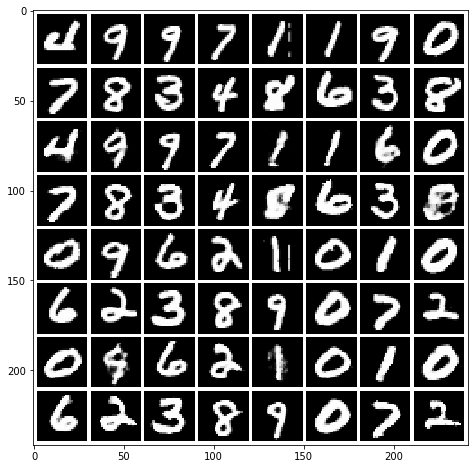

Mean squared dist: 0.027830811
epoch: 13 	 step:0 	 loss: 5.771
epoch: 13 	 step:100 	 loss: 5.217
epoch: 13 	 step:200 	 loss: 7.021
epoch: 13 	 step:300 	 loss: 6.33
epoch: 13 	 step:400 	 loss: 5.929
epoch: 13 	 step:500 	 loss: 6.554
epoch: 13 	 step:600 	 loss: 7.348
epoch: 13 	 step:700 	 loss: 6.1
epoch: 13 	 step:800 	 loss: 6.269
epoch: 13 	 step:900 	 loss: 5.993
epoch: 13 	 step:1000 	 loss: 5.695
epoch: 13 	 step:1100 	 loss: 5.723
epoch: 13 	 step:1200 	 loss: 5.696
epoch: 13 	 step:1300 	 loss: 5.79
epoch: 13 	 step:1400 	 loss: 5.843
epoch: 13 	 step:1500 	 loss: 7.104
epoch: 13 	 step:1600 	 loss: 5.497
epoch: 13 	 step:1700 	 loss: 6.117
epoch: 13 	 step:1800 	 loss: 6.388


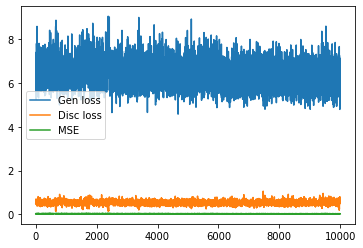

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


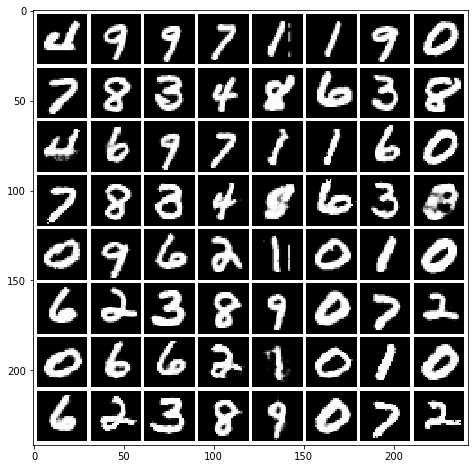

Mean squared dist: 0.027589254
epoch: 14 	 step:0 	 loss: 5.677
epoch: 14 	 step:100 	 loss: 5.102
epoch: 14 	 step:200 	 loss: 5.332
epoch: 14 	 step:300 	 loss: 4.969
epoch: 14 	 step:400 	 loss: 6.826
epoch: 14 	 step:500 	 loss: 5.749
epoch: 14 	 step:600 	 loss: 6.43
epoch: 14 	 step:700 	 loss: 6.485
epoch: 14 	 step:800 	 loss: 5.477
epoch: 14 	 step:900 	 loss: 6.495
epoch: 14 	 step:1000 	 loss: 5.506
epoch: 14 	 step:1100 	 loss: 5.672
epoch: 14 	 step:1200 	 loss: 6.896
epoch: 14 	 step:1300 	 loss: 5.846
epoch: 14 	 step:1400 	 loss: 6.236
epoch: 14 	 step:1500 	 loss: 6.287
epoch: 14 	 step:1600 	 loss: 7.196
epoch: 14 	 step:1700 	 loss: 5.68
epoch: 14 	 step:1800 	 loss: 6.529


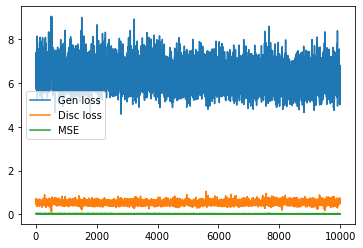

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


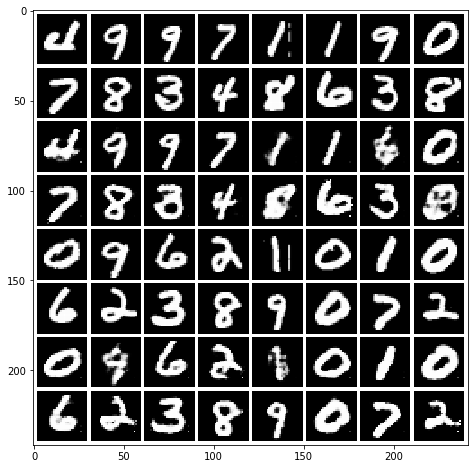

Mean squared dist: 0.027251612
epoch: 15 	 step:0 	 loss: 5.53
epoch: 15 	 step:100 	 loss: 6.189
epoch: 15 	 step:200 	 loss: 5.867
epoch: 15 	 step:300 	 loss: 5.739
epoch: 15 	 step:400 	 loss: 5.726
epoch: 15 	 step:500 	 loss: 5.607
epoch: 15 	 step:600 	 loss: 5.411
epoch: 15 	 step:700 	 loss: 6.166
epoch: 15 	 step:800 	 loss: 6.373
epoch: 15 	 step:900 	 loss: 5.935
epoch: 15 	 step:1000 	 loss: 5.747
epoch: 15 	 step:1100 	 loss: 5.564
epoch: 15 	 step:1200 	 loss: 5.409
epoch: 15 	 step:1300 	 loss: 5.899
epoch: 15 	 step:1400 	 loss: 6.219
epoch: 15 	 step:1500 	 loss: 6.237
epoch: 15 	 step:1600 	 loss: 5.979
epoch: 15 	 step:1700 	 loss: 6.209
epoch: 15 	 step:1800 	 loss: 5.802


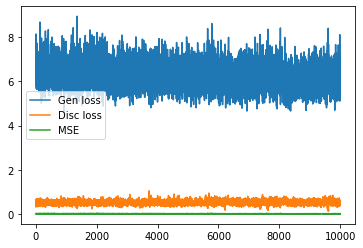

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


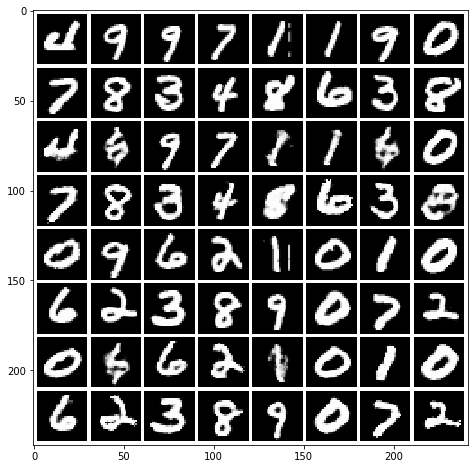

Mean squared dist: 0.026968516
epoch: 16 	 step:0 	 loss: 6.26
epoch: 16 	 step:100 	 loss: 5.797
epoch: 16 	 step:200 	 loss: 5.83
epoch: 16 	 step:300 	 loss: 6.818
epoch: 16 	 step:400 	 loss: 6.067
epoch: 16 	 step:500 	 loss: 5.803
epoch: 16 	 step:600 	 loss: 7.136
epoch: 16 	 step:700 	 loss: 6.396
epoch: 16 	 step:800 	 loss: 6.154
epoch: 16 	 step:900 	 loss: 5.059
epoch: 16 	 step:1000 	 loss: 5.559
epoch: 16 	 step:1100 	 loss: 6.474
epoch: 16 	 step:1200 	 loss: 6.566
epoch: 16 	 step:1300 	 loss: 5.317
epoch: 16 	 step:1400 	 loss: 6.622
epoch: 16 	 step:1500 	 loss: 5.886
epoch: 16 	 step:1600 	 loss: 5.428
epoch: 16 	 step:1700 	 loss: 6.573
epoch: 16 	 step:1800 	 loss: 6.167


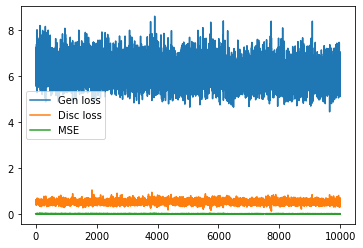

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


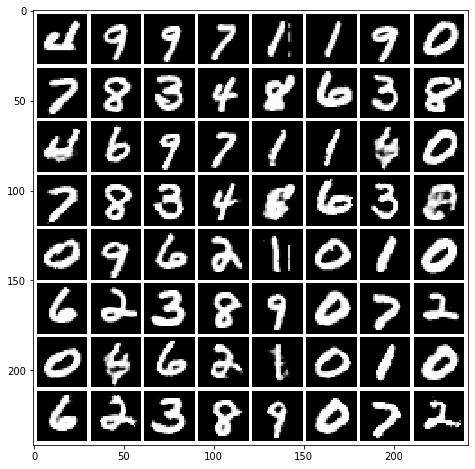

Mean squared dist: 0.026667932
epoch: 17 	 step:0 	 loss: 5.791
epoch: 17 	 step:100 	 loss: 6.581
epoch: 17 	 step:200 	 loss: 5.301
epoch: 17 	 step:300 	 loss: 5.662
epoch: 17 	 step:400 	 loss: 6.877
epoch: 17 	 step:500 	 loss: 5.253
epoch: 17 	 step:600 	 loss: 5.754
epoch: 17 	 step:700 	 loss: 5.446
epoch: 17 	 step:800 	 loss: 5.956
epoch: 17 	 step:900 	 loss: 5.964
epoch: 17 	 step:1000 	 loss: 5.503
epoch: 17 	 step:1100 	 loss: 5.727
epoch: 17 	 step:1200 	 loss: 6.364
epoch: 17 	 step:1300 	 loss: 6.175
epoch: 17 	 step:1400 	 loss: 6.489
epoch: 17 	 step:1500 	 loss: 5.665
epoch: 17 	 step:1600 	 loss: 5.54
epoch: 17 	 step:1700 	 loss: 5.174
epoch: 17 	 step:1800 	 loss: 5.419


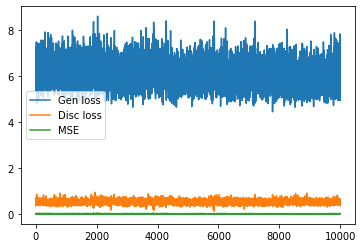

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


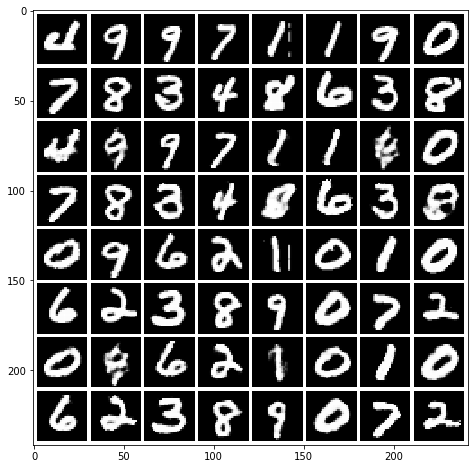

Mean squared dist: 0.026358986
epoch: 18 	 step:0 	 loss: 5.425
epoch: 18 	 step:100 	 loss: 5.321
epoch: 18 	 step:200 	 loss: 5.717
epoch: 18 	 step:300 	 loss: 5.049
epoch: 18 	 step:400 	 loss: 6.753
epoch: 18 	 step:500 	 loss: 5.942
epoch: 18 	 step:600 	 loss: 4.783
epoch: 18 	 step:700 	 loss: 5.546
epoch: 18 	 step:800 	 loss: 6.391
epoch: 18 	 step:900 	 loss: 6.048
epoch: 18 	 step:1000 	 loss: 5.587
epoch: 18 	 step:1100 	 loss: 6.796
epoch: 18 	 step:1200 	 loss: 7.025
epoch: 18 	 step:1300 	 loss: 6.025
epoch: 18 	 step:1400 	 loss: 5.814
epoch: 18 	 step:1500 	 loss: 5.227
epoch: 18 	 step:1600 	 loss: 5.918
epoch: 18 	 step:1700 	 loss: 5.454
epoch: 18 	 step:1800 	 loss: 5.41


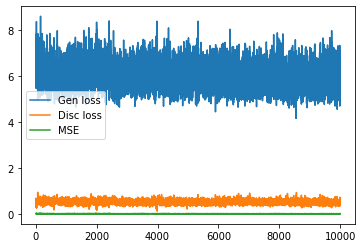

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


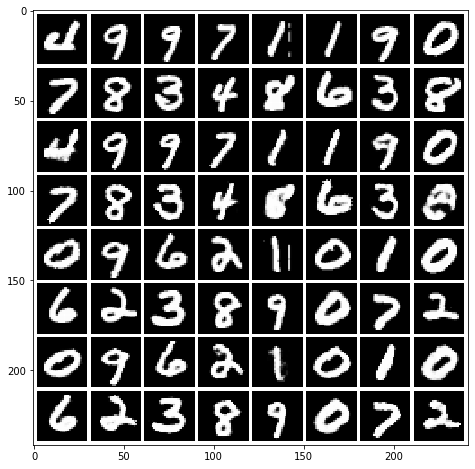

Mean squared dist: 0.026663957
epoch: 19 	 step:0 	 loss: 7.032
epoch: 19 	 step:100 	 loss: 5.981
epoch: 19 	 step:200 	 loss: 5.093
epoch: 19 	 step:300 	 loss: 5.985
epoch: 19 	 step:400 	 loss: 5.412
epoch: 19 	 step:500 	 loss: 5.653
epoch: 19 	 step:600 	 loss: 5.266
epoch: 19 	 step:700 	 loss: 5.075
epoch: 19 	 step:800 	 loss: 6.037
epoch: 19 	 step:900 	 loss: 6.445
epoch: 19 	 step:1000 	 loss: 5.391
epoch: 19 	 step:1100 	 loss: 5.726
epoch: 19 	 step:1200 	 loss: 5.446
epoch: 19 	 step:1300 	 loss: 4.901
epoch: 19 	 step:1400 	 loss: 5.937
epoch: 19 	 step:1500 	 loss: 5.128
epoch: 19 	 step:1600 	 loss: 6.139
epoch: 19 	 step:1700 	 loss: 5.469
epoch: 19 	 step:1800 	 loss: 5.935


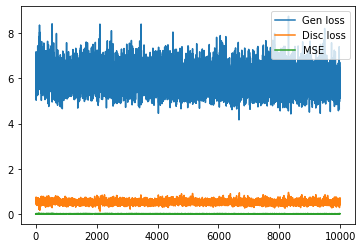

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


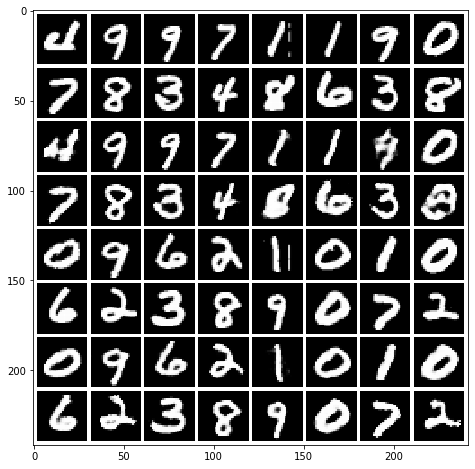

Mean squared dist: 0.026167352
epoch: 20 	 step:0 	 loss: 5.458
epoch: 20 	 step:100 	 loss: 5.583
epoch: 20 	 step:200 	 loss: 5.672
epoch: 20 	 step:300 	 loss: 6.012
epoch: 20 	 step:400 	 loss: 5.18
epoch: 20 	 step:500 	 loss: 5.846
epoch: 20 	 step:600 	 loss: 5.585
epoch: 20 	 step:700 	 loss: 5.492
epoch: 20 	 step:800 	 loss: 5.417
epoch: 20 	 step:900 	 loss: 4.927
epoch: 20 	 step:1000 	 loss: 5.975
epoch: 20 	 step:1100 	 loss: 5.609
epoch: 20 	 step:1200 	 loss: 5.725
epoch: 20 	 step:1300 	 loss: 5.966
epoch: 20 	 step:1400 	 loss: 6.689
epoch: 20 	 step:1500 	 loss: 6.128
epoch: 20 	 step:1600 	 loss: 5.863
epoch: 20 	 step:1700 	 loss: 6.221
epoch: 20 	 step:1800 	 loss: 6.189


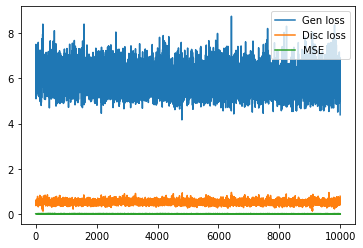

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


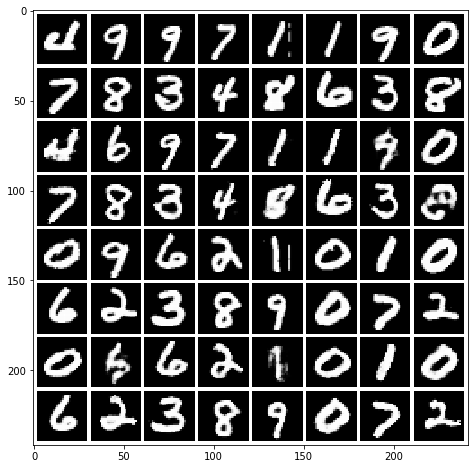

Mean squared dist: 0.026351176
epoch: 21 	 step:0 	 loss: 4.627
epoch: 21 	 step:100 	 loss: 5.449
epoch: 21 	 step:200 	 loss: 6.674
epoch: 21 	 step:300 	 loss: 5.869
epoch: 21 	 step:400 	 loss: 5.9
epoch: 21 	 step:500 	 loss: 4.703
epoch: 21 	 step:600 	 loss: 5.436
epoch: 21 	 step:700 	 loss: 7.111
epoch: 21 	 step:800 	 loss: 5.434
epoch: 21 	 step:900 	 loss: 5.709
epoch: 21 	 step:1000 	 loss: 5.418
epoch: 21 	 step:1100 	 loss: 6.101
epoch: 21 	 step:1200 	 loss: 5.469
epoch: 21 	 step:1300 	 loss: 6.111
epoch: 21 	 step:1400 	 loss: 5.313
epoch: 21 	 step:1500 	 loss: 5.902
epoch: 21 	 step:1600 	 loss: 6.023
epoch: 21 	 step:1700 	 loss: 6.258
epoch: 21 	 step:1800 	 loss: 5.668


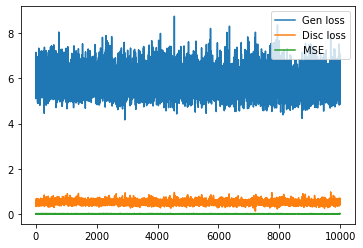

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


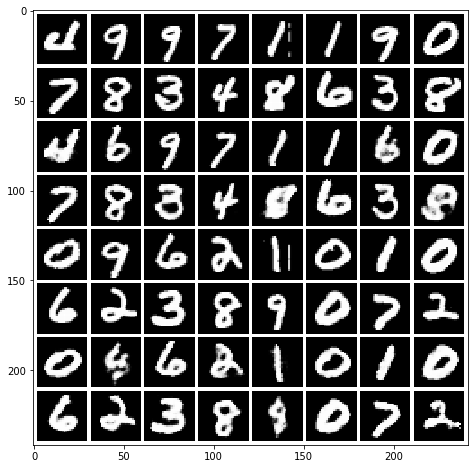

Mean squared dist: 0.025875265
epoch: 22 	 step:0 	 loss: 4.643
epoch: 22 	 step:100 	 loss: 5.469
epoch: 22 	 step:200 	 loss: 4.631
epoch: 22 	 step:300 	 loss: 5.292
epoch: 22 	 step:400 	 loss: 4.983
epoch: 22 	 step:500 	 loss: 6.099
epoch: 22 	 step:600 	 loss: 5.951
epoch: 22 	 step:700 	 loss: 6.498
epoch: 22 	 step:800 	 loss: 6.074
epoch: 22 	 step:900 	 loss: 5.677
epoch: 22 	 step:1000 	 loss: 5.119
epoch: 22 	 step:1100 	 loss: 5.249
epoch: 22 	 step:1200 	 loss: 5.179
epoch: 22 	 step:1300 	 loss: 5.88
epoch: 22 	 step:1400 	 loss: 4.747
epoch: 22 	 step:1500 	 loss: 6.065
epoch: 22 	 step:1600 	 loss: 5.769
epoch: 22 	 step:1700 	 loss: 6.058
epoch: 22 	 step:1800 	 loss: 5.674


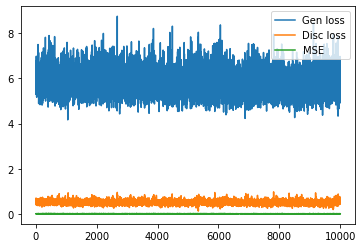

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


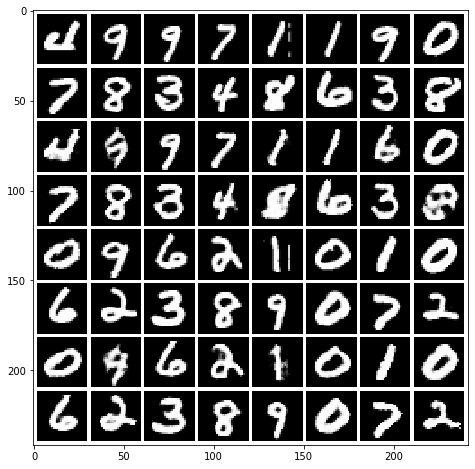

Mean squared dist: 0.025510002
epoch: 23 	 step:0 	 loss: 5.69
epoch: 23 	 step:100 	 loss: 5.037
epoch: 23 	 step:200 	 loss: 5.624
epoch: 23 	 step:300 	 loss: 5.132
epoch: 23 	 step:400 	 loss: 5.553
epoch: 23 	 step:500 	 loss: 6.347
epoch: 23 	 step:600 	 loss: 5.442
epoch: 23 	 step:700 	 loss: 5.395
epoch: 23 	 step:800 	 loss: 5.808
epoch: 23 	 step:900 	 loss: 5.521
epoch: 23 	 step:1000 	 loss: 5.333
epoch: 23 	 step:1100 	 loss: 5.029
epoch: 23 	 step:1200 	 loss: 5.689
epoch: 23 	 step:1300 	 loss: 5.295
epoch: 23 	 step:1400 	 loss: 5.115
epoch: 23 	 step:1500 	 loss: 5.659
epoch: 23 	 step:1600 	 loss: 5.096
epoch: 23 	 step:1700 	 loss: 5.591
epoch: 23 	 step:1800 	 loss: 5.426


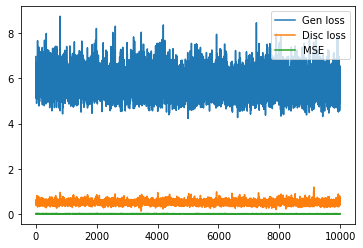

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


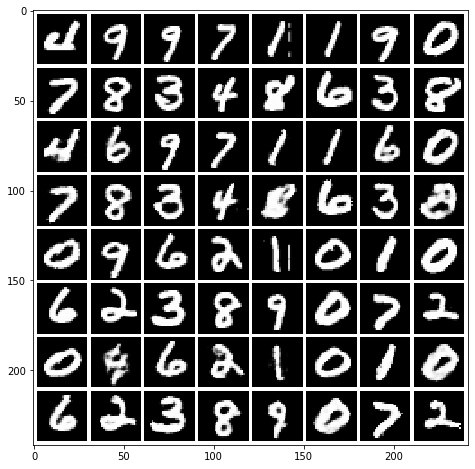

Mean squared dist: 0.025718141
epoch: 24 	 step:0 	 loss: 5.607
epoch: 24 	 step:100 	 loss: 5.241
epoch: 24 	 step:200 	 loss: 6.562
epoch: 24 	 step:300 	 loss: 5.604
epoch: 24 	 step:400 	 loss: 5.52
epoch: 24 	 step:500 	 loss: 5.91
epoch: 24 	 step:600 	 loss: 5.755
epoch: 24 	 step:700 	 loss: 6.019
epoch: 24 	 step:800 	 loss: 5.531
epoch: 24 	 step:900 	 loss: 5.466
epoch: 24 	 step:1000 	 loss: 6.025
epoch: 24 	 step:1100 	 loss: 5.45
epoch: 24 	 step:1200 	 loss: 5.798
epoch: 24 	 step:1300 	 loss: 5.077
epoch: 24 	 step:1400 	 loss: 5.051
epoch: 24 	 step:1500 	 loss: 5.778
epoch: 24 	 step:1600 	 loss: 5.774
epoch: 24 	 step:1700 	 loss: 6.255
epoch: 24 	 step:1800 	 loss: 6.231


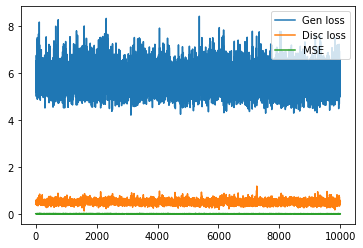

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


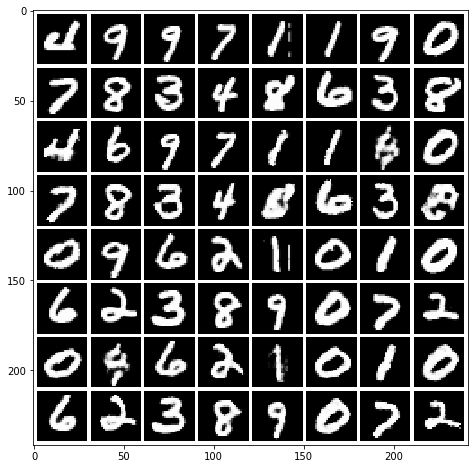

Mean squared dist: 0.025545325
epoch: 25 	 step:0 	 loss: 6.436
epoch: 25 	 step:100 	 loss: 4.52
epoch: 25 	 step:200 	 loss: 5.087
epoch: 25 	 step:300 	 loss: 5.038
epoch: 25 	 step:400 	 loss: 5.985
epoch: 25 	 step:500 	 loss: 6.853
epoch: 25 	 step:600 	 loss: 5.392
epoch: 25 	 step:700 	 loss: 6.337
epoch: 25 	 step:800 	 loss: 5.487
epoch: 25 	 step:900 	 loss: 6.424
epoch: 25 	 step:1000 	 loss: 6.462
epoch: 25 	 step:1100 	 loss: 5.723
epoch: 25 	 step:1200 	 loss: 5.395
epoch: 25 	 step:1300 	 loss: 5.823
epoch: 25 	 step:1400 	 loss: 5.461
epoch: 25 	 step:1500 	 loss: 5.866
epoch: 25 	 step:1600 	 loss: 4.727
epoch: 25 	 step:1700 	 loss: 5.02
epoch: 25 	 step:1800 	 loss: 5.8


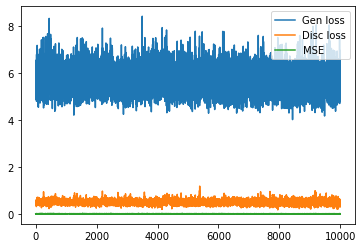

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


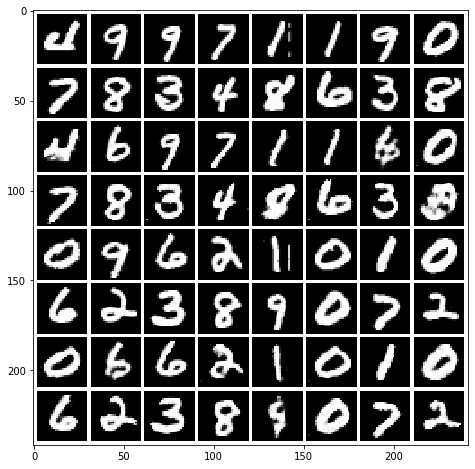

Mean squared dist: 0.025226403
epoch: 26 	 step:0 	 loss: 5.057
epoch: 26 	 step:100 	 loss: 5.647
epoch: 26 	 step:200 	 loss: 5.946
epoch: 26 	 step:300 	 loss: 6.005
epoch: 26 	 step:400 	 loss: 5.916
epoch: 26 	 step:500 	 loss: 6.161
epoch: 26 	 step:600 	 loss: 6.167
epoch: 26 	 step:700 	 loss: 5.118
epoch: 26 	 step:800 	 loss: 4.937
epoch: 26 	 step:900 	 loss: 6.032
epoch: 26 	 step:1000 	 loss: 5.766
epoch: 26 	 step:1100 	 loss: 5.579
epoch: 26 	 step:1200 	 loss: 5.422
epoch: 26 	 step:1300 	 loss: 5.657
epoch: 26 	 step:1400 	 loss: 4.502
epoch: 26 	 step:1500 	 loss: 5.102
epoch: 26 	 step:1600 	 loss: 7.304
epoch: 26 	 step:1700 	 loss: 5.034
epoch: 26 	 step:1800 	 loss: 5.132


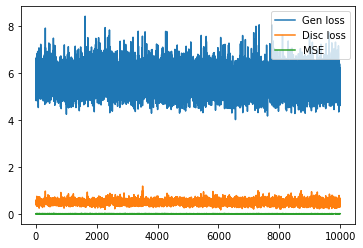

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


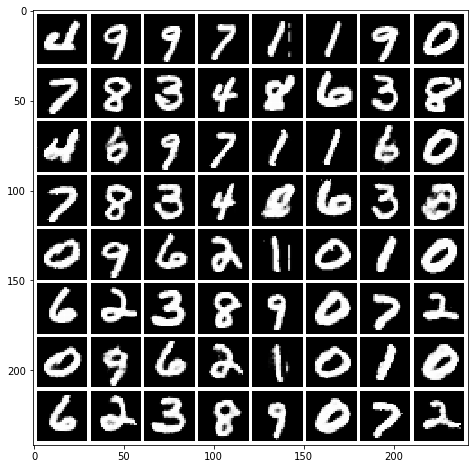

Mean squared dist: 0.025089959
epoch: 27 	 step:0 	 loss: 5.056
epoch: 27 	 step:100 	 loss: 5.825
epoch: 27 	 step:200 	 loss: 5.437
epoch: 27 	 step:300 	 loss: 4.611
epoch: 27 	 step:400 	 loss: 5.021
epoch: 27 	 step:500 	 loss: 5.66
epoch: 27 	 step:600 	 loss: 5.696
epoch: 27 	 step:700 	 loss: 6.272
epoch: 27 	 step:800 	 loss: 6.056
epoch: 27 	 step:900 	 loss: 4.778
epoch: 27 	 step:1000 	 loss: 5.726
epoch: 27 	 step:1100 	 loss: 5.297
epoch: 27 	 step:1200 	 loss: 6.699
epoch: 27 	 step:1300 	 loss: 6.019
epoch: 27 	 step:1400 	 loss: 6.463
epoch: 27 	 step:1500 	 loss: 5.753
epoch: 27 	 step:1600 	 loss: 6.132
epoch: 27 	 step:1700 	 loss: 5.732
epoch: 27 	 step:1800 	 loss: 5.147


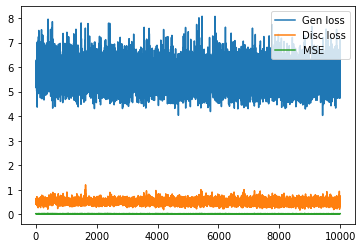

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


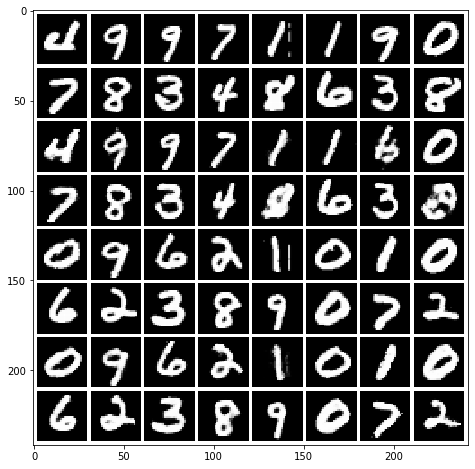

Mean squared dist: 0.025180584
epoch: 28 	 step:0 	 loss: 5.976
epoch: 28 	 step:100 	 loss: 5.724
epoch: 28 	 step:200 	 loss: 6.145
epoch: 28 	 step:300 	 loss: 4.843
epoch: 28 	 step:400 	 loss: 5.478
epoch: 28 	 step:500 	 loss: 4.644
epoch: 28 	 step:600 	 loss: 5.218
epoch: 28 	 step:700 	 loss: 5.095
epoch: 28 	 step:800 	 loss: 6.1
epoch: 28 	 step:900 	 loss: 4.714
epoch: 28 	 step:1000 	 loss: 5.031
epoch: 28 	 step:1100 	 loss: 4.93
epoch: 28 	 step:1200 	 loss: 5.241
epoch: 28 	 step:1300 	 loss: 5.231
epoch: 28 	 step:1400 	 loss: 5.723
epoch: 28 	 step:1500 	 loss: 5.267
epoch: 28 	 step:1600 	 loss: 5.72
epoch: 28 	 step:1700 	 loss: 5.003
epoch: 28 	 step:1800 	 loss: 6.108


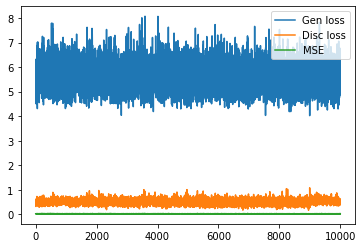

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


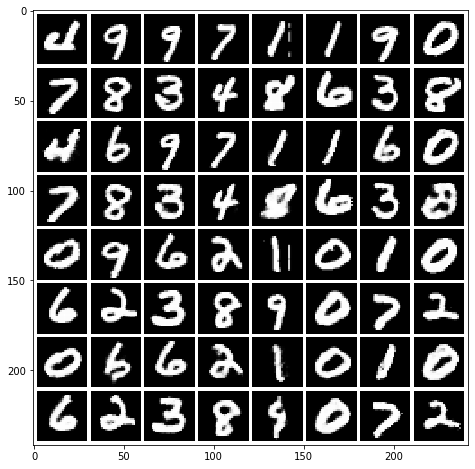

Mean squared dist: 0.025687171
epoch: 29 	 step:0 	 loss: 6.043
epoch: 29 	 step:100 	 loss: 4.642
epoch: 29 	 step:200 	 loss: 4.537
epoch: 29 	 step:300 	 loss: 5.279
epoch: 29 	 step:400 	 loss: 5.578
epoch: 29 	 step:500 	 loss: 5.245
epoch: 29 	 step:600 	 loss: 6.007
epoch: 29 	 step:700 	 loss: 4.95
epoch: 29 	 step:800 	 loss: 5.136
epoch: 29 	 step:900 	 loss: 4.784
epoch: 29 	 step:1000 	 loss: 5.4
epoch: 29 	 step:1100 	 loss: 6.099
epoch: 29 	 step:1200 	 loss: 6.469
epoch: 29 	 step:1300 	 loss: 5.388
epoch: 29 	 step:1400 	 loss: 5.503
epoch: 29 	 step:1500 	 loss: 5.362
epoch: 29 	 step:1600 	 loss: 5.64
epoch: 29 	 step:1700 	 loss: 5.339
epoch: 29 	 step:1800 	 loss: 5.494


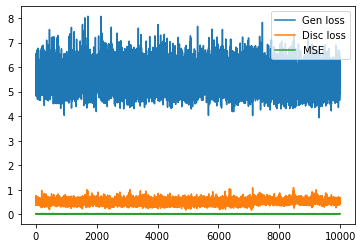

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


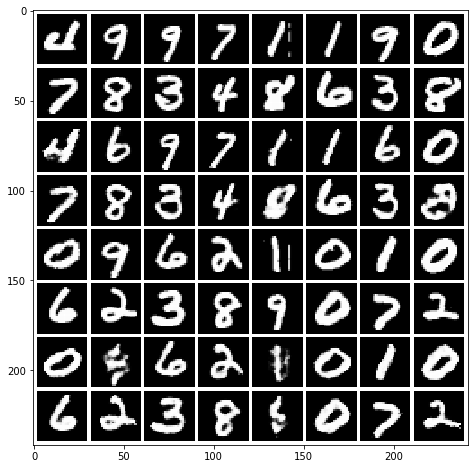

Mean squared dist: 0.02575973
epoch: 30 	 step:0 	 loss: 4.956
epoch: 30 	 step:100 	 loss: 4.905
epoch: 30 	 step:200 	 loss: 5.217
epoch: 30 	 step:300 	 loss: 5.366
epoch: 30 	 step:400 	 loss: 5.643
epoch: 30 	 step:500 	 loss: 5.115
epoch: 30 	 step:600 	 loss: 5.27
epoch: 30 	 step:700 	 loss: 6.038
epoch: 30 	 step:800 	 loss: 5.146
epoch: 30 	 step:900 	 loss: 4.515
epoch: 30 	 step:1000 	 loss: 5.404
epoch: 30 	 step:1100 	 loss: 5.61
epoch: 30 	 step:1200 	 loss: 5.636
epoch: 30 	 step:1300 	 loss: 5.367
epoch: 30 	 step:1400 	 loss: 6.233
epoch: 30 	 step:1500 	 loss: 4.611
epoch: 30 	 step:1600 	 loss: 5.655
epoch: 30 	 step:1700 	 loss: 4.801
epoch: 30 	 step:1800 	 loss: 4.741


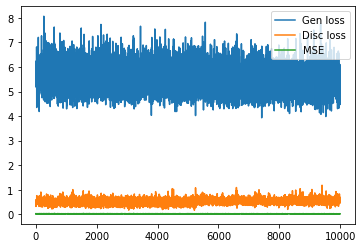

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


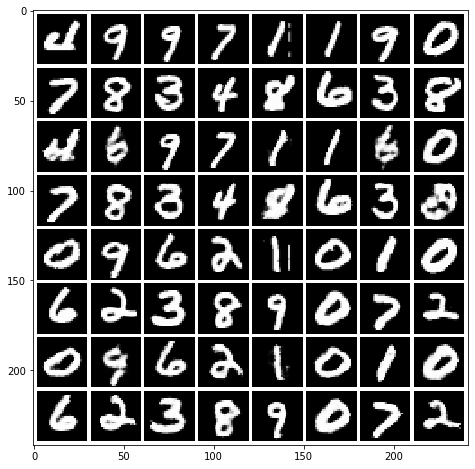

Mean squared dist: 0.024891693
epoch: 31 	 step:0 	 loss: 4.316
epoch: 31 	 step:100 	 loss: 5.006
epoch: 31 	 step:200 	 loss: 5.55
epoch: 31 	 step:300 	 loss: 5.053
epoch: 31 	 step:400 	 loss: 4.819
epoch: 31 	 step:500 	 loss: 5.489
epoch: 31 	 step:600 	 loss: 5.319
epoch: 31 	 step:700 	 loss: 5.467
epoch: 31 	 step:800 	 loss: 6.099
epoch: 31 	 step:900 	 loss: 5.246
epoch: 31 	 step:1000 	 loss: 5.038
epoch: 31 	 step:1100 	 loss: 5.048
epoch: 31 	 step:1200 	 loss: 4.885
epoch: 31 	 step:1300 	 loss: 5.336
epoch: 31 	 step:1400 	 loss: 5.361
epoch: 31 	 step:1500 	 loss: 4.871
epoch: 31 	 step:1600 	 loss: 5.164
epoch: 31 	 step:1700 	 loss: 5.113
epoch: 31 	 step:1800 	 loss: 5.229


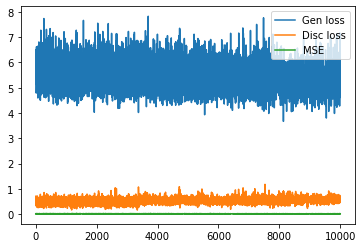

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


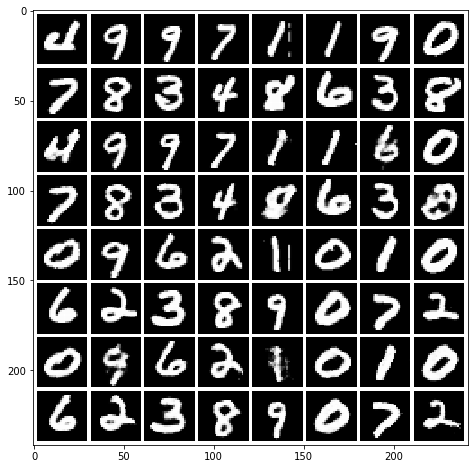

Mean squared dist: 0.025067946
epoch: 32 	 step:0 	 loss: 5.288
epoch: 32 	 step:100 	 loss: 4.222
epoch: 32 	 step:200 	 loss: 5.154
epoch: 32 	 step:300 	 loss: 5.176
epoch: 32 	 step:400 	 loss: 5.124
epoch: 32 	 step:500 	 loss: 6.067
epoch: 32 	 step:600 	 loss: 5.629
epoch: 32 	 step:700 	 loss: 4.867
epoch: 32 	 step:800 	 loss: 4.869
epoch: 32 	 step:900 	 loss: 5.857
epoch: 32 	 step:1000 	 loss: 5.677
epoch: 32 	 step:1100 	 loss: 6.024
epoch: 32 	 step:1200 	 loss: 5.727
epoch: 32 	 step:1300 	 loss: 4.898
epoch: 32 	 step:1400 	 loss: 5.146
epoch: 32 	 step:1500 	 loss: 5.752
epoch: 32 	 step:1600 	 loss: 4.853
epoch: 32 	 step:1700 	 loss: 5.762
epoch: 32 	 step:1800 	 loss: 4.937


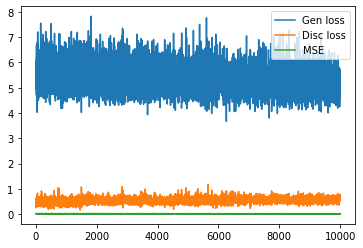

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


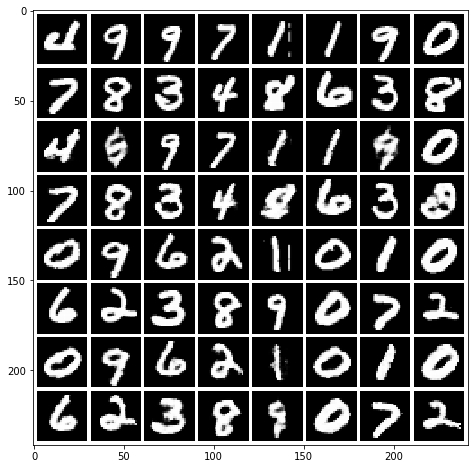

Mean squared dist: 0.025240375
epoch: 33 	 step:0 	 loss: 5.319
epoch: 33 	 step:100 	 loss: 4.89
epoch: 33 	 step:200 	 loss: 4.698
epoch: 33 	 step:300 	 loss: 4.952
epoch: 33 	 step:400 	 loss: 5.779
epoch: 33 	 step:500 	 loss: 4.465
epoch: 33 	 step:600 	 loss: 5.917
epoch: 33 	 step:700 	 loss: 5.068
epoch: 33 	 step:800 	 loss: 5.068
epoch: 33 	 step:900 	 loss: 5.328
epoch: 33 	 step:1000 	 loss: 4.976
epoch: 33 	 step:1100 	 loss: 4.911
epoch: 33 	 step:1200 	 loss: 5.204
epoch: 33 	 step:1300 	 loss: 5.098
epoch: 33 	 step:1400 	 loss: 5.498
epoch: 33 	 step:1500 	 loss: 5.097
epoch: 33 	 step:1600 	 loss: 5.325
epoch: 33 	 step:1700 	 loss: 5.097
epoch: 33 	 step:1800 	 loss: 4.949


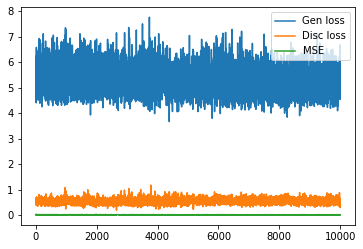

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


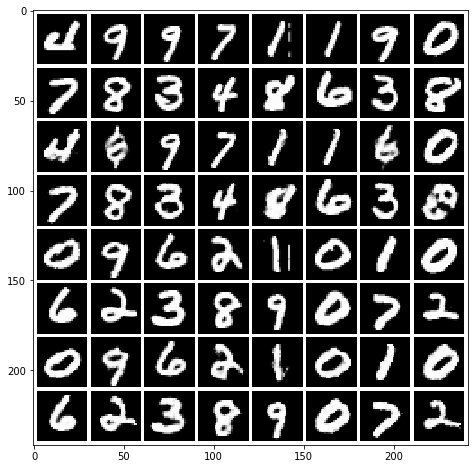

Mean squared dist: 0.024752766
epoch: 34 	 step:0 	 loss: 4.609
epoch: 34 	 step:100 	 loss: 4.557
epoch: 34 	 step:200 	 loss: 4.854
epoch: 34 	 step:300 	 loss: 4.786
epoch: 34 	 step:400 	 loss: 5.081
epoch: 34 	 step:500 	 loss: 4.676
epoch: 34 	 step:600 	 loss: 4.82
epoch: 34 	 step:700 	 loss: 4.755
epoch: 34 	 step:800 	 loss: 5.502
epoch: 34 	 step:900 	 loss: 5.534
epoch: 34 	 step:1000 	 loss: 5.25
epoch: 34 	 step:1100 	 loss: 4.927
epoch: 34 	 step:1200 	 loss: 4.69
epoch: 34 	 step:1300 	 loss: 4.514
epoch: 34 	 step:1400 	 loss: 5.179
epoch: 34 	 step:1500 	 loss: 5.379
epoch: 34 	 step:1600 	 loss: 5.312
epoch: 34 	 step:1700 	 loss: 4.712
epoch: 34 	 step:1800 	 loss: 4.731


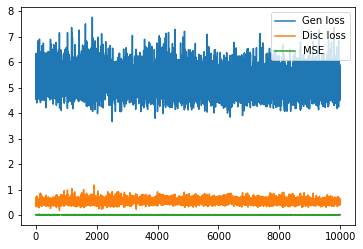

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


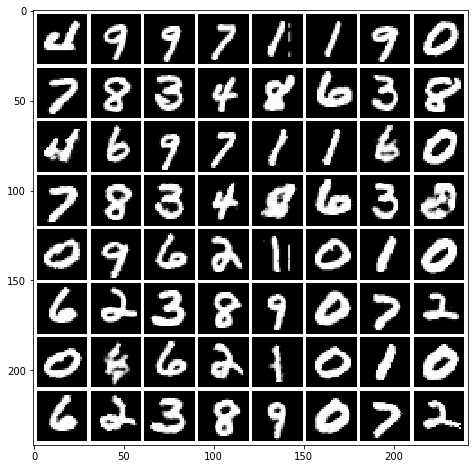

Mean squared dist: 0.02497683
epoch: 35 	 step:0 	 loss: 5.454
epoch: 35 	 step:100 	 loss: 5.465
epoch: 35 	 step:200 	 loss: 4.799
epoch: 35 	 step:300 	 loss: 6.304
epoch: 35 	 step:400 	 loss: 4.995
epoch: 35 	 step:500 	 loss: 6.203
epoch: 35 	 step:600 	 loss: 4.773
epoch: 35 	 step:700 	 loss: 4.751
epoch: 35 	 step:800 	 loss: 5.196
epoch: 35 	 step:900 	 loss: 5.003
epoch: 35 	 step:1000 	 loss: 5.952
epoch: 35 	 step:1100 	 loss: 5.343
epoch: 35 	 step:1200 	 loss: 5.681
epoch: 35 	 step:1300 	 loss: 4.857
epoch: 35 	 step:1400 	 loss: 5.134
epoch: 35 	 step:1500 	 loss: 5.946
epoch: 35 	 step:1600 	 loss: 5.696
epoch: 35 	 step:1700 	 loss: 5.826
epoch: 35 	 step:1800 	 loss: 5.993


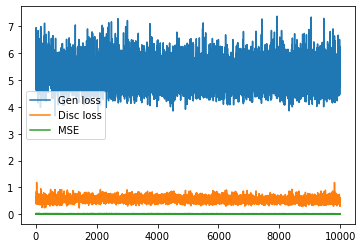

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


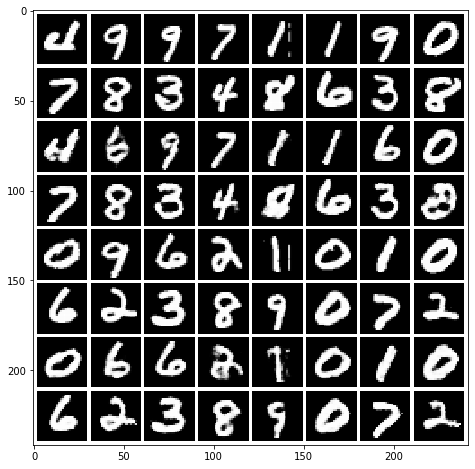

Mean squared dist: 0.024755498
epoch: 36 	 step:0 	 loss: 5.749
epoch: 36 	 step:100 	 loss: 5.444
epoch: 36 	 step:200 	 loss: 4.726
epoch: 36 	 step:300 	 loss: 5.247
epoch: 36 	 step:400 	 loss: 5.435
epoch: 36 	 step:500 	 loss: 4.904
epoch: 36 	 step:600 	 loss: 4.983
epoch: 36 	 step:700 	 loss: 5.167
epoch: 36 	 step:800 	 loss: 5.108
epoch: 36 	 step:900 	 loss: 5.551
epoch: 36 	 step:1000 	 loss: 5.446
epoch: 36 	 step:1100 	 loss: 4.34
epoch: 36 	 step:1200 	 loss: 6.063
epoch: 36 	 step:1300 	 loss: 5.465
epoch: 36 	 step:1400 	 loss: 5.856
epoch: 36 	 step:1500 	 loss: 5.135
epoch: 36 	 step:1600 	 loss: 4.911
epoch: 36 	 step:1700 	 loss: 4.869
epoch: 36 	 step:1800 	 loss: 4.584


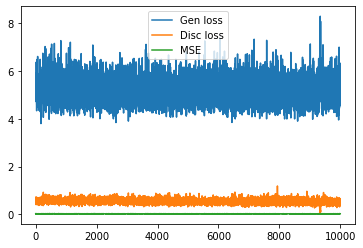

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


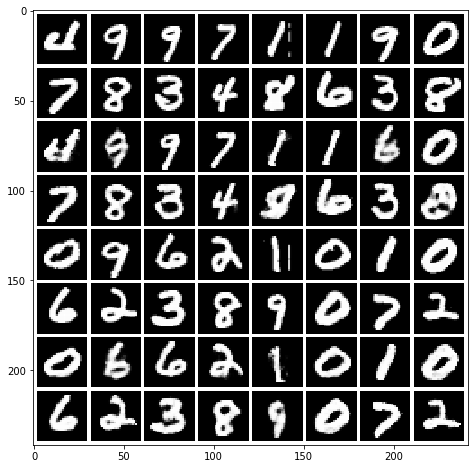

Mean squared dist: 0.025118306
epoch: 37 	 step:0 	 loss: 4.57
epoch: 37 	 step:100 	 loss: 5.788
epoch: 37 	 step:200 	 loss: 4.976
epoch: 37 	 step:300 	 loss: 5.078
epoch: 37 	 step:400 	 loss: 5.503
epoch: 37 	 step:500 	 loss: 4.798
epoch: 37 	 step:600 	 loss: 5.331
epoch: 37 	 step:700 	 loss: 5.078
epoch: 37 	 step:800 	 loss: 5.171
epoch: 37 	 step:900 	 loss: 5.331
epoch: 37 	 step:1000 	 loss: 5.091
epoch: 37 	 step:1100 	 loss: 5.069
epoch: 37 	 step:1200 	 loss: 5.83
epoch: 37 	 step:1300 	 loss: 4.568
epoch: 37 	 step:1400 	 loss: 4.618
epoch: 37 	 step:1500 	 loss: 5.349
epoch: 37 	 step:1600 	 loss: 4.901
epoch: 37 	 step:1700 	 loss: 5.388
epoch: 37 	 step:1800 	 loss: 5.686


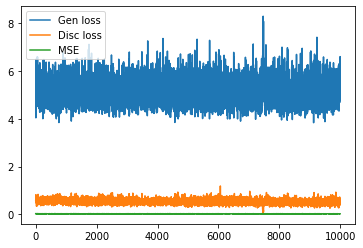

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


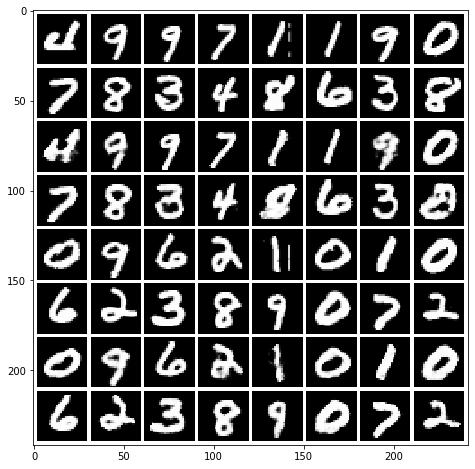

Mean squared dist: 0.025045168
epoch: 38 	 step:0 	 loss: 4.876
epoch: 38 	 step:100 	 loss: 4.479
epoch: 38 	 step:200 	 loss: 5.241
epoch: 38 	 step:300 	 loss: 4.981
epoch: 38 	 step:400 	 loss: 4.666
epoch: 38 	 step:500 	 loss: 4.431
epoch: 38 	 step:600 	 loss: 5.982
epoch: 38 	 step:700 	 loss: 6.787
epoch: 38 	 step:800 	 loss: 4.783
epoch: 38 	 step:900 	 loss: 4.868
epoch: 38 	 step:1000 	 loss: 4.774
epoch: 38 	 step:1100 	 loss: 4.77
epoch: 38 	 step:1200 	 loss: 4.194
epoch: 38 	 step:1300 	 loss: 5.049
epoch: 38 	 step:1400 	 loss: 4.891
epoch: 38 	 step:1500 	 loss: 5.563
epoch: 38 	 step:1600 	 loss: 4.937
epoch: 38 	 step:1700 	 loss: 5.04
epoch: 38 	 step:1800 	 loss: 5.445


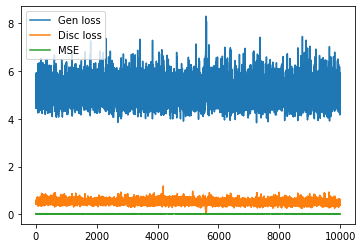

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


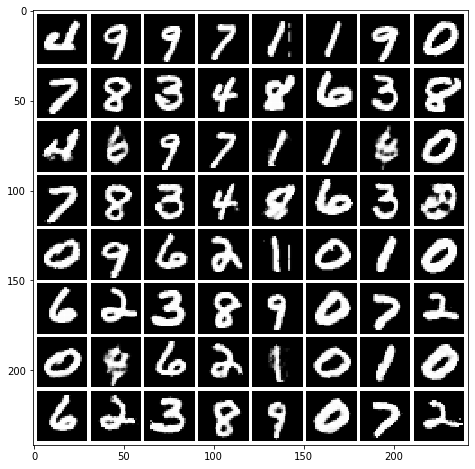

Mean squared dist: 0.025005957
epoch: 39 	 step:0 	 loss: 5.233
epoch: 39 	 step:100 	 loss: 5.972
epoch: 39 	 step:200 	 loss: 5.88
epoch: 39 	 step:300 	 loss: 6.145
epoch: 39 	 step:400 	 loss: 5.065
epoch: 39 	 step:500 	 loss: 5.375
epoch: 39 	 step:600 	 loss: 4.883
epoch: 39 	 step:700 	 loss: 5.642
epoch: 39 	 step:800 	 loss: 5.049
epoch: 39 	 step:900 	 loss: 4.427
epoch: 39 	 step:1000 	 loss: 5.445
epoch: 39 	 step:1100 	 loss: 5.162
epoch: 39 	 step:1200 	 loss: 5.811
epoch: 39 	 step:1300 	 loss: 5.564
epoch: 39 	 step:1400 	 loss: 5.385
epoch: 39 	 step:1500 	 loss: 5.672
epoch: 39 	 step:1600 	 loss: 4.329
epoch: 39 	 step:1700 	 loss: 5.485
epoch: 39 	 step:1800 	 loss: 4.635


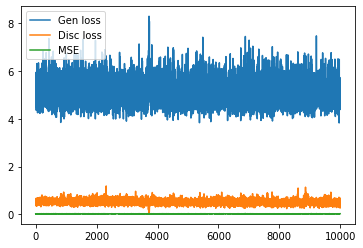

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


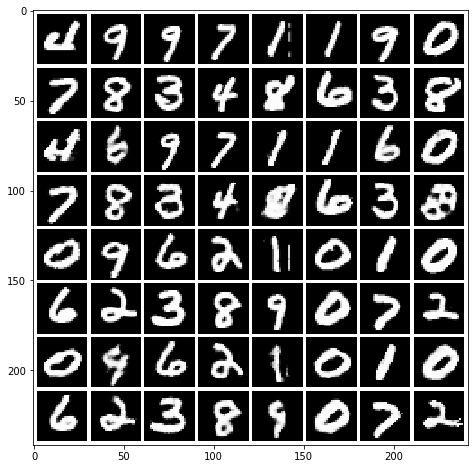

Mean squared dist: 0.024820799
epoch: 40 	 step:0 	 loss: 5.177
epoch: 40 	 step:100 	 loss: 5.241
epoch: 40 	 step:200 	 loss: 4.976
epoch: 40 	 step:300 	 loss: 5.294
epoch: 40 	 step:400 	 loss: 6.173
epoch: 40 	 step:500 	 loss: 5.074
epoch: 40 	 step:600 	 loss: 4.845
epoch: 40 	 step:700 	 loss: 5.07
epoch: 40 	 step:800 	 loss: 4.888
epoch: 40 	 step:900 	 loss: 4.711
epoch: 40 	 step:1000 	 loss: 5.206
epoch: 40 	 step:1100 	 loss: 4.884
epoch: 40 	 step:1200 	 loss: 5.207
epoch: 40 	 step:1300 	 loss: 5.069
epoch: 40 	 step:1400 	 loss: 5.605
epoch: 40 	 step:1500 	 loss: 4.285
epoch: 40 	 step:1600 	 loss: 4.523
epoch: 40 	 step:1700 	 loss: 5.813
epoch: 40 	 step:1800 	 loss: 5.456


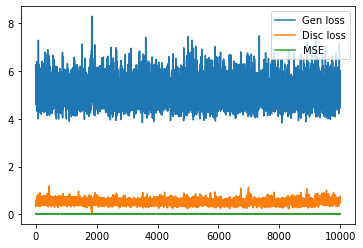

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


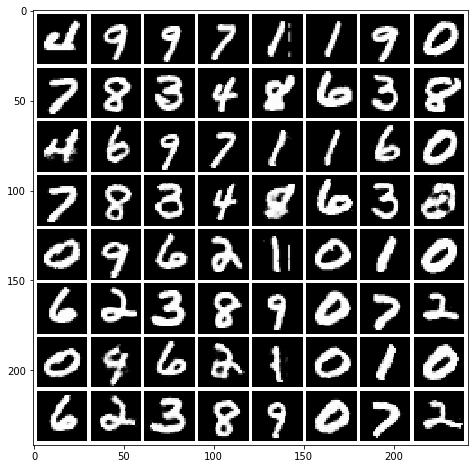

Mean squared dist: 0.025394749
epoch: 41 	 step:0 	 loss: 5.694
epoch: 41 	 step:100 	 loss: 5.167
epoch: 41 	 step:200 	 loss: 4.637
epoch: 41 	 step:300 	 loss: 4.985
epoch: 41 	 step:400 	 loss: 4.95
epoch: 41 	 step:500 	 loss: 5.687
epoch: 41 	 step:600 	 loss: 5.591
epoch: 41 	 step:700 	 loss: 5.392
epoch: 41 	 step:800 	 loss: 4.907
epoch: 41 	 step:900 	 loss: 4.76
epoch: 41 	 step:1000 	 loss: 6.032
epoch: 41 	 step:1100 	 loss: 5.943
epoch: 41 	 step:1200 	 loss: 4.702
epoch: 41 	 step:1300 	 loss: 6.003
epoch: 41 	 step:1400 	 loss: 6.708
epoch: 41 	 step:1500 	 loss: 4.525
epoch: 41 	 step:1600 	 loss: 4.85
epoch: 41 	 step:1700 	 loss: 4.824
epoch: 41 	 step:1800 	 loss: 5.261


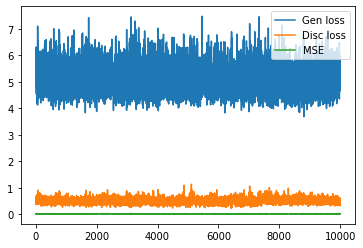

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


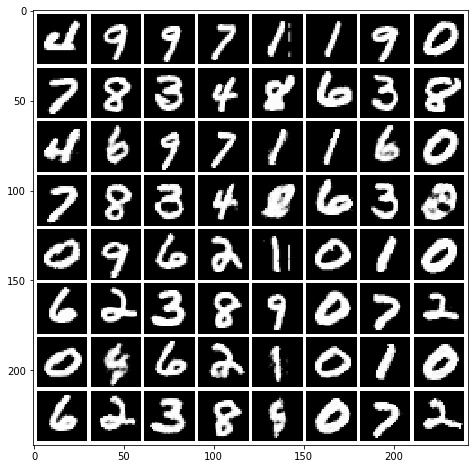

Mean squared dist: 0.024767222
epoch: 42 	 step:0 	 loss: 4.399
epoch: 42 	 step:100 	 loss: 4.987
epoch: 42 	 step:200 	 loss: 5.419
epoch: 42 	 step:300 	 loss: 5.249
epoch: 42 	 step:400 	 loss: 4.65
epoch: 42 	 step:500 	 loss: 4.707
epoch: 42 	 step:600 	 loss: 4.44
epoch: 42 	 step:700 	 loss: 4.158
epoch: 42 	 step:800 	 loss: 5.256
epoch: 42 	 step:900 	 loss: 5.068
epoch: 42 	 step:1000 	 loss: 4.814
epoch: 42 	 step:1100 	 loss: 4.563
epoch: 42 	 step:1200 	 loss: 4.599
epoch: 42 	 step:1300 	 loss: 4.583
epoch: 42 	 step:1400 	 loss: 5.224
epoch: 42 	 step:1500 	 loss: 4.899
epoch: 42 	 step:1600 	 loss: 5.703
epoch: 42 	 step:1700 	 loss: 4.924
epoch: 42 	 step:1800 	 loss: 4.697


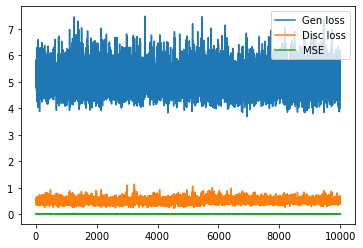

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


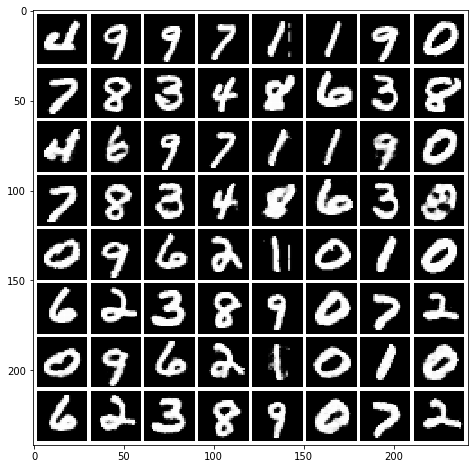

Mean squared dist: 0.024319218
epoch: 43 	 step:0 	 loss: 4.116
epoch: 43 	 step:100 	 loss: 4.656
epoch: 43 	 step:200 	 loss: 4.491
epoch: 43 	 step:300 	 loss: 5.423
epoch: 43 	 step:400 	 loss: 4.164
epoch: 43 	 step:500 	 loss: 4.483
epoch: 43 	 step:600 	 loss: 5.043
epoch: 43 	 step:700 	 loss: 4.75
epoch: 43 	 step:800 	 loss: 5.915
epoch: 43 	 step:900 	 loss: 4.557
epoch: 43 	 step:1000 	 loss: 5.11
epoch: 43 	 step:1100 	 loss: 5.403
epoch: 43 	 step:1200 	 loss: 5.38
epoch: 43 	 step:1300 	 loss: 4.741
epoch: 43 	 step:1400 	 loss: 6.505
epoch: 43 	 step:1500 	 loss: 5.623
epoch: 43 	 step:1600 	 loss: 5.159
epoch: 43 	 step:1700 	 loss: 5.679
epoch: 43 	 step:1800 	 loss: 4.807


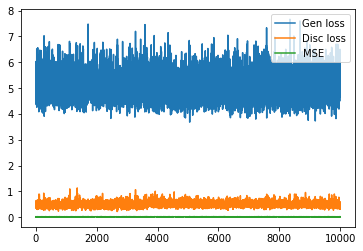

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


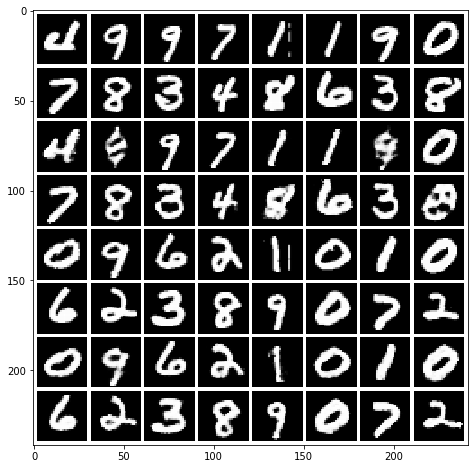

Mean squared dist: 0.02447255
epoch: 44 	 step:0 	 loss: 5.025
epoch: 44 	 step:100 	 loss: 4.529
epoch: 44 	 step:200 	 loss: 5.848
epoch: 44 	 step:300 	 loss: 4.446
epoch: 44 	 step:400 	 loss: 5.237
epoch: 44 	 step:500 	 loss: 4.393
epoch: 44 	 step:600 	 loss: 4.979
epoch: 44 	 step:700 	 loss: 4.568
epoch: 44 	 step:800 	 loss: 4.576
epoch: 44 	 step:900 	 loss: 5.76
epoch: 44 	 step:1000 	 loss: 4.433
epoch: 44 	 step:1100 	 loss: 5.571
epoch: 44 	 step:1200 	 loss: 5.202
epoch: 44 	 step:1300 	 loss: 5.051
epoch: 44 	 step:1400 	 loss: 4.741
epoch: 44 	 step:1500 	 loss: 4.156
epoch: 44 	 step:1600 	 loss: 5.137
epoch: 44 	 step:1700 	 loss: 5.63
epoch: 44 	 step:1800 	 loss: 5.044


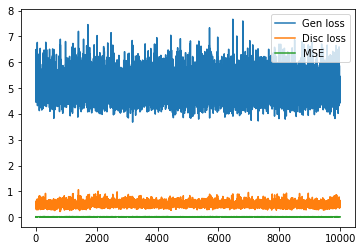

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


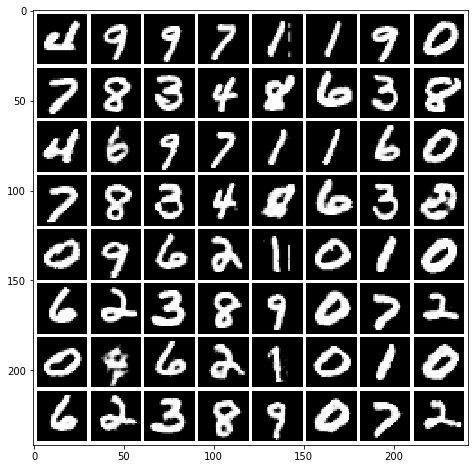

Mean squared dist: 0.024291586
epoch: 45 	 step:0 	 loss: 4.404
epoch: 45 	 step:100 	 loss: 5.069
epoch: 45 	 step:200 	 loss: 4.03
epoch: 45 	 step:300 	 loss: 5.273
epoch: 45 	 step:400 	 loss: 5.313
epoch: 45 	 step:500 	 loss: 5.276
epoch: 45 	 step:600 	 loss: 3.911
epoch: 45 	 step:700 	 loss: 5.214
epoch: 45 	 step:800 	 loss: 4.715
epoch: 45 	 step:900 	 loss: 4.703
epoch: 45 	 step:1000 	 loss: 4.749
epoch: 45 	 step:1100 	 loss: 4.764
epoch: 45 	 step:1200 	 loss: 5.548
epoch: 45 	 step:1300 	 loss: 5.629
epoch: 45 	 step:1400 	 loss: 4.451
epoch: 45 	 step:1500 	 loss: 4.231
epoch: 45 	 step:1600 	 loss: 5.238
epoch: 45 	 step:1700 	 loss: 4.944
epoch: 45 	 step:1800 	 loss: 4.538


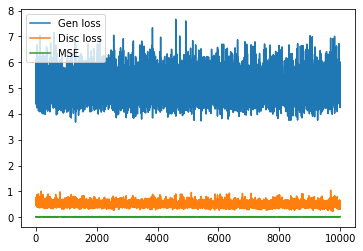

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


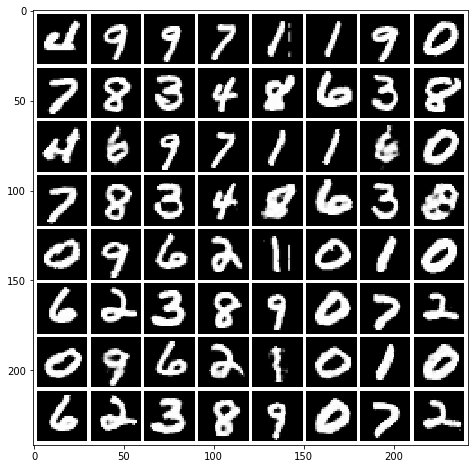

Mean squared dist: 0.024224453
epoch: 46 	 step:0 	 loss: 4.905
epoch: 46 	 step:100 	 loss: 4.975
epoch: 46 	 step:200 	 loss: 5.417
epoch: 46 	 step:300 	 loss: 4.742
epoch: 46 	 step:400 	 loss: 5.003
epoch: 46 	 step:500 	 loss: 4.759
epoch: 46 	 step:600 	 loss: 4.005
epoch: 46 	 step:700 	 loss: 4.807
epoch: 46 	 step:800 	 loss: 5.58
epoch: 46 	 step:900 	 loss: 4.674
epoch: 46 	 step:1000 	 loss: 4.913
epoch: 46 	 step:1100 	 loss: 4.547
epoch: 46 	 step:1200 	 loss: 4.987
epoch: 46 	 step:1300 	 loss: 4.919
epoch: 46 	 step:1400 	 loss: 6.118
epoch: 46 	 step:1500 	 loss: 4.39
epoch: 46 	 step:1600 	 loss: 5.675
epoch: 46 	 step:1700 	 loss: 5.734
epoch: 46 	 step:1800 	 loss: 3.963


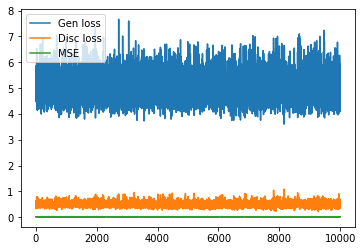

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


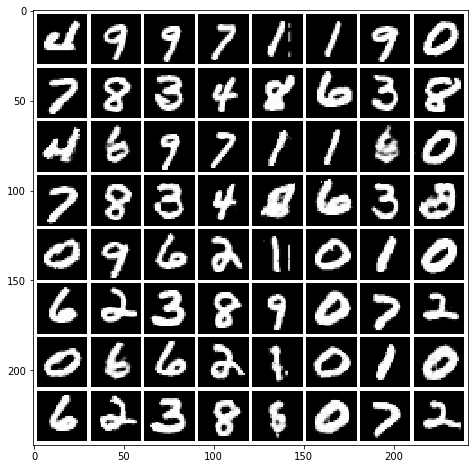

Mean squared dist: 0.024483867
epoch: 47 	 step:0 	 loss: 5.276
epoch: 47 	 step:100 	 loss: 4.94
epoch: 47 	 step:200 	 loss: 4.492
epoch: 47 	 step:300 	 loss: 5.112
epoch: 47 	 step:400 	 loss: 4.933
epoch: 47 	 step:500 	 loss: 5.277
epoch: 47 	 step:600 	 loss: 5.111
epoch: 47 	 step:700 	 loss: 5.558
epoch: 47 	 step:800 	 loss: 4.948
epoch: 47 	 step:900 	 loss: 5.281
epoch: 47 	 step:1000 	 loss: 5.17
epoch: 47 	 step:1100 	 loss: 4.731
epoch: 47 	 step:1200 	 loss: 5.007
epoch: 47 	 step:1300 	 loss: 4.726
epoch: 47 	 step:1400 	 loss: 6.162
epoch: 47 	 step:1500 	 loss: 5.262
epoch: 47 	 step:1600 	 loss: 5.151
epoch: 47 	 step:1700 	 loss: 5.392
epoch: 47 	 step:1800 	 loss: 4.342


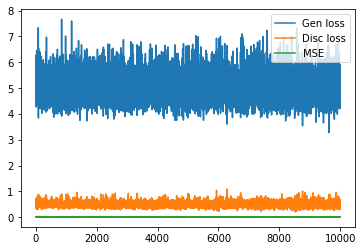

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


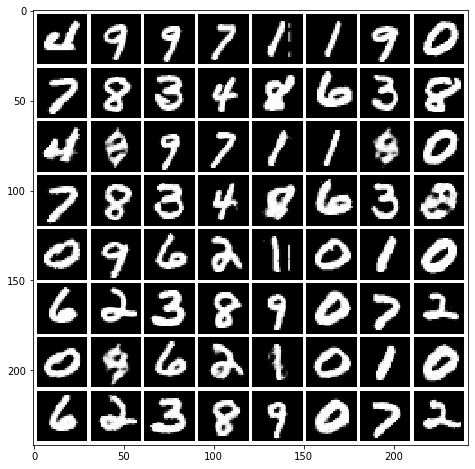

Mean squared dist: 0.024359798
epoch: 48 	 step:0 	 loss: 4.781
epoch: 48 	 step:100 	 loss: 5.01
epoch: 48 	 step:200 	 loss: 4.766
epoch: 48 	 step:300 	 loss: 5.074
epoch: 48 	 step:400 	 loss: 5.262
epoch: 48 	 step:500 	 loss: 5.062
epoch: 48 	 step:600 	 loss: 4.707
epoch: 48 	 step:700 	 loss: 4.831
epoch: 48 	 step:800 	 loss: 5.334
epoch: 48 	 step:900 	 loss: 5.255
epoch: 48 	 step:1000 	 loss: 4.937
epoch: 48 	 step:1100 	 loss: 4.542
epoch: 48 	 step:1200 	 loss: 4.912
epoch: 48 	 step:1300 	 loss: 4.304
epoch: 48 	 step:1400 	 loss: 5.533
epoch: 48 	 step:1500 	 loss: 5.328
epoch: 48 	 step:1600 	 loss: 4.125
epoch: 48 	 step:1700 	 loss: 4.901
epoch: 48 	 step:1800 	 loss: 4.94


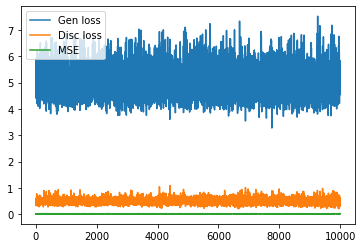

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


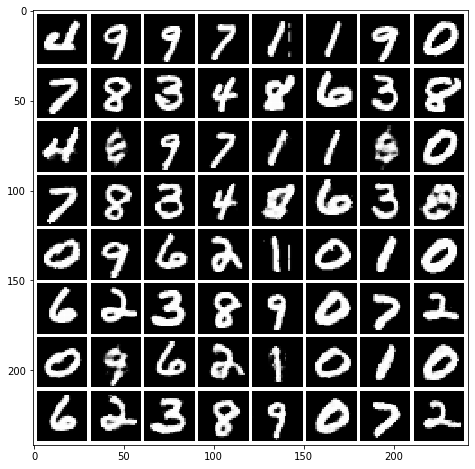

Mean squared dist: 0.02405581
epoch: 49 	 step:0 	 loss: 4.58
epoch: 49 	 step:100 	 loss: 4.32
epoch: 49 	 step:200 	 loss: 5.925
epoch: 49 	 step:300 	 loss: 4.405
epoch: 49 	 step:400 	 loss: 6.1
epoch: 49 	 step:500 	 loss: 4.646
epoch: 49 	 step:600 	 loss: 5.151
epoch: 49 	 step:700 	 loss: 5.088
epoch: 49 	 step:800 	 loss: 5.128
epoch: 49 	 step:900 	 loss: 5.996
epoch: 49 	 step:1000 	 loss: 4.792
epoch: 49 	 step:1100 	 loss: 4.564
epoch: 49 	 step:1200 	 loss: 5.483
epoch: 49 	 step:1300 	 loss: 5.308
epoch: 49 	 step:1400 	 loss: 4.681
epoch: 49 	 step:1500 	 loss: 4.714
epoch: 49 	 step:1600 	 loss: 4.565
epoch: 49 	 step:1700 	 loss: 4.666
epoch: 49 	 step:1800 	 loss: 5.001


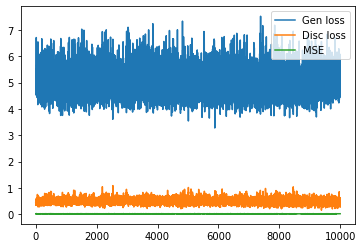

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


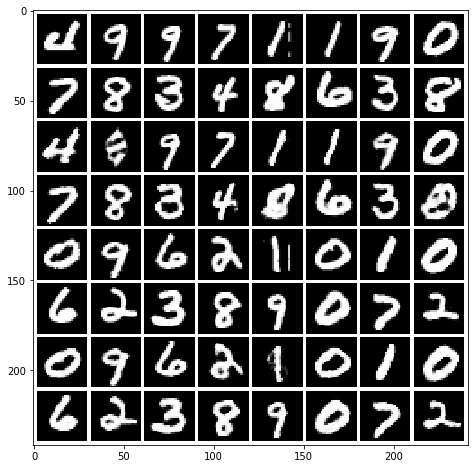

Mean squared dist: 0.024469933
epoch: 50 	 step:0 	 loss: 4.037
epoch: 50 	 step:100 	 loss: 4.969
epoch: 50 	 step:200 	 loss: 4.393
epoch: 50 	 step:300 	 loss: 4.276
epoch: 50 	 step:400 	 loss: 4.718
epoch: 50 	 step:500 	 loss: 4.867
epoch: 50 	 step:600 	 loss: 5.617
epoch: 50 	 step:700 	 loss: 4.724
epoch: 50 	 step:800 	 loss: 4.515
epoch: 50 	 step:900 	 loss: 4.685
epoch: 50 	 step:1000 	 loss: 5.012
epoch: 50 	 step:1100 	 loss: 6.209
epoch: 50 	 step:1200 	 loss: 4.637
epoch: 50 	 step:1300 	 loss: 4.842
epoch: 50 	 step:1400 	 loss: 5.25
epoch: 50 	 step:1500 	 loss: 4.834
epoch: 50 	 step:1600 	 loss: 6.083
epoch: 50 	 step:1700 	 loss: 4.537
epoch: 50 	 step:1800 	 loss: 4.488


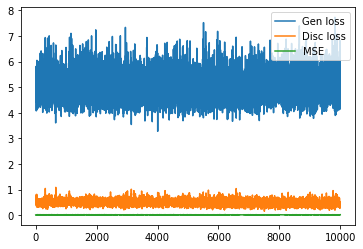

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


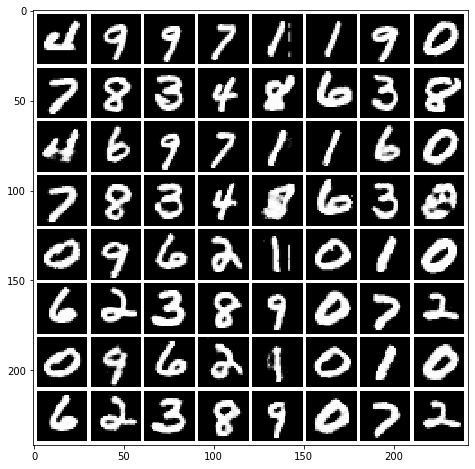

Mean squared dist: 0.023992587
epoch: 51 	 step:0 	 loss: 4.636
epoch: 51 	 step:100 	 loss: 5.212
epoch: 51 	 step:200 	 loss: 4.237
epoch: 51 	 step:300 	 loss: 5.45
epoch: 51 	 step:400 	 loss: 5.535
epoch: 51 	 step:500 	 loss: 5.635
epoch: 51 	 step:600 	 loss: 4.711
epoch: 51 	 step:700 	 loss: 5.23
epoch: 51 	 step:800 	 loss: 4.491
epoch: 51 	 step:900 	 loss: 4.894
epoch: 51 	 step:1000 	 loss: 4.894
epoch: 51 	 step:1100 	 loss: 5.406
epoch: 51 	 step:1200 	 loss: 5.037
epoch: 51 	 step:1300 	 loss: 4.248
epoch: 51 	 step:1400 	 loss: 5.554
epoch: 51 	 step:1500 	 loss: 6.653
epoch: 51 	 step:1600 	 loss: 5.718
epoch: 51 	 step:1700 	 loss: 5.695
epoch: 51 	 step:1800 	 loss: 5.443


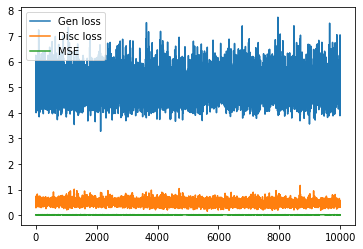

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


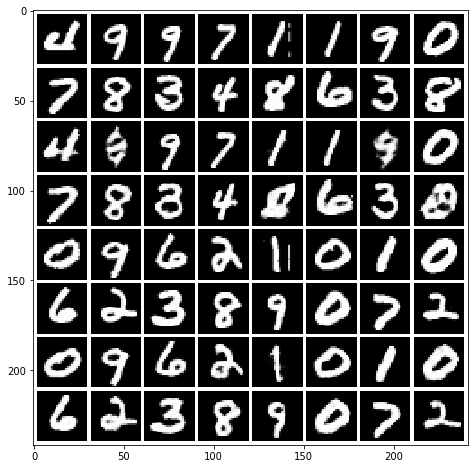

Mean squared dist: 0.024128811
epoch: 52 	 step:0 	 loss: 4.583
epoch: 52 	 step:100 	 loss: 5.846
epoch: 52 	 step:200 	 loss: 5.624
epoch: 52 	 step:300 	 loss: 4.847
epoch: 52 	 step:400 	 loss: 5.613
epoch: 52 	 step:500 	 loss: 5.485
epoch: 52 	 step:600 	 loss: 5.33
epoch: 52 	 step:700 	 loss: 4.842
epoch: 52 	 step:800 	 loss: 5.235
epoch: 52 	 step:900 	 loss: 4.304
epoch: 52 	 step:1000 	 loss: 4.766
epoch: 52 	 step:1100 	 loss: 4.948
epoch: 52 	 step:1200 	 loss: 5.232
epoch: 52 	 step:1300 	 loss: 4.528
epoch: 52 	 step:1400 	 loss: 4.996
epoch: 52 	 step:1500 	 loss: 4.681
epoch: 52 	 step:1600 	 loss: 4.87
epoch: 52 	 step:1700 	 loss: 5.781
epoch: 52 	 step:1800 	 loss: 4.903


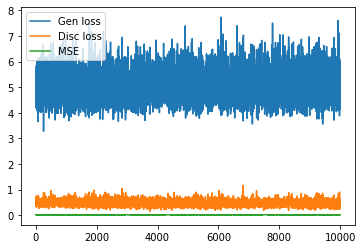

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


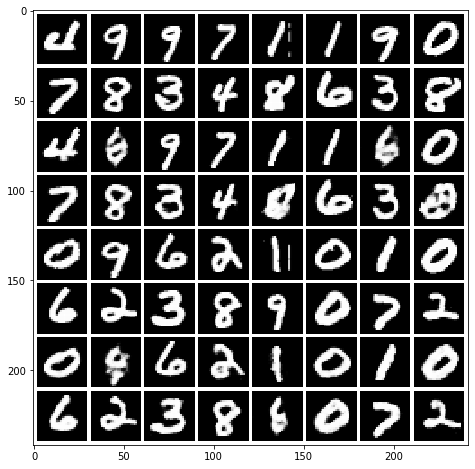

Mean squared dist: 0.024415947
epoch: 53 	 step:0 	 loss: 4.055
epoch: 53 	 step:100 	 loss: 5.006
epoch: 53 	 step:200 	 loss: 6.518
epoch: 53 	 step:300 	 loss: 4.695
epoch: 53 	 step:400 	 loss: 4.948
epoch: 53 	 step:500 	 loss: 5.02
epoch: 53 	 step:600 	 loss: 4.654
epoch: 53 	 step:700 	 loss: 5.101
epoch: 53 	 step:800 	 loss: 4.838
epoch: 53 	 step:900 	 loss: 5.141
epoch: 53 	 step:1000 	 loss: 5.014
epoch: 53 	 step:1100 	 loss: 6.105
epoch: 53 	 step:1200 	 loss: 4.227
epoch: 53 	 step:1300 	 loss: 4.567
epoch: 53 	 step:1400 	 loss: 5.783
epoch: 53 	 step:1500 	 loss: 5.716
epoch: 53 	 step:1600 	 loss: 4.159
epoch: 53 	 step:1700 	 loss: 6.27
epoch: 53 	 step:1800 	 loss: 4.438


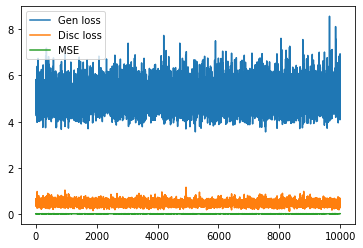

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


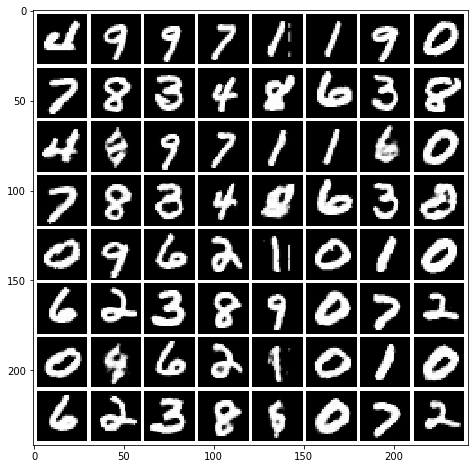

Mean squared dist: 0.02410885
epoch: 54 	 step:0 	 loss: 4.23
epoch: 54 	 step:100 	 loss: 4.597
epoch: 54 	 step:200 	 loss: 4.058
epoch: 54 	 step:300 	 loss: 4.353
epoch: 54 	 step:400 	 loss: 5.684
epoch: 54 	 step:500 	 loss: 4.479
epoch: 54 	 step:600 	 loss: 4.597
epoch: 54 	 step:700 	 loss: 5.865
epoch: 54 	 step:800 	 loss: 5.935
epoch: 54 	 step:900 	 loss: 4.427
epoch: 54 	 step:1000 	 loss: 4.713
epoch: 54 	 step:1100 	 loss: 5.305
epoch: 54 	 step:1200 	 loss: 4.467
epoch: 54 	 step:1300 	 loss: 5.222
epoch: 54 	 step:1400 	 loss: 4.99
epoch: 54 	 step:1500 	 loss: 6.252
epoch: 54 	 step:1600 	 loss: 5.261
epoch: 54 	 step:1700 	 loss: 4.913
epoch: 54 	 step:1800 	 loss: 5.59


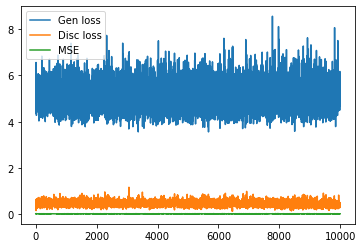

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


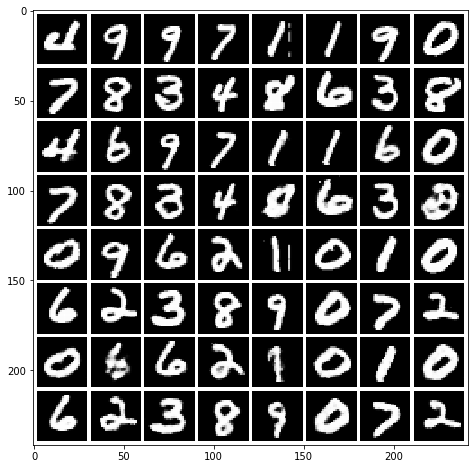

Mean squared dist: 0.024510382
epoch: 55 	 step:0 	 loss: 4.454
epoch: 55 	 step:100 	 loss: 4.321
epoch: 55 	 step:200 	 loss: 5.228
epoch: 55 	 step:300 	 loss: 4.52
epoch: 55 	 step:400 	 loss: 5.539
epoch: 55 	 step:500 	 loss: 4.87
epoch: 55 	 step:600 	 loss: 5.795
epoch: 55 	 step:700 	 loss: 4.861
epoch: 55 	 step:800 	 loss: 6.085
epoch: 55 	 step:900 	 loss: 4.816
epoch: 55 	 step:1000 	 loss: 5.649
epoch: 55 	 step:1100 	 loss: 5.471
epoch: 55 	 step:1200 	 loss: 4.598
epoch: 55 	 step:1300 	 loss: 5.481
epoch: 55 	 step:1400 	 loss: 5.018
epoch: 55 	 step:1500 	 loss: 4.746
epoch: 55 	 step:1600 	 loss: 5.461
epoch: 55 	 step:1700 	 loss: 4.464
epoch: 55 	 step:1800 	 loss: 5.219


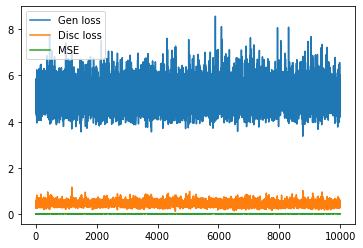

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


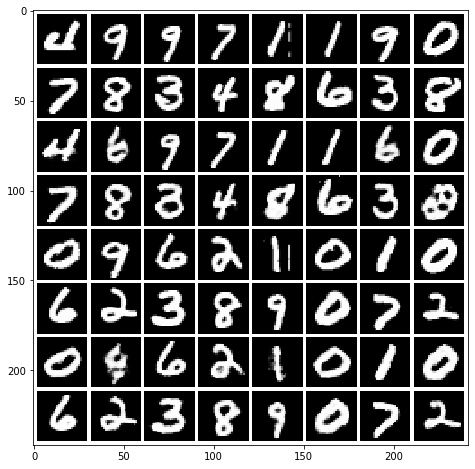

Mean squared dist: 0.023950702
epoch: 56 	 step:0 	 loss: 5.313
epoch: 56 	 step:100 	 loss: 4.28
epoch: 56 	 step:200 	 loss: 4.68
epoch: 56 	 step:300 	 loss: 4.553
epoch: 56 	 step:400 	 loss: 4.273
epoch: 56 	 step:500 	 loss: 4.918
epoch: 56 	 step:600 	 loss: 6.294
epoch: 56 	 step:700 	 loss: 4.785
epoch: 56 	 step:800 	 loss: 5.215
epoch: 56 	 step:900 	 loss: 5.187
epoch: 56 	 step:1000 	 loss: 5.408
epoch: 56 	 step:1100 	 loss: 4.329
epoch: 56 	 step:1200 	 loss: 5.15
epoch: 56 	 step:1300 	 loss: 4.758
epoch: 56 	 step:1400 	 loss: 5.188
epoch: 56 	 step:1500 	 loss: 6.148
epoch: 56 	 step:1600 	 loss: 4.308
epoch: 56 	 step:1700 	 loss: 4.781
epoch: 56 	 step:1800 	 loss: 4.209


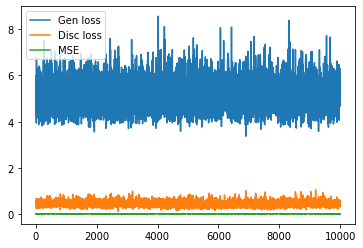

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


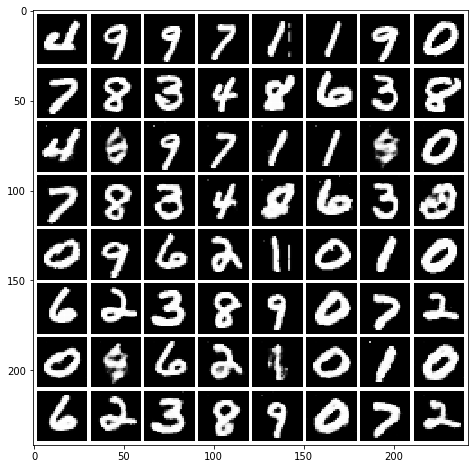

Mean squared dist: 0.024304092
epoch: 57 	 step:0 	 loss: 4.847
epoch: 57 	 step:100 	 loss: 4.81
epoch: 57 	 step:200 	 loss: 5.028
epoch: 57 	 step:300 	 loss: 4.609
epoch: 57 	 step:400 	 loss: 4.783
epoch: 57 	 step:500 	 loss: 5.524
epoch: 57 	 step:600 	 loss: 4.677
epoch: 57 	 step:700 	 loss: 4.224
epoch: 57 	 step:800 	 loss: 5.606
epoch: 57 	 step:900 	 loss: 4.774
epoch: 57 	 step:1000 	 loss: 4.24
epoch: 57 	 step:1100 	 loss: 4.678
epoch: 57 	 step:1200 	 loss: 5.525
epoch: 57 	 step:1300 	 loss: 5.963
epoch: 57 	 step:1400 	 loss: 4.835
epoch: 57 	 step:1500 	 loss: 4.677
epoch: 57 	 step:1600 	 loss: 4.968
epoch: 57 	 step:1700 	 loss: 5.117
epoch: 57 	 step:1800 	 loss: 5.114


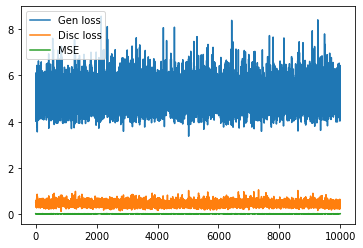

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


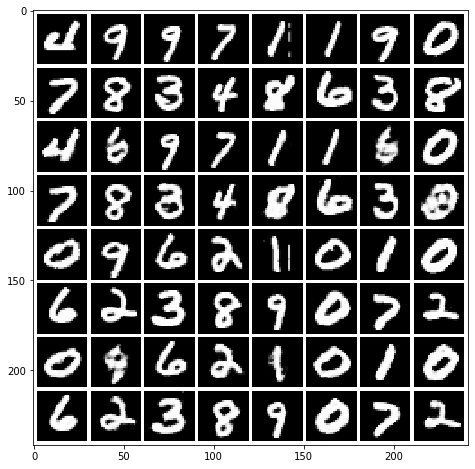

Mean squared dist: 0.02414844
epoch: 58 	 step:0 	 loss: 5.059
epoch: 58 	 step:100 	 loss: 5.053
epoch: 58 	 step:200 	 loss: 6.346
epoch: 58 	 step:300 	 loss: 4.985
epoch: 58 	 step:400 	 loss: 4.758
epoch: 58 	 step:500 	 loss: 6.092
epoch: 58 	 step:600 	 loss: 5.068
epoch: 58 	 step:700 	 loss: 4.984
epoch: 58 	 step:800 	 loss: 5.827
epoch: 58 	 step:900 	 loss: 4.639
epoch: 58 	 step:1000 	 loss: 5.12
epoch: 58 	 step:1100 	 loss: 4.415
epoch: 58 	 step:1200 	 loss: 5.007
epoch: 58 	 step:1300 	 loss: 5.166
epoch: 58 	 step:1400 	 loss: 5.028
epoch: 58 	 step:1500 	 loss: 6.11
epoch: 58 	 step:1600 	 loss: 4.138
epoch: 58 	 step:1700 	 loss: 5.392
epoch: 58 	 step:1800 	 loss: 5.373


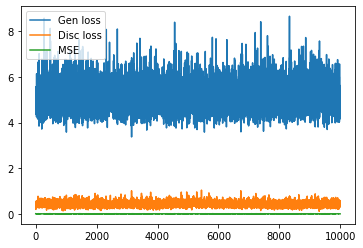

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


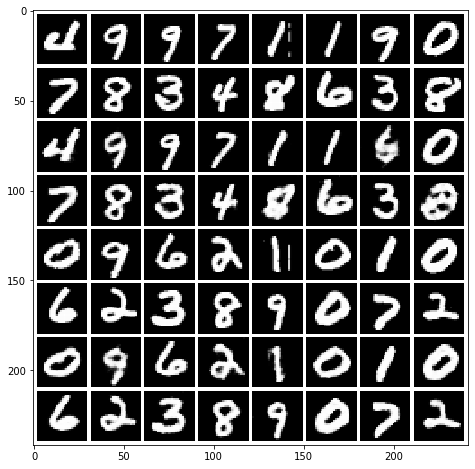

Mean squared dist: 0.023882685
epoch: 59 	 step:0 	 loss: 4.438
epoch: 59 	 step:100 	 loss: 5.988
epoch: 59 	 step:200 	 loss: 5.391
epoch: 59 	 step:300 	 loss: 5.079
epoch: 59 	 step:400 	 loss: 5.518
epoch: 59 	 step:500 	 loss: 4.489
epoch: 59 	 step:600 	 loss: 5.407
epoch: 59 	 step:700 	 loss: 5.473
epoch: 59 	 step:800 	 loss: 4.5
epoch: 59 	 step:900 	 loss: 6.069
epoch: 59 	 step:1000 	 loss: 5.925
epoch: 59 	 step:1100 	 loss: 5.979
epoch: 59 	 step:1200 	 loss: 5.25
epoch: 59 	 step:1300 	 loss: 5.567
epoch: 59 	 step:1400 	 loss: 6.832
epoch: 59 	 step:1500 	 loss: 4.207
epoch: 59 	 step:1600 	 loss: 6.269
epoch: 59 	 step:1700 	 loss: 5.8
epoch: 59 	 step:1800 	 loss: 5.04


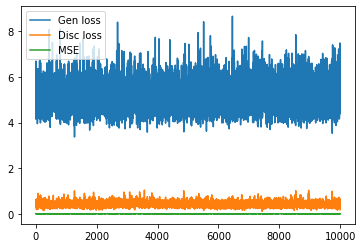

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


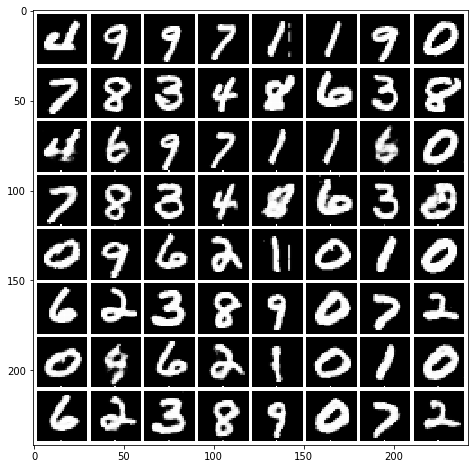

Mean squared dist: 0.02486141
epoch: 60 	 step:0 	 loss: 4.803
epoch: 60 	 step:100 	 loss: 4.906
epoch: 60 	 step:200 	 loss: 4.548
epoch: 60 	 step:300 	 loss: 4.99
epoch: 60 	 step:400 	 loss: 4.941
epoch: 60 	 step:500 	 loss: 4.739
epoch: 60 	 step:600 	 loss: 6.449
epoch: 60 	 step:700 	 loss: 4.534
epoch: 60 	 step:800 	 loss: 5.178
epoch: 60 	 step:900 	 loss: 4.698
epoch: 60 	 step:1000 	 loss: 5.263
epoch: 60 	 step:1100 	 loss: 5.334
epoch: 60 	 step:1200 	 loss: 4.539
epoch: 60 	 step:1300 	 loss: 4.956
epoch: 60 	 step:1400 	 loss: 5.116
epoch: 60 	 step:1500 	 loss: 5.463
epoch: 60 	 step:1600 	 loss: 4.615
epoch: 60 	 step:1700 	 loss: 5.029
epoch: 60 	 step:1800 	 loss: 5.071


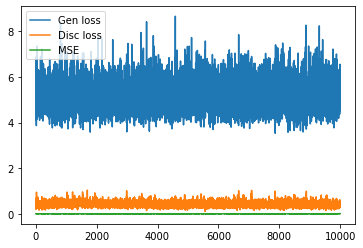

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


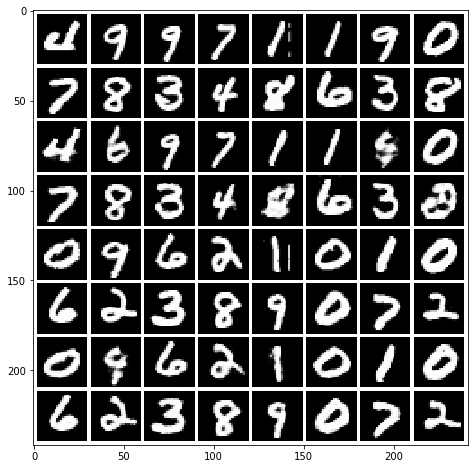

Mean squared dist: 0.023719715
epoch: 61 	 step:0 	 loss: 5.377
epoch: 61 	 step:100 	 loss: 5.225
epoch: 61 	 step:200 	 loss: 4.256
epoch: 61 	 step:300 	 loss: 5.192
epoch: 61 	 step:400 	 loss: 6.071
epoch: 61 	 step:500 	 loss: 5.206
epoch: 61 	 step:600 	 loss: 4.814
epoch: 61 	 step:700 	 loss: 4.15
epoch: 61 	 step:800 	 loss: 4.802
epoch: 61 	 step:900 	 loss: 5.712
epoch: 61 	 step:1000 	 loss: 5.857
epoch: 61 	 step:1100 	 loss: 3.927
epoch: 61 	 step:1200 	 loss: 4.772
epoch: 61 	 step:1300 	 loss: 6.403
epoch: 61 	 step:1400 	 loss: 4.731
epoch: 61 	 step:1500 	 loss: 4.158
epoch: 61 	 step:1600 	 loss: 4.431
epoch: 61 	 step:1700 	 loss: 4.273
epoch: 61 	 step:1800 	 loss: 5.024


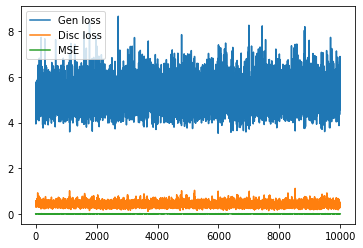

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


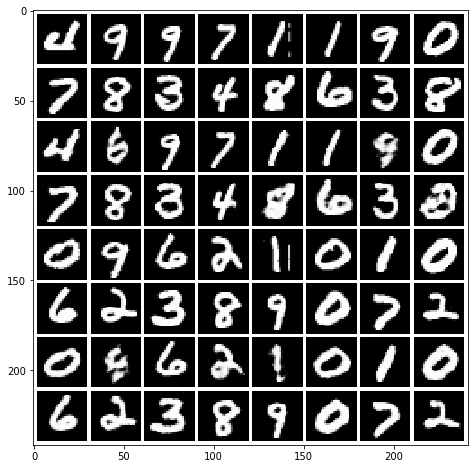

Mean squared dist: 0.02368543
epoch: 62 	 step:0 	 loss: 4.841
epoch: 62 	 step:100 	 loss: 4.655
epoch: 62 	 step:200 	 loss: 4.802
epoch: 62 	 step:300 	 loss: 4.465
epoch: 62 	 step:400 	 loss: 5.267
epoch: 62 	 step:500 	 loss: 5.434
epoch: 62 	 step:600 	 loss: 4.449
epoch: 62 	 step:700 	 loss: 4.418
epoch: 62 	 step:800 	 loss: 4.845
epoch: 62 	 step:900 	 loss: 5.664
epoch: 62 	 step:1000 	 loss: 4.281
epoch: 62 	 step:1100 	 loss: 4.695
epoch: 62 	 step:1200 	 loss: 5.034
epoch: 62 	 step:1300 	 loss: 5.423
epoch: 62 	 step:1400 	 loss: 6.282
epoch: 62 	 step:1500 	 loss: 6.083
epoch: 62 	 step:1600 	 loss: 4.78
epoch: 62 	 step:1700 	 loss: 5.67
epoch: 62 	 step:1800 	 loss: 5.911


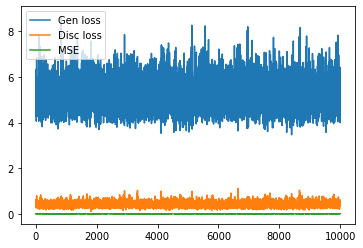

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


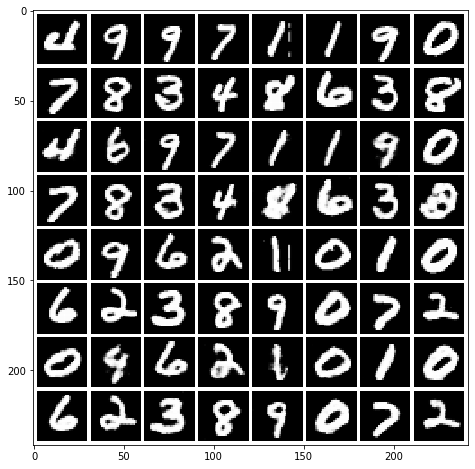

Mean squared dist: 0.024224842
epoch: 63 	 step:0 	 loss: 4.935
epoch: 63 	 step:100 	 loss: 4.392
epoch: 63 	 step:200 	 loss: 6.764
epoch: 63 	 step:300 	 loss: 4.378
epoch: 63 	 step:400 	 loss: 6.655
epoch: 63 	 step:500 	 loss: 5.53
epoch: 63 	 step:600 	 loss: 5.204
epoch: 63 	 step:700 	 loss: 5.043
epoch: 63 	 step:800 	 loss: 5.34
epoch: 63 	 step:900 	 loss: 4.536
epoch: 63 	 step:1000 	 loss: 5.198
epoch: 63 	 step:1100 	 loss: 4.486
epoch: 63 	 step:1200 	 loss: 5.662
epoch: 63 	 step:1300 	 loss: 6.881
epoch: 63 	 step:1400 	 loss: 4.955
epoch: 63 	 step:1500 	 loss: 5.235
epoch: 63 	 step:1600 	 loss: 5.881
epoch: 63 	 step:1700 	 loss: 5.658
epoch: 63 	 step:1800 	 loss: 6.107


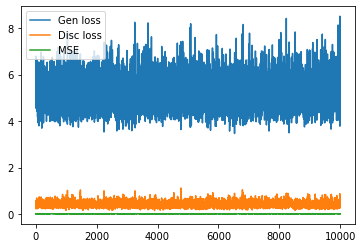

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


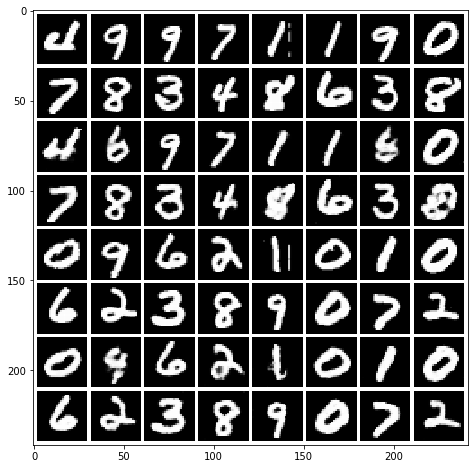

Mean squared dist: 0.02372736
epoch: 64 	 step:0 	 loss: 4.639
epoch: 64 	 step:100 	 loss: 5.982
epoch: 64 	 step:200 	 loss: 6.212
epoch: 64 	 step:300 	 loss: 4.768
epoch: 64 	 step:400 	 loss: 3.867
epoch: 64 	 step:500 	 loss: 5.274
epoch: 64 	 step:600 	 loss: 4.256
epoch: 64 	 step:700 	 loss: 6.239
epoch: 64 	 step:800 	 loss: 4.247
epoch: 64 	 step:900 	 loss: 5.702
epoch: 64 	 step:1000 	 loss: 5.178
epoch: 64 	 step:1100 	 loss: 5.461
epoch: 64 	 step:1200 	 loss: 4.88
epoch: 64 	 step:1300 	 loss: 4.731
epoch: 64 	 step:1400 	 loss: 5.21
epoch: 64 	 step:1500 	 loss: 7.418
epoch: 64 	 step:1600 	 loss: 4.892
epoch: 64 	 step:1700 	 loss: 4.993
epoch: 64 	 step:1800 	 loss: 5.017


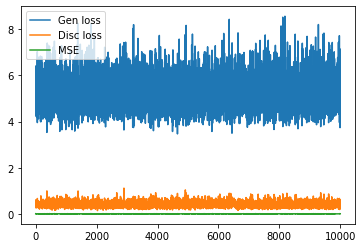

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


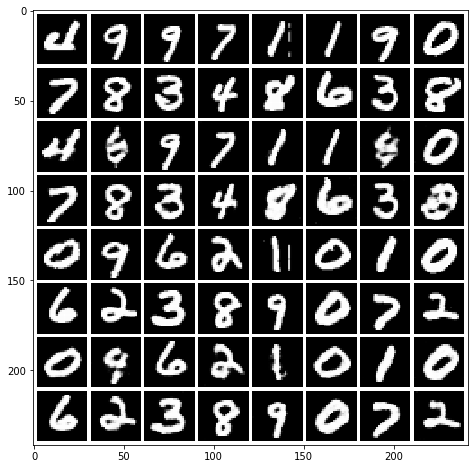

Mean squared dist: 0.023946358
epoch: 65 	 step:0 	 loss: 5.065
epoch: 65 	 step:100 	 loss: 5.867
epoch: 65 	 step:200 	 loss: 6.669
epoch: 65 	 step:300 	 loss: 4.71
epoch: 65 	 step:400 	 loss: 5.921
epoch: 65 	 step:500 	 loss: 4.577
epoch: 65 	 step:600 	 loss: 5.866
epoch: 65 	 step:700 	 loss: 4.867
epoch: 65 	 step:800 	 loss: 4.834
epoch: 65 	 step:900 	 loss: 5.842
epoch: 65 	 step:1000 	 loss: 6.085
epoch: 65 	 step:1100 	 loss: 6.765
epoch: 65 	 step:1200 	 loss: 4.327
epoch: 65 	 step:1300 	 loss: 7.727
epoch: 65 	 step:1400 	 loss: 5.874
epoch: 65 	 step:1500 	 loss: 4.396
epoch: 65 	 step:1600 	 loss: 5.973
epoch: 65 	 step:1700 	 loss: 4.775
epoch: 65 	 step:1800 	 loss: 4.992


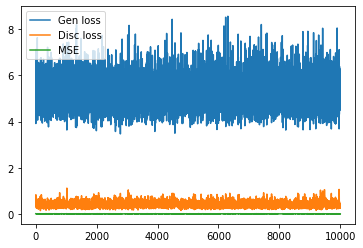

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


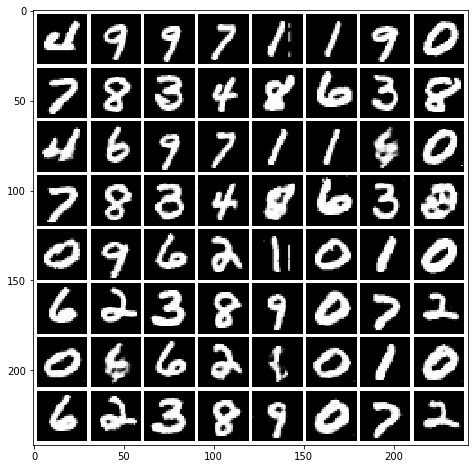

Mean squared dist: 0.02454384
epoch: 66 	 step:0 	 loss: 5.827
epoch: 66 	 step:100 	 loss: 4.727
epoch: 66 	 step:200 	 loss: 5.207
epoch: 66 	 step:300 	 loss: 4.684
epoch: 66 	 step:400 	 loss: 4.085
epoch: 66 	 step:500 	 loss: 5.257
epoch: 66 	 step:600 	 loss: 4.939
epoch: 66 	 step:700 	 loss: 4.75
epoch: 66 	 step:800 	 loss: 5.708
epoch: 66 	 step:900 	 loss: 4.325
epoch: 66 	 step:1000 	 loss: 4.711
epoch: 66 	 step:1100 	 loss: 5.689
epoch: 66 	 step:1200 	 loss: 4.528
epoch: 66 	 step:1300 	 loss: 4.724
epoch: 66 	 step:1400 	 loss: 7.104
epoch: 66 	 step:1500 	 loss: 4.872
epoch: 66 	 step:1600 	 loss: 4.592
epoch: 66 	 step:1700 	 loss: 4.911
epoch: 66 	 step:1800 	 loss: 5.358


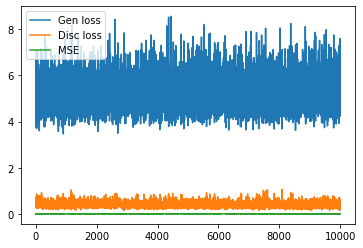

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


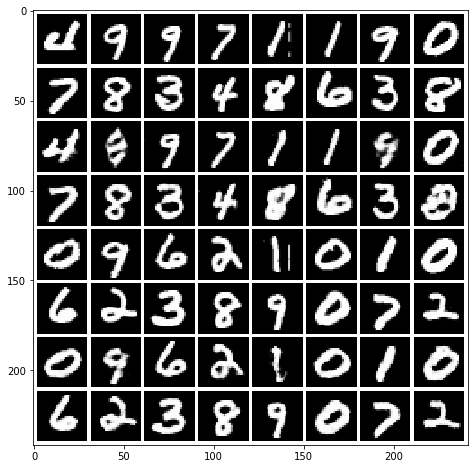

Mean squared dist: 0.02398853
epoch: 67 	 step:0 	 loss: 5.013
epoch: 67 	 step:100 	 loss: 4.802
epoch: 67 	 step:200 	 loss: 5.398
epoch: 67 	 step:300 	 loss: 6.516
epoch: 67 	 step:400 	 loss: 4.491
epoch: 67 	 step:500 	 loss: 4.147
epoch: 67 	 step:600 	 loss: 5.055
epoch: 67 	 step:700 	 loss: 4.787
epoch: 67 	 step:800 	 loss: 5.182
epoch: 67 	 step:900 	 loss: 5.65
epoch: 67 	 step:1000 	 loss: 5.298
epoch: 67 	 step:1100 	 loss: 5.252
epoch: 67 	 step:1200 	 loss: 4.702
epoch: 67 	 step:1300 	 loss: 4.783
epoch: 67 	 step:1400 	 loss: 4.633
epoch: 67 	 step:1500 	 loss: 4.562
epoch: 67 	 step:1600 	 loss: 4.831
epoch: 67 	 step:1700 	 loss: 5.275
epoch: 67 	 step:1800 	 loss: 5.304


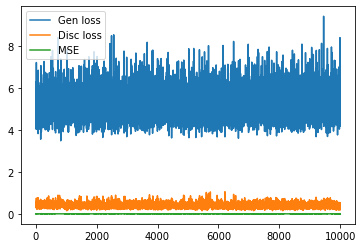

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


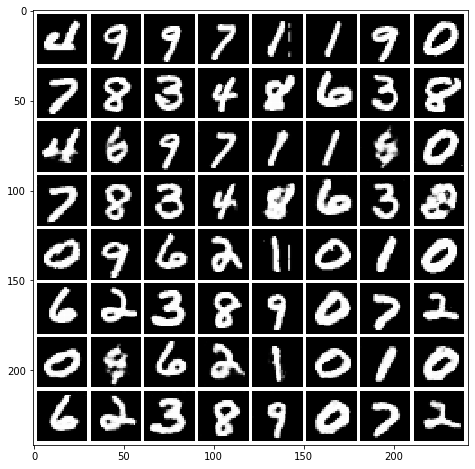

Mean squared dist: 0.023818702
epoch: 68 	 step:0 	 loss: 5.135
epoch: 68 	 step:100 	 loss: 5.773
epoch: 68 	 step:200 	 loss: 4.746
epoch: 68 	 step:300 	 loss: 5.743
epoch: 68 	 step:400 	 loss: 5.28
epoch: 68 	 step:500 	 loss: 6.54
epoch: 68 	 step:600 	 loss: 4.711
epoch: 68 	 step:700 	 loss: 6.089
epoch: 68 	 step:800 	 loss: 5.668
epoch: 68 	 step:900 	 loss: 4.651
epoch: 68 	 step:1000 	 loss: 4.932
epoch: 68 	 step:1100 	 loss: 5.315
epoch: 68 	 step:1200 	 loss: 5.335
epoch: 68 	 step:1300 	 loss: 6.513
epoch: 68 	 step:1400 	 loss: 4.712
epoch: 68 	 step:1500 	 loss: 5.43
epoch: 68 	 step:1600 	 loss: 6.191
epoch: 68 	 step:1700 	 loss: 5.353
epoch: 68 	 step:1800 	 loss: 3.987


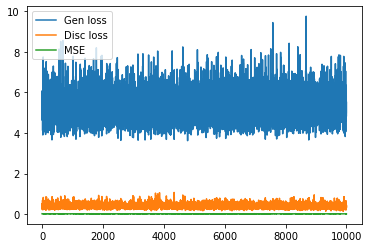

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


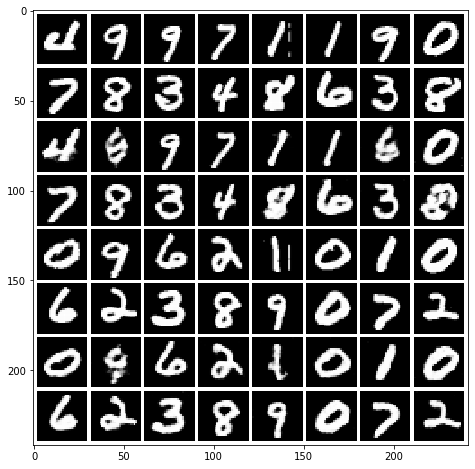

Mean squared dist: 0.023800971
epoch: 69 	 step:0 	 loss: 4.672
epoch: 69 	 step:100 	 loss: 5.161
epoch: 69 	 step:200 	 loss: 5.143
epoch: 69 	 step:300 	 loss: 5.334
epoch: 69 	 step:400 	 loss: 5.159
epoch: 69 	 step:500 	 loss: 4.386
epoch: 69 	 step:600 	 loss: 6.213
epoch: 69 	 step:700 	 loss: 6.473
epoch: 69 	 step:800 	 loss: 5.961
epoch: 69 	 step:900 	 loss: 5.771
epoch: 69 	 step:1000 	 loss: 6.401
epoch: 69 	 step:1100 	 loss: 5.675
epoch: 69 	 step:1200 	 loss: 5.146
epoch: 69 	 step:1300 	 loss: 6.856
epoch: 69 	 step:1400 	 loss: 4.167
epoch: 69 	 step:1500 	 loss: 5.555
epoch: 69 	 step:1600 	 loss: 5.209
epoch: 69 	 step:1700 	 loss: 5.011
epoch: 69 	 step:1800 	 loss: 5.563


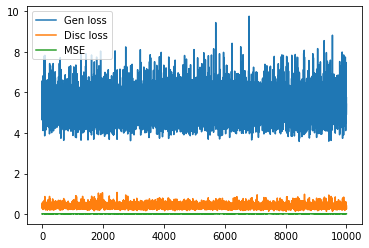

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


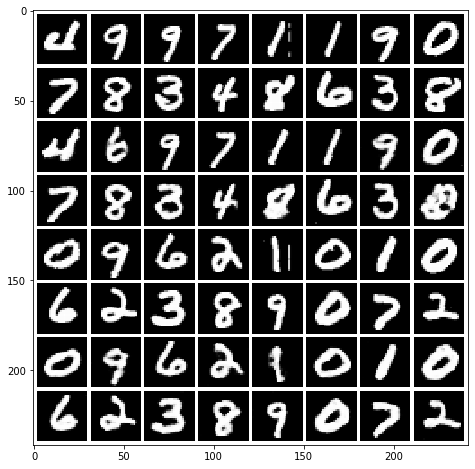

Mean squared dist: 0.023856109
epoch: 70 	 step:0 	 loss: 4.797
epoch: 70 	 step:100 	 loss: 6.023
epoch: 70 	 step:200 	 loss: 6.035
epoch: 70 	 step:300 	 loss: 5.213
epoch: 70 	 step:400 	 loss: 4.742
epoch: 70 	 step:500 	 loss: 4.847
epoch: 70 	 step:600 	 loss: 6.072
epoch: 70 	 step:700 	 loss: 5.248
epoch: 70 	 step:800 	 loss: 6.138
epoch: 70 	 step:900 	 loss: 4.475
epoch: 70 	 step:1000 	 loss: 7.841
epoch: 70 	 step:1100 	 loss: 4.326
epoch: 70 	 step:1200 	 loss: 5.305
epoch: 70 	 step:1300 	 loss: 5.256
epoch: 70 	 step:1400 	 loss: 5.232
epoch: 70 	 step:1500 	 loss: 5.162
epoch: 70 	 step:1600 	 loss: 5.225
epoch: 70 	 step:1700 	 loss: 5.422
epoch: 70 	 step:1800 	 loss: 5.455


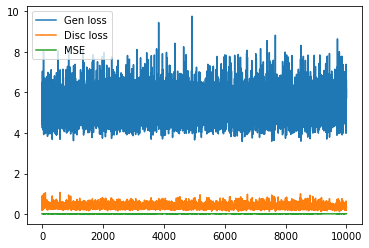

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


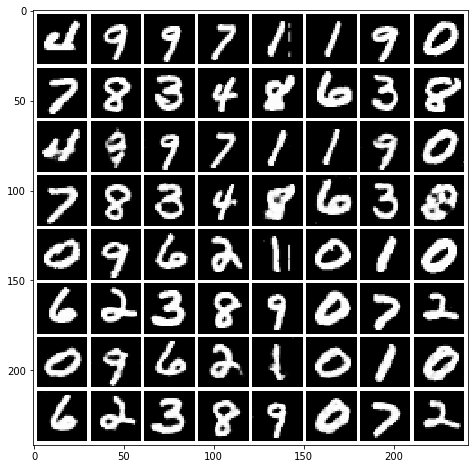

Mean squared dist: 0.023834951
epoch: 71 	 step:0 	 loss: 4.865
epoch: 71 	 step:100 	 loss: 6.534
epoch: 71 	 step:200 	 loss: 5.147
epoch: 71 	 step:300 	 loss: 5.506
epoch: 71 	 step:400 	 loss: 5.476
epoch: 71 	 step:500 	 loss: 5.554
epoch: 71 	 step:600 	 loss: 5.034
epoch: 71 	 step:700 	 loss: 7.232
epoch: 71 	 step:800 	 loss: 5.132
epoch: 71 	 step:900 	 loss: 5.148
epoch: 71 	 step:1000 	 loss: 6.0
epoch: 71 	 step:1100 	 loss: 5.292
epoch: 71 	 step:1200 	 loss: 6.073
epoch: 71 	 step:1300 	 loss: 6.173
epoch: 71 	 step:1400 	 loss: 4.878
epoch: 71 	 step:1500 	 loss: 5.946
epoch: 71 	 step:1600 	 loss: 4.798
epoch: 71 	 step:1700 	 loss: 4.129
epoch: 71 	 step:1800 	 loss: 5.609


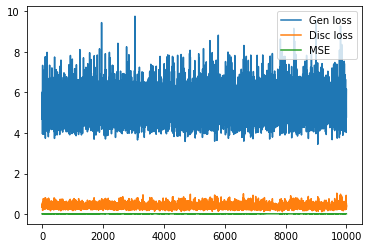

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


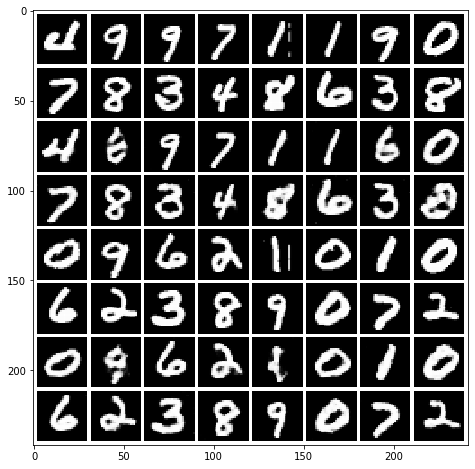

Mean squared dist: 0.023741398
epoch: 72 	 step:0 	 loss: 4.638
epoch: 72 	 step:100 	 loss: 5.336
epoch: 72 	 step:200 	 loss: 4.221
epoch: 72 	 step:300 	 loss: 4.55
epoch: 72 	 step:400 	 loss: 5.115
epoch: 72 	 step:500 	 loss: 5.144
epoch: 72 	 step:600 	 loss: 6.163
epoch: 72 	 step:700 	 loss: 5.539
epoch: 72 	 step:800 	 loss: 4.206
epoch: 72 	 step:900 	 loss: 5.711
epoch: 72 	 step:1000 	 loss: 6.09
epoch: 72 	 step:1100 	 loss: 5.483
epoch: 72 	 step:1200 	 loss: 5.3
epoch: 72 	 step:1300 	 loss: 6.786
epoch: 72 	 step:1400 	 loss: 4.689
epoch: 72 	 step:1500 	 loss: 5.578
epoch: 72 	 step:1600 	 loss: 4.389
epoch: 72 	 step:1700 	 loss: 5.677
epoch: 72 	 step:1800 	 loss: 6.321


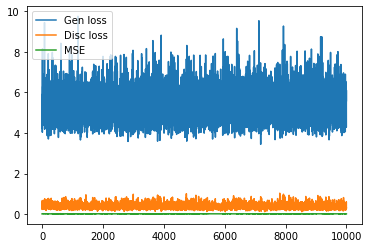

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


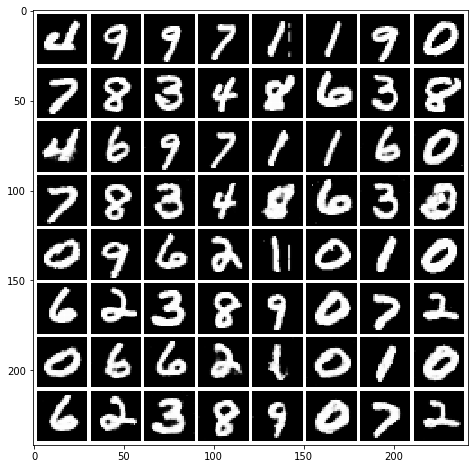

Mean squared dist: 0.023987254
epoch: 73 	 step:0 	 loss: 5.437
epoch: 73 	 step:100 	 loss: 5.789
epoch: 73 	 step:200 	 loss: 5.156
epoch: 73 	 step:300 	 loss: 4.726
epoch: 73 	 step:400 	 loss: 6.801
epoch: 73 	 step:500 	 loss: 4.131
epoch: 73 	 step:600 	 loss: 5.468
epoch: 73 	 step:700 	 loss: 7.11
epoch: 73 	 step:800 	 loss: 6.995
epoch: 73 	 step:900 	 loss: 5.245
epoch: 73 	 step:1000 	 loss: 5.471
epoch: 73 	 step:1100 	 loss: 6.949
epoch: 73 	 step:1200 	 loss: 5.038
epoch: 73 	 step:1300 	 loss: 6.158
epoch: 73 	 step:1400 	 loss: 5.237
epoch: 73 	 step:1500 	 loss: 6.105
epoch: 73 	 step:1600 	 loss: 5.505
epoch: 73 	 step:1700 	 loss: 4.824
epoch: 73 	 step:1800 	 loss: 5.368


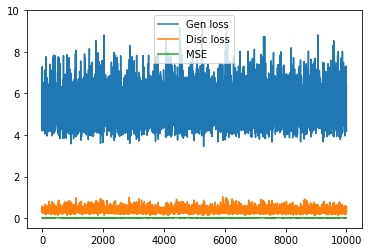

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


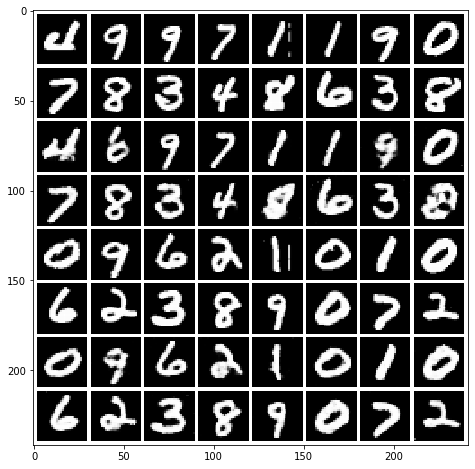

Mean squared dist: 0.023714243
epoch: 74 	 step:0 	 loss: 5.874
epoch: 74 	 step:100 	 loss: 4.541
epoch: 74 	 step:200 	 loss: 5.831
epoch: 74 	 step:300 	 loss: 5.583
epoch: 74 	 step:400 	 loss: 6.113
epoch: 74 	 step:500 	 loss: 5.46
epoch: 74 	 step:600 	 loss: 5.763
epoch: 74 	 step:700 	 loss: 4.966
epoch: 74 	 step:800 	 loss: 4.937
epoch: 74 	 step:900 	 loss: 6.491
epoch: 74 	 step:1000 	 loss: 4.066
epoch: 74 	 step:1100 	 loss: 5.197
epoch: 74 	 step:1200 	 loss: 5.659
epoch: 74 	 step:1300 	 loss: 4.808
epoch: 74 	 step:1400 	 loss: 5.081
epoch: 74 	 step:1500 	 loss: 6.182
epoch: 74 	 step:1600 	 loss: 5.022
epoch: 74 	 step:1700 	 loss: 5.457
epoch: 74 	 step:1800 	 loss: 5.163


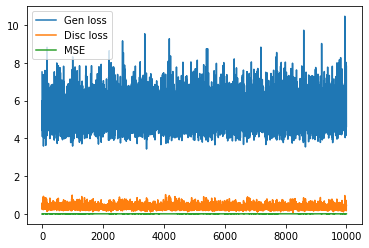

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


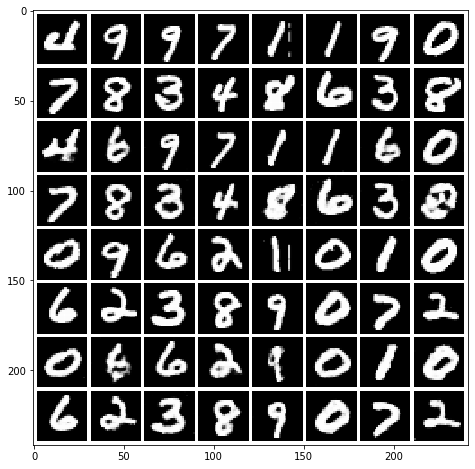

Mean squared dist: 0.023898931
epoch: 75 	 step:0 	 loss: 5.559
epoch: 75 	 step:100 	 loss: 5.042
epoch: 75 	 step:200 	 loss: 5.4
epoch: 75 	 step:300 	 loss: 4.185
epoch: 75 	 step:400 	 loss: 4.854
epoch: 75 	 step:500 	 loss: 5.169
epoch: 75 	 step:600 	 loss: 5.389
epoch: 75 	 step:700 	 loss: 5.4
epoch: 75 	 step:800 	 loss: 5.609
epoch: 75 	 step:900 	 loss: 4.524
epoch: 75 	 step:1000 	 loss: 7.402
epoch: 75 	 step:1100 	 loss: 4.934
epoch: 75 	 step:1200 	 loss: 5.522
epoch: 75 	 step:1300 	 loss: 6.214
epoch: 75 	 step:1400 	 loss: 5.202
epoch: 75 	 step:1500 	 loss: 5.984
epoch: 75 	 step:1600 	 loss: 5.463
epoch: 75 	 step:1700 	 loss: 8.757
epoch: 75 	 step:1800 	 loss: 5.203


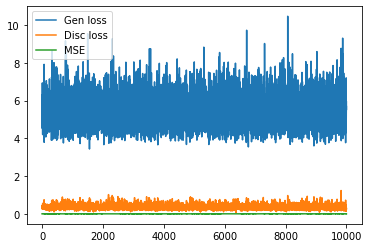

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


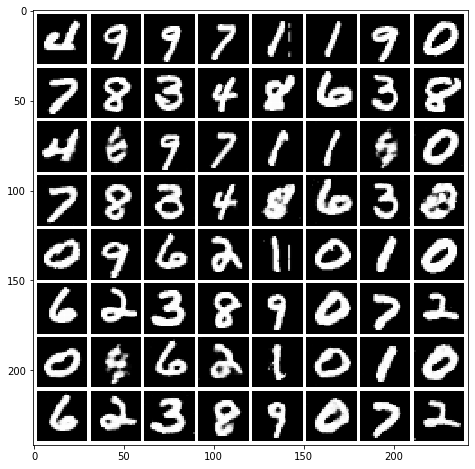

Mean squared dist: 0.02354238
epoch: 76 	 step:0 	 loss: 4.34
epoch: 76 	 step:100 	 loss: 4.644
epoch: 76 	 step:200 	 loss: 4.53
epoch: 76 	 step:300 	 loss: 4.61
epoch: 76 	 step:400 	 loss: 5.447
epoch: 76 	 step:500 	 loss: 4.805
epoch: 76 	 step:600 	 loss: 3.888
epoch: 76 	 step:700 	 loss: 4.734
epoch: 76 	 step:800 	 loss: 5.101
epoch: 76 	 step:900 	 loss: 6.771
epoch: 76 	 step:1000 	 loss: 7.605
epoch: 76 	 step:1100 	 loss: 4.832
epoch: 76 	 step:1200 	 loss: 5.97
epoch: 76 	 step:1300 	 loss: 5.745
epoch: 76 	 step:1400 	 loss: 5.279
epoch: 76 	 step:1500 	 loss: 4.837
epoch: 76 	 step:1600 	 loss: 4.928
epoch: 76 	 step:1700 	 loss: 5.323
epoch: 76 	 step:1800 	 loss: 5.014


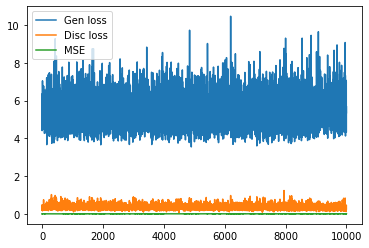

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


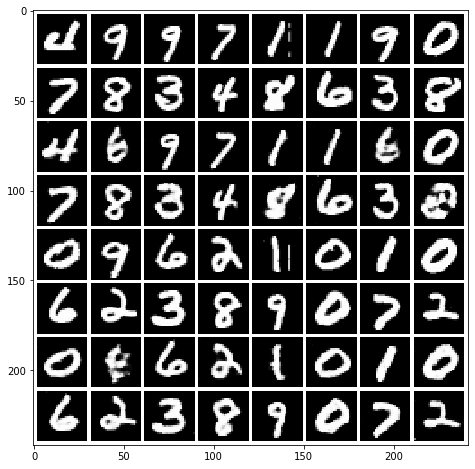

Mean squared dist: 0.023715215
epoch: 77 	 step:0 	 loss: 5.209
epoch: 77 	 step:100 	 loss: 5.548
epoch: 77 	 step:200 	 loss: 4.772
epoch: 77 	 step:300 	 loss: 5.479
epoch: 77 	 step:400 	 loss: 4.899
epoch: 77 	 step:500 	 loss: 7.561
epoch: 77 	 step:600 	 loss: 6.108
epoch: 77 	 step:700 	 loss: 4.543
epoch: 77 	 step:800 	 loss: 6.541
epoch: 77 	 step:900 	 loss: 4.867
epoch: 77 	 step:1000 	 loss: 5.674
epoch: 77 	 step:1100 	 loss: 6.12
epoch: 77 	 step:1200 	 loss: 4.446
epoch: 77 	 step:1300 	 loss: 5.113
epoch: 77 	 step:1400 	 loss: 6.066
epoch: 77 	 step:1500 	 loss: 5.742
epoch: 77 	 step:1600 	 loss: 5.659
epoch: 77 	 step:1700 	 loss: 5.761
epoch: 77 	 step:1800 	 loss: 4.982


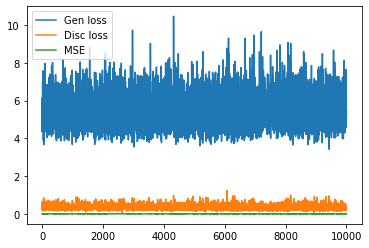

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


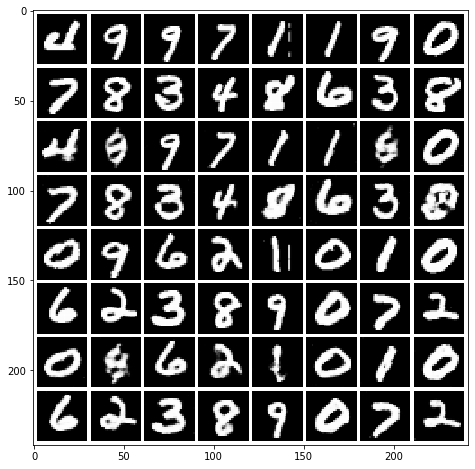

Mean squared dist: 0.023794793
epoch: 78 	 step:0 	 loss: 4.791
epoch: 78 	 step:100 	 loss: 5.405
epoch: 78 	 step:200 	 loss: 3.838
epoch: 78 	 step:300 	 loss: 4.839
epoch: 78 	 step:400 	 loss: 6.893
epoch: 78 	 step:500 	 loss: 4.806
epoch: 78 	 step:600 	 loss: 6.703
epoch: 78 	 step:700 	 loss: 5.169
epoch: 78 	 step:800 	 loss: 4.399
epoch: 78 	 step:900 	 loss: 4.143
epoch: 78 	 step:1000 	 loss: 4.854
epoch: 78 	 step:1100 	 loss: 5.282
epoch: 78 	 step:1200 	 loss: 5.316
epoch: 78 	 step:1300 	 loss: 6.423
epoch: 78 	 step:1400 	 loss: 6.002
epoch: 78 	 step:1500 	 loss: 4.595
epoch: 78 	 step:1600 	 loss: 5.887
epoch: 78 	 step:1700 	 loss: 5.497
epoch: 78 	 step:1800 	 loss: 6.246


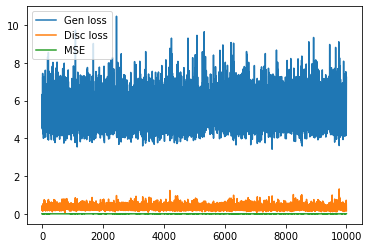

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


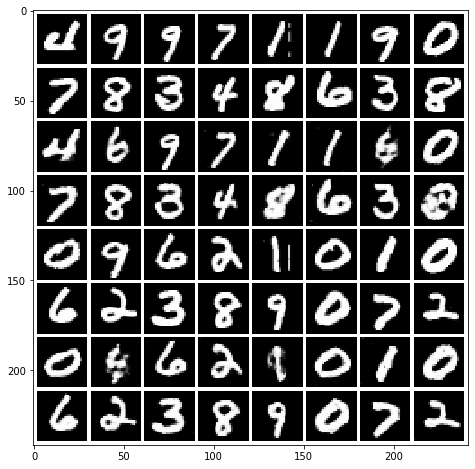

Mean squared dist: 0.02368856
epoch: 79 	 step:0 	 loss: 7.767
epoch: 79 	 step:100 	 loss: 5.118
epoch: 79 	 step:200 	 loss: 5.369
epoch: 79 	 step:300 	 loss: 6.619
epoch: 79 	 step:400 	 loss: 6.479
epoch: 79 	 step:500 	 loss: 5.71
epoch: 79 	 step:600 	 loss: 6.86
epoch: 79 	 step:700 	 loss: 6.06
epoch: 79 	 step:800 	 loss: 6.641
epoch: 79 	 step:900 	 loss: 4.862
epoch: 79 	 step:1000 	 loss: 6.12
epoch: 79 	 step:1100 	 loss: 5.364
epoch: 79 	 step:1200 	 loss: 5.381
epoch: 79 	 step:1300 	 loss: 4.369
epoch: 79 	 step:1400 	 loss: 6.894
epoch: 79 	 step:1500 	 loss: 6.034
epoch: 79 	 step:1600 	 loss: 5.228
epoch: 79 	 step:1700 	 loss: 6.8
epoch: 79 	 step:1800 	 loss: 6.362


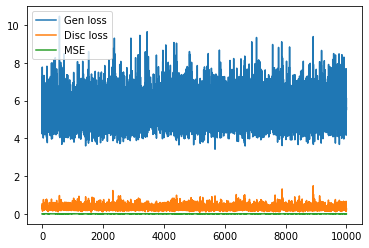

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


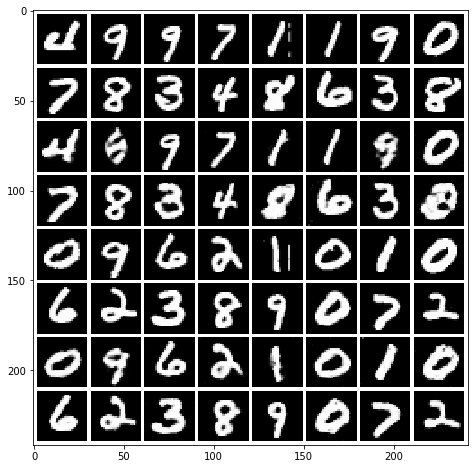

Mean squared dist: 0.023465095
epoch: 80 	 step:0 	 loss: 4.887
epoch: 80 	 step:100 	 loss: 5.761
epoch: 80 	 step:200 	 loss: 5.013
epoch: 80 	 step:300 	 loss: 5.258
epoch: 80 	 step:400 	 loss: 4.406
epoch: 80 	 step:500 	 loss: 5.593
epoch: 80 	 step:600 	 loss: 5.89
epoch: 80 	 step:700 	 loss: 5.578
epoch: 80 	 step:800 	 loss: 5.46
epoch: 80 	 step:900 	 loss: 4.39
epoch: 80 	 step:1000 	 loss: 5.476
epoch: 80 	 step:1100 	 loss: 4.821
epoch: 80 	 step:1200 	 loss: 4.757
epoch: 80 	 step:1300 	 loss: 4.167
epoch: 80 	 step:1400 	 loss: 4.977
epoch: 80 	 step:1500 	 loss: 5.271
epoch: 80 	 step:1600 	 loss: 5.784
epoch: 80 	 step:1700 	 loss: 5.83
epoch: 80 	 step:1800 	 loss: 6.389


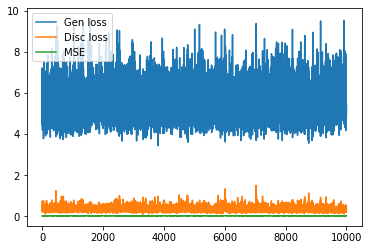

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


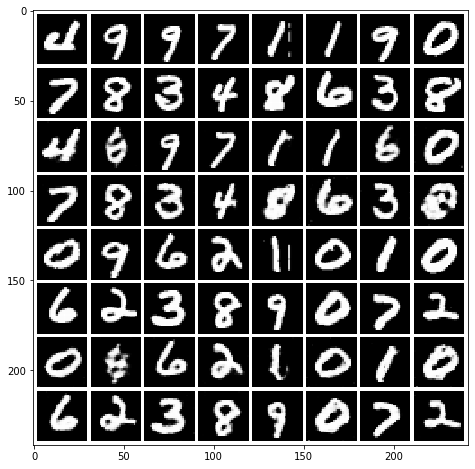

Mean squared dist: 0.024188783
epoch: 81 	 step:0 	 loss: 6.426
epoch: 81 	 step:100 	 loss: 8.266
epoch: 81 	 step:200 	 loss: 7.25
epoch: 81 	 step:300 	 loss: 4.892
epoch: 81 	 step:400 	 loss: 6.302
epoch: 81 	 step:500 	 loss: 6.094
epoch: 81 	 step:600 	 loss: 6.144
epoch: 81 	 step:700 	 loss: 4.138
epoch: 81 	 step:800 	 loss: 5.841
epoch: 81 	 step:900 	 loss: 6.26
epoch: 81 	 step:1000 	 loss: 4.8
epoch: 81 	 step:1100 	 loss: 5.533
epoch: 81 	 step:1200 	 loss: 6.067
epoch: 81 	 step:1300 	 loss: 5.162
epoch: 81 	 step:1400 	 loss: 5.888
epoch: 81 	 step:1500 	 loss: 4.986
epoch: 81 	 step:1600 	 loss: 5.147
epoch: 81 	 step:1700 	 loss: 4.924
epoch: 81 	 step:1800 	 loss: 4.985


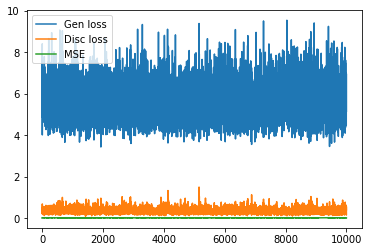

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


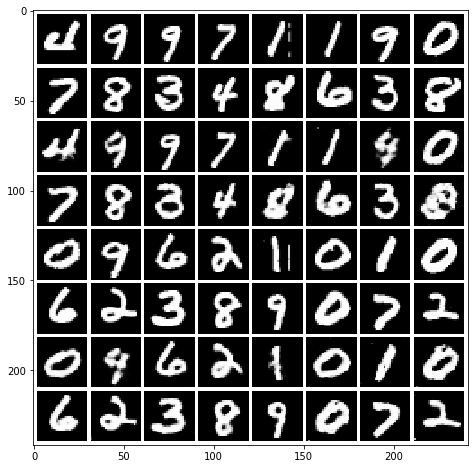

Mean squared dist: 0.024180658
epoch: 82 	 step:0 	 loss: 5.042
epoch: 82 	 step:100 	 loss: 6.125
epoch: 82 	 step:200 	 loss: 6.896
epoch: 82 	 step:300 	 loss: 4.659
epoch: 82 	 step:400 	 loss: 5.34
epoch: 82 	 step:500 	 loss: 6.214
epoch: 82 	 step:600 	 loss: 5.212
epoch: 82 	 step:700 	 loss: 4.964
epoch: 82 	 step:800 	 loss: 5.024
epoch: 82 	 step:900 	 loss: 5.466
epoch: 82 	 step:1000 	 loss: 5.588
epoch: 82 	 step:1100 	 loss: 5.507
epoch: 82 	 step:1200 	 loss: 5.639
epoch: 82 	 step:1300 	 loss: 5.855
epoch: 82 	 step:1400 	 loss: 4.641
epoch: 82 	 step:1500 	 loss: 5.378
epoch: 82 	 step:1600 	 loss: 5.525
epoch: 82 	 step:1700 	 loss: 5.577
epoch: 82 	 step:1800 	 loss: 5.679


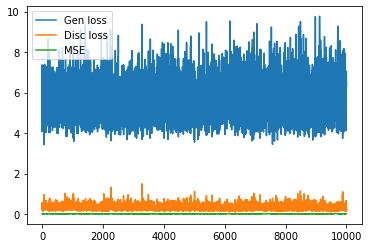

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


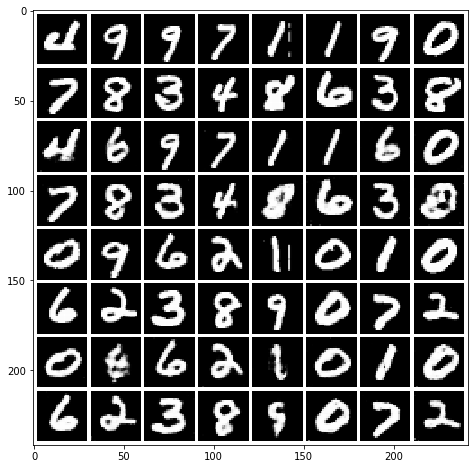

Mean squared dist: 0.024178263
epoch: 83 	 step:0 	 loss: 4.188
epoch: 83 	 step:100 	 loss: 4.11
epoch: 83 	 step:200 	 loss: 5.607
epoch: 83 	 step:300 	 loss: 5.88
epoch: 83 	 step:400 	 loss: 6.194
epoch: 83 	 step:500 	 loss: 5.342
epoch: 83 	 step:600 	 loss: 6.525
epoch: 83 	 step:700 	 loss: 5.678
epoch: 83 	 step:800 	 loss: 4.799
epoch: 83 	 step:900 	 loss: 6.742
epoch: 83 	 step:1000 	 loss: 8.01
epoch: 83 	 step:1100 	 loss: 6.286
epoch: 83 	 step:1200 	 loss: 4.526
epoch: 83 	 step:1300 	 loss: 5.87
epoch: 83 	 step:1400 	 loss: 5.004
epoch: 83 	 step:1500 	 loss: 4.972
epoch: 83 	 step:1600 	 loss: 5.102
epoch: 83 	 step:1700 	 loss: 6.532
epoch: 83 	 step:1800 	 loss: 5.536


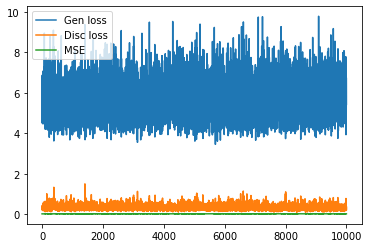

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


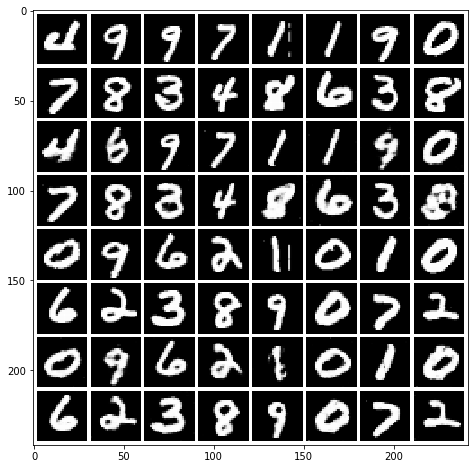

Mean squared dist: 0.02365516
epoch: 84 	 step:0 	 loss: 5.171
epoch: 84 	 step:100 	 loss: 4.931
epoch: 84 	 step:200 	 loss: 5.523
epoch: 84 	 step:300 	 loss: 5.644
epoch: 84 	 step:400 	 loss: 5.719
epoch: 84 	 step:500 	 loss: 6.052
epoch: 84 	 step:600 	 loss: 5.447
epoch: 84 	 step:700 	 loss: 6.859
epoch: 84 	 step:800 	 loss: 6.196
epoch: 84 	 step:900 	 loss: 4.355
epoch: 84 	 step:1000 	 loss: 4.33
epoch: 84 	 step:1100 	 loss: 5.368
epoch: 84 	 step:1200 	 loss: 6.41
epoch: 84 	 step:1300 	 loss: 4.858
epoch: 84 	 step:1400 	 loss: 5.65
epoch: 84 	 step:1500 	 loss: 6.523
epoch: 84 	 step:1600 	 loss: 5.251
epoch: 84 	 step:1700 	 loss: 4.877
epoch: 84 	 step:1800 	 loss: 4.188


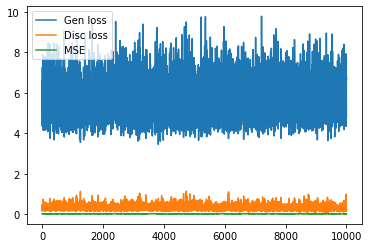

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


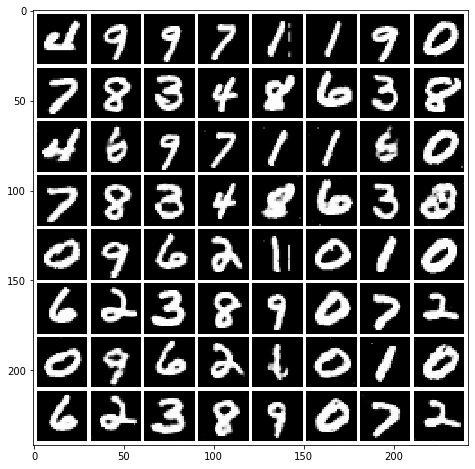

Mean squared dist: 0.024399102
epoch: 85 	 step:0 	 loss: 4.344
epoch: 85 	 step:100 	 loss: 8.476
epoch: 85 	 step:200 	 loss: 6.209
epoch: 85 	 step:300 	 loss: 5.645
epoch: 85 	 step:400 	 loss: 5.322
epoch: 85 	 step:500 	 loss: 5.458
epoch: 85 	 step:600 	 loss: 6.391
epoch: 85 	 step:700 	 loss: 8.789
epoch: 85 	 step:800 	 loss: 5.028
epoch: 85 	 step:900 	 loss: 5.83
epoch: 85 	 step:1000 	 loss: 6.426
epoch: 85 	 step:1100 	 loss: 5.129
epoch: 85 	 step:1200 	 loss: 5.564
epoch: 85 	 step:1300 	 loss: 4.64
epoch: 85 	 step:1400 	 loss: 6.271
epoch: 85 	 step:1500 	 loss: 5.456
epoch: 85 	 step:1600 	 loss: 6.243
epoch: 85 	 step:1700 	 loss: 4.625
epoch: 85 	 step:1800 	 loss: 5.88


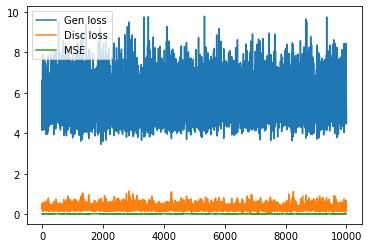

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


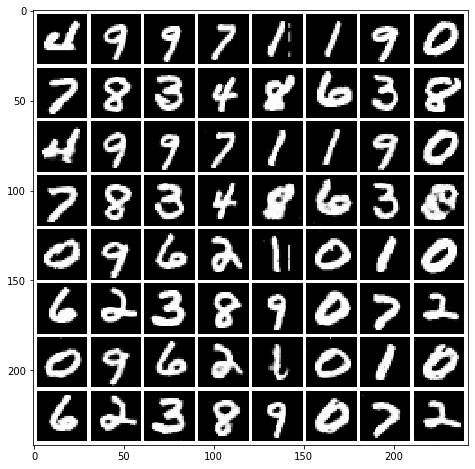

Mean squared dist: 0.0238396
epoch: 86 	 step:0 	 loss: 5.335
epoch: 86 	 step:100 	 loss: 5.167
epoch: 86 	 step:200 	 loss: 6.51
epoch: 86 	 step:300 	 loss: 5.135
epoch: 86 	 step:400 	 loss: 7.381
epoch: 86 	 step:500 	 loss: 6.848
epoch: 86 	 step:600 	 loss: 5.563
epoch: 86 	 step:700 	 loss: 6.669
epoch: 86 	 step:800 	 loss: 5.641
epoch: 86 	 step:900 	 loss: 7.146
epoch: 86 	 step:1000 	 loss: 5.245
epoch: 86 	 step:1100 	 loss: 5.582
epoch: 86 	 step:1200 	 loss: 5.821
epoch: 86 	 step:1300 	 loss: 8.244
epoch: 86 	 step:1400 	 loss: 6.958
epoch: 86 	 step:1500 	 loss: 6.62
epoch: 86 	 step:1600 	 loss: 5.344
epoch: 86 	 step:1700 	 loss: 5.157
epoch: 86 	 step:1800 	 loss: 6.744


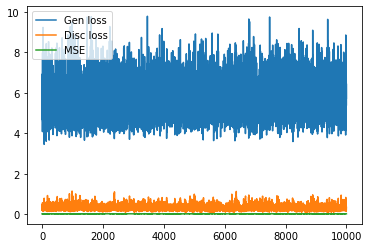

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


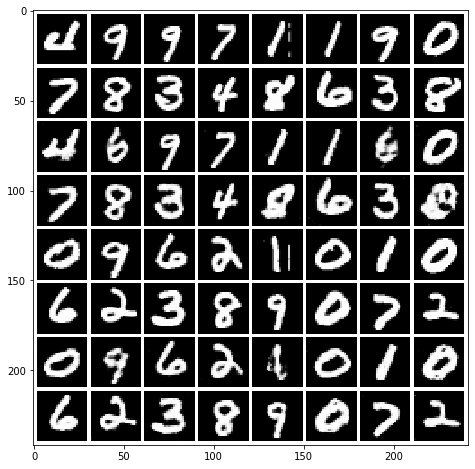

Mean squared dist: 0.023683427
epoch: 87 	 step:0 	 loss: 5.292
epoch: 87 	 step:100 	 loss: 5.419
epoch: 87 	 step:200 	 loss: 5.243
epoch: 87 	 step:300 	 loss: 5.428
epoch: 87 	 step:400 	 loss: 6.73
epoch: 87 	 step:500 	 loss: 5.281
epoch: 87 	 step:600 	 loss: 6.232
epoch: 87 	 step:700 	 loss: 6.525
epoch: 87 	 step:800 	 loss: 4.397
epoch: 87 	 step:900 	 loss: 5.139
epoch: 87 	 step:1000 	 loss: 5.626
epoch: 87 	 step:1100 	 loss: 6.96
epoch: 87 	 step:1200 	 loss: 5.487
epoch: 87 	 step:1300 	 loss: 6.184
epoch: 87 	 step:1400 	 loss: 5.623
epoch: 87 	 step:1500 	 loss: 5.945
epoch: 87 	 step:1600 	 loss: 6.855
epoch: 87 	 step:1700 	 loss: 6.791
epoch: 87 	 step:1800 	 loss: 5.022


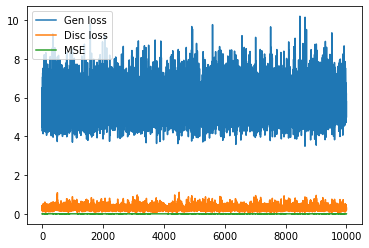

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


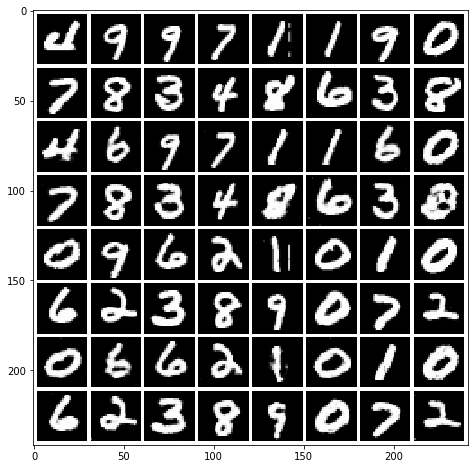

Mean squared dist: 0.024141679
epoch: 88 	 step:0 	 loss: 6.491
epoch: 88 	 step:100 	 loss: 5.258
epoch: 88 	 step:200 	 loss: 6.787
epoch: 88 	 step:300 	 loss: 4.915
epoch: 88 	 step:400 	 loss: 6.925
epoch: 88 	 step:500 	 loss: 6.007
epoch: 88 	 step:600 	 loss: 5.315
epoch: 88 	 step:700 	 loss: 5.546
epoch: 88 	 step:800 	 loss: 6.465
epoch: 88 	 step:900 	 loss: 6.664
epoch: 88 	 step:1000 	 loss: 4.586
epoch: 88 	 step:1100 	 loss: 5.526
epoch: 88 	 step:1200 	 loss: 6.405
epoch: 88 	 step:1300 	 loss: 5.645
epoch: 88 	 step:1400 	 loss: 6.673
epoch: 88 	 step:1500 	 loss: 5.823
epoch: 88 	 step:1600 	 loss: 5.999
epoch: 88 	 step:1700 	 loss: 5.852
epoch: 88 	 step:1800 	 loss: 4.964


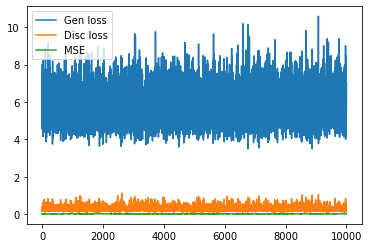

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


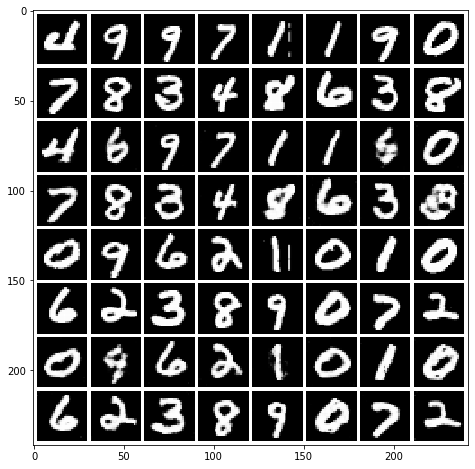

Mean squared dist: 0.023853866
epoch: 89 	 step:0 	 loss: 4.824
epoch: 89 	 step:100 	 loss: 6.068
epoch: 89 	 step:200 	 loss: 5.503
epoch: 89 	 step:300 	 loss: 6.722
epoch: 89 	 step:400 	 loss: 4.6
epoch: 89 	 step:500 	 loss: 5.737
epoch: 89 	 step:600 	 loss: 5.252
epoch: 89 	 step:700 	 loss: 6.052
epoch: 89 	 step:800 	 loss: 6.248
epoch: 89 	 step:900 	 loss: 5.462
epoch: 89 	 step:1000 	 loss: 6.068
epoch: 89 	 step:1100 	 loss: 8.026
epoch: 89 	 step:1200 	 loss: 6.242
epoch: 89 	 step:1300 	 loss: 7.478
epoch: 89 	 step:1400 	 loss: 5.516
epoch: 89 	 step:1500 	 loss: 5.768
epoch: 89 	 step:1600 	 loss: 5.888
epoch: 89 	 step:1700 	 loss: 6.376
epoch: 89 	 step:1800 	 loss: 6.94


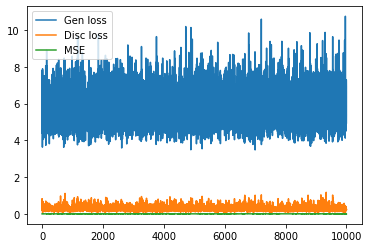

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


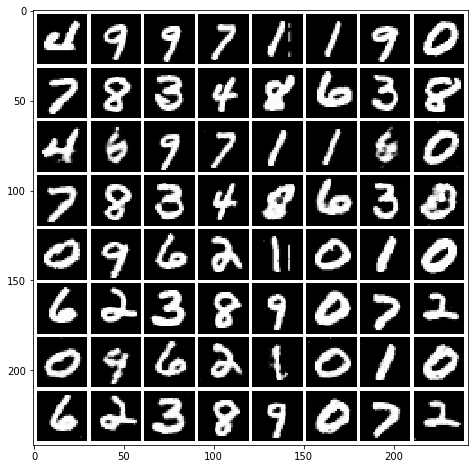

Mean squared dist: 0.023644961
epoch: 90 	 step:0 	 loss: 4.454
epoch: 90 	 step:100 	 loss: 5.75
epoch: 90 	 step:200 	 loss: 5.666
epoch: 90 	 step:300 	 loss: 4.725
epoch: 90 	 step:400 	 loss: 6.608
epoch: 90 	 step:500 	 loss: 5.825
epoch: 90 	 step:600 	 loss: 6.612
epoch: 90 	 step:700 	 loss: 6.074
epoch: 90 	 step:800 	 loss: 5.705
epoch: 90 	 step:900 	 loss: 4.037
epoch: 90 	 step:1000 	 loss: 8.214
epoch: 90 	 step:1100 	 loss: 6.224
epoch: 90 	 step:1200 	 loss: 7.315
epoch: 90 	 step:1300 	 loss: 5.842
epoch: 90 	 step:1400 	 loss: 5.506
epoch: 90 	 step:1500 	 loss: 6.984
epoch: 90 	 step:1600 	 loss: 6.377
epoch: 90 	 step:1700 	 loss: 7.603
epoch: 90 	 step:1800 	 loss: 6.385


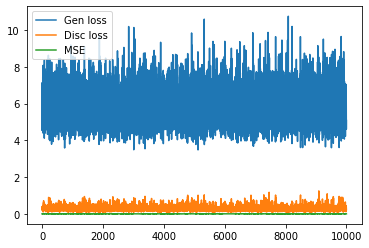

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


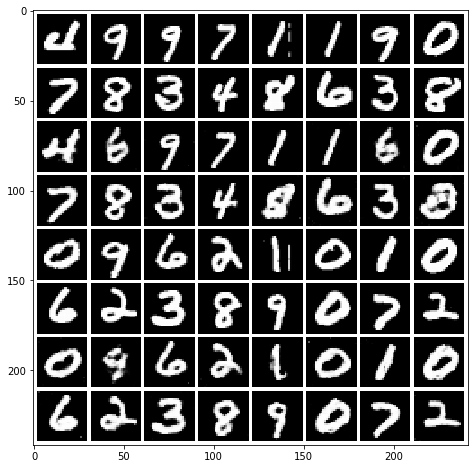

Mean squared dist: 0.023756715
epoch: 91 	 step:0 	 loss: 5.705
epoch: 91 	 step:100 	 loss: 5.12
epoch: 91 	 step:200 	 loss: 5.987
epoch: 91 	 step:300 	 loss: 6.628
epoch: 91 	 step:400 	 loss: 5.865
epoch: 91 	 step:500 	 loss: 6.523
epoch: 91 	 step:600 	 loss: 4.753
epoch: 91 	 step:700 	 loss: 4.825
epoch: 91 	 step:800 	 loss: 7.119
epoch: 91 	 step:900 	 loss: 6.622
epoch: 91 	 step:1000 	 loss: 6.693
epoch: 91 	 step:1100 	 loss: 3.988
epoch: 91 	 step:1200 	 loss: 5.261
epoch: 91 	 step:1300 	 loss: 5.107
epoch: 91 	 step:1400 	 loss: 6.097
epoch: 91 	 step:1500 	 loss: 7.816
epoch: 91 	 step:1600 	 loss: 5.449
epoch: 91 	 step:1700 	 loss: 5.702
epoch: 91 	 step:1800 	 loss: 6.834


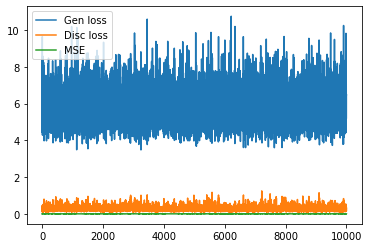

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


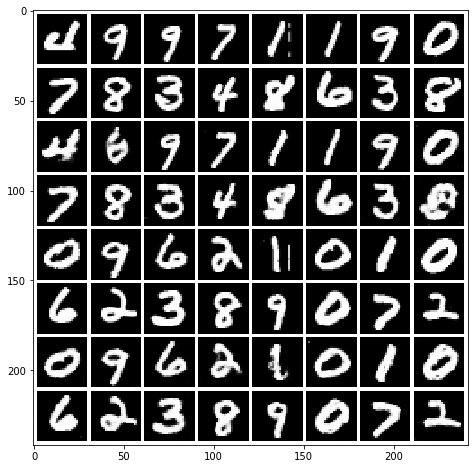

Mean squared dist: 0.023945663
epoch: 92 	 step:0 	 loss: 5.943
epoch: 92 	 step:100 	 loss: 6.528
epoch: 92 	 step:200 	 loss: 7.854
epoch: 92 	 step:300 	 loss: 5.771
epoch: 92 	 step:400 	 loss: 7.346
epoch: 92 	 step:500 	 loss: 4.781
epoch: 92 	 step:600 	 loss: 5.478
epoch: 92 	 step:700 	 loss: 4.771
epoch: 92 	 step:800 	 loss: 6.882
epoch: 92 	 step:900 	 loss: 6.053
epoch: 92 	 step:1000 	 loss: 5.473
epoch: 92 	 step:1100 	 loss: 5.664
epoch: 92 	 step:1200 	 loss: 5.035
epoch: 92 	 step:1300 	 loss: 5.367
epoch: 92 	 step:1400 	 loss: 6.556
epoch: 92 	 step:1500 	 loss: 6.582
epoch: 92 	 step:1600 	 loss: 5.544
epoch: 92 	 step:1700 	 loss: 5.582
epoch: 92 	 step:1800 	 loss: 4.796


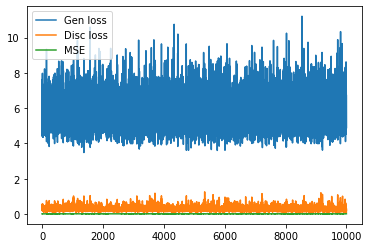

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


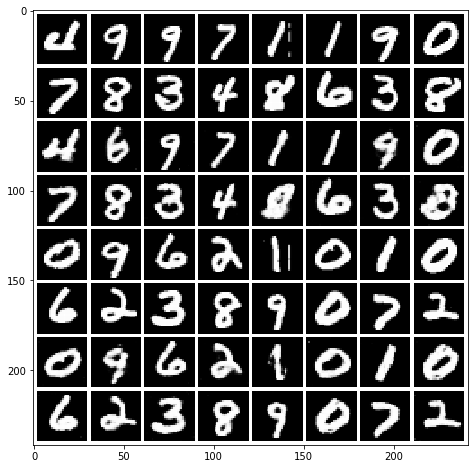

Mean squared dist: 0.023575213
epoch: 93 	 step:0 	 loss: 4.274
epoch: 93 	 step:100 	 loss: 5.964
epoch: 93 	 step:200 	 loss: 5.742
epoch: 93 	 step:300 	 loss: 5.767
epoch: 93 	 step:400 	 loss: 5.793
epoch: 93 	 step:500 	 loss: 5.283
epoch: 93 	 step:600 	 loss: 6.788
epoch: 93 	 step:700 	 loss: 5.587
epoch: 93 	 step:800 	 loss: 5.752
epoch: 93 	 step:900 	 loss: 8.142
epoch: 93 	 step:1000 	 loss: 7.863
epoch: 93 	 step:1100 	 loss: 7.148
epoch: 93 	 step:1200 	 loss: 4.759
epoch: 93 	 step:1300 	 loss: 8.447
epoch: 93 	 step:1400 	 loss: 4.961
epoch: 93 	 step:1500 	 loss: 6.423
epoch: 93 	 step:1600 	 loss: 7.354
epoch: 93 	 step:1700 	 loss: 7.326
epoch: 93 	 step:1800 	 loss: 5.959


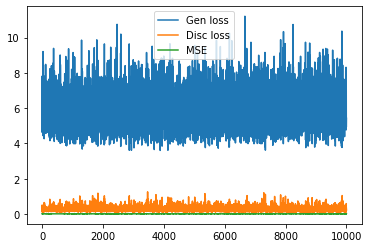

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


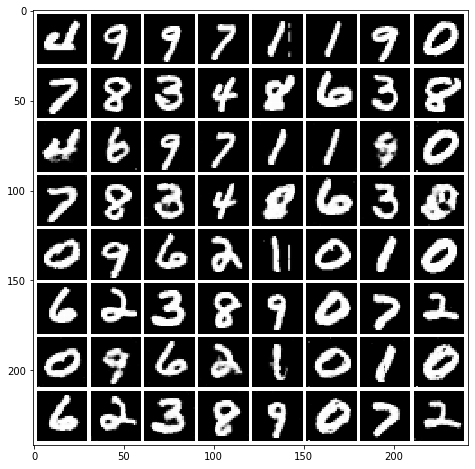

Mean squared dist: 0.02397968
epoch: 94 	 step:0 	 loss: 6.484
epoch: 94 	 step:100 	 loss: 8.261
epoch: 94 	 step:200 	 loss: 5.264
epoch: 94 	 step:300 	 loss: 4.044
epoch: 94 	 step:400 	 loss: 6.767
epoch: 94 	 step:500 	 loss: 5.534
epoch: 94 	 step:600 	 loss: 5.942
epoch: 94 	 step:700 	 loss: 5.709
epoch: 94 	 step:800 	 loss: 6.405
epoch: 94 	 step:900 	 loss: 5.575
epoch: 94 	 step:1000 	 loss: 6.438
epoch: 94 	 step:1100 	 loss: 7.357
epoch: 94 	 step:1200 	 loss: 7.472
epoch: 94 	 step:1300 	 loss: 5.682
epoch: 94 	 step:1400 	 loss: 7.314
epoch: 94 	 step:1500 	 loss: 4.997
epoch: 94 	 step:1600 	 loss: 5.312
epoch: 94 	 step:1700 	 loss: 6.934
epoch: 94 	 step:1800 	 loss: 4.732


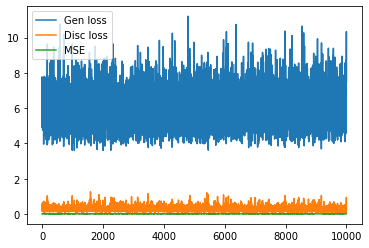

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


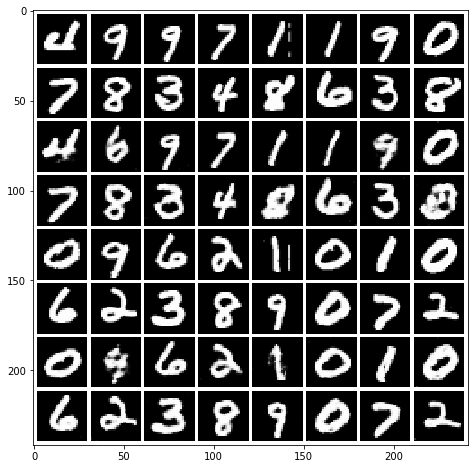

Mean squared dist: 0.023761114
epoch: 95 	 step:0 	 loss: 6.478
epoch: 95 	 step:100 	 loss: 5.338
epoch: 95 	 step:200 	 loss: 5.245
epoch: 95 	 step:300 	 loss: 4.636
epoch: 95 	 step:400 	 loss: 6.533
epoch: 95 	 step:500 	 loss: 6.205
epoch: 95 	 step:600 	 loss: 6.381
epoch: 95 	 step:700 	 loss: 5.897
epoch: 95 	 step:800 	 loss: 5.883
epoch: 95 	 step:900 	 loss: 7.314
epoch: 95 	 step:1000 	 loss: 7.086
epoch: 95 	 step:1100 	 loss: 6.888
epoch: 95 	 step:1200 	 loss: 5.538
epoch: 95 	 step:1300 	 loss: 8.787
epoch: 95 	 step:1400 	 loss: 4.759
epoch: 95 	 step:1500 	 loss: 5.511
epoch: 95 	 step:1600 	 loss: 4.432
epoch: 95 	 step:1700 	 loss: 4.046
epoch: 95 	 step:1800 	 loss: 6.149


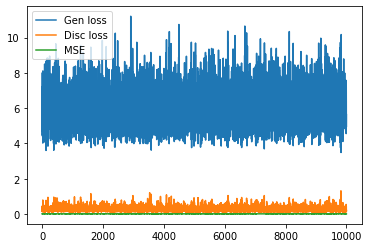

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


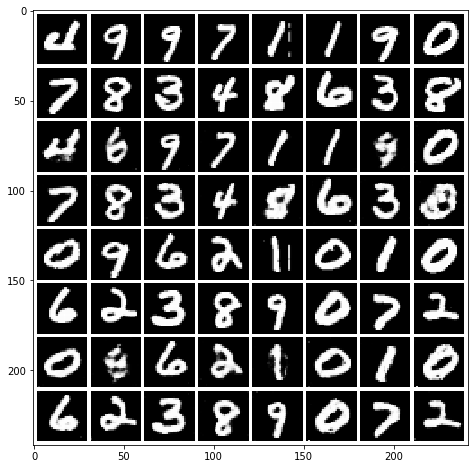

Mean squared dist: 0.0236756
epoch: 96 	 step:0 	 loss: 5.59
epoch: 96 	 step:100 	 loss: 5.267
epoch: 96 	 step:200 	 loss: 7.305
epoch: 96 	 step:300 	 loss: 6.361
epoch: 96 	 step:400 	 loss: 6.031
epoch: 96 	 step:500 	 loss: 6.871
epoch: 96 	 step:600 	 loss: 5.176
epoch: 96 	 step:700 	 loss: 5.656
epoch: 96 	 step:800 	 loss: 7.352
epoch: 96 	 step:900 	 loss: 4.556
epoch: 96 	 step:1000 	 loss: 6.628
epoch: 96 	 step:1100 	 loss: 5.157
epoch: 96 	 step:1200 	 loss: 6.297
epoch: 96 	 step:1300 	 loss: 7.289
epoch: 96 	 step:1400 	 loss: 6.714
epoch: 96 	 step:1500 	 loss: 6.872
epoch: 96 	 step:1600 	 loss: 5.812
epoch: 96 	 step:1700 	 loss: 8.359
epoch: 96 	 step:1800 	 loss: 4.881


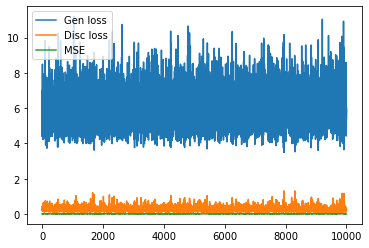

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


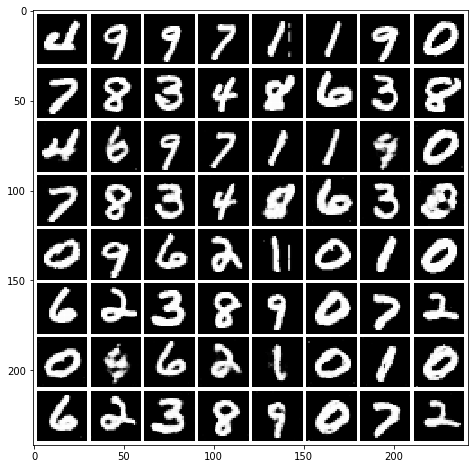

Mean squared dist: 0.02353688
epoch: 97 	 step:0 	 loss: 7.534
epoch: 97 	 step:100 	 loss: 6.561
epoch: 97 	 step:200 	 loss: 5.62
epoch: 97 	 step:300 	 loss: 6.879
epoch: 97 	 step:400 	 loss: 7.836
epoch: 97 	 step:500 	 loss: 7.909
epoch: 97 	 step:600 	 loss: 6.173
epoch: 97 	 step:700 	 loss: 6.115
epoch: 97 	 step:800 	 loss: 4.288
epoch: 97 	 step:900 	 loss: 4.663
epoch: 97 	 step:1000 	 loss: 4.873
epoch: 97 	 step:1100 	 loss: 6.449
epoch: 97 	 step:1200 	 loss: 5.061
epoch: 97 	 step:1300 	 loss: 7.663
epoch: 97 	 step:1400 	 loss: 7.224
epoch: 97 	 step:1500 	 loss: 7.24
epoch: 97 	 step:1600 	 loss: 4.509
epoch: 97 	 step:1700 	 loss: 5.917
epoch: 97 	 step:1800 	 loss: 6.386


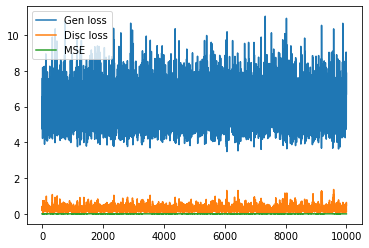

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


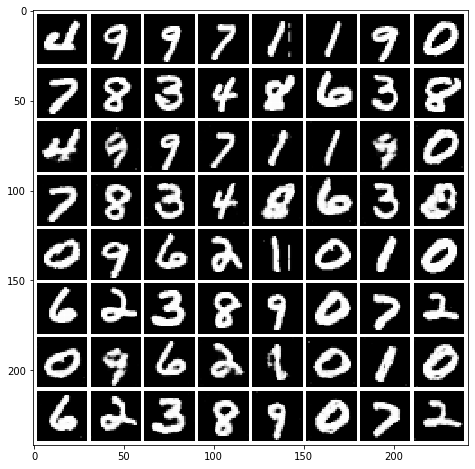

Mean squared dist: 0.024107553
epoch: 98 	 step:0 	 loss: 7.297
epoch: 98 	 step:100 	 loss: 5.508
epoch: 98 	 step:200 	 loss: 5.644
epoch: 98 	 step:300 	 loss: 5.479
epoch: 98 	 step:400 	 loss: 6.56
epoch: 98 	 step:500 	 loss: 6.32
epoch: 98 	 step:600 	 loss: 5.434
epoch: 98 	 step:700 	 loss: 5.242
epoch: 98 	 step:800 	 loss: 6.398
epoch: 98 	 step:900 	 loss: 6.347
epoch: 98 	 step:1000 	 loss: 4.5
epoch: 98 	 step:1100 	 loss: 5.734
epoch: 98 	 step:1200 	 loss: 5.237
epoch: 98 	 step:1300 	 loss: 5.167
epoch: 98 	 step:1400 	 loss: 8.182
epoch: 98 	 step:1500 	 loss: 4.038
epoch: 98 	 step:1600 	 loss: 7.015
epoch: 98 	 step:1700 	 loss: 5.276
epoch: 98 	 step:1800 	 loss: 5.271


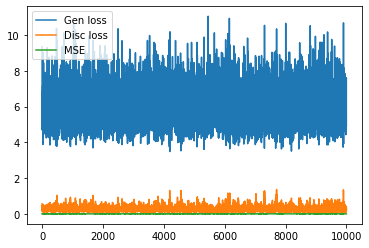

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


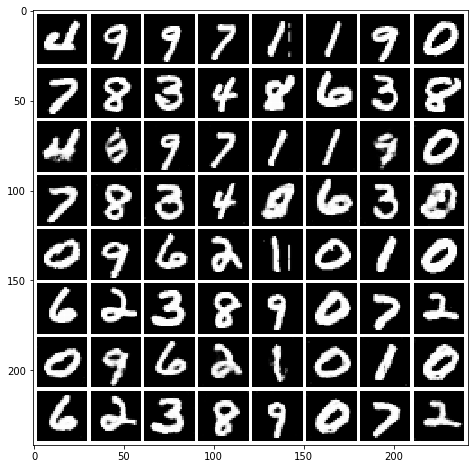

Mean squared dist: 0.0236321
epoch: 99 	 step:0 	 loss: 4.679
epoch: 99 	 step:100 	 loss: 6.586
epoch: 99 	 step:200 	 loss: 4.856
epoch: 99 	 step:300 	 loss: 5.358
epoch: 99 	 step:400 	 loss: 6.762
epoch: 99 	 step:500 	 loss: 5.817
epoch: 99 	 step:600 	 loss: 4.888
epoch: 99 	 step:700 	 loss: 5.929
epoch: 99 	 step:800 	 loss: 4.84
epoch: 99 	 step:900 	 loss: 7.214
epoch: 99 	 step:1000 	 loss: 7.498
epoch: 99 	 step:1100 	 loss: 5.447
epoch: 99 	 step:1200 	 loss: 5.863
epoch: 99 	 step:1300 	 loss: 5.049
epoch: 99 	 step:1400 	 loss: 7.306
epoch: 99 	 step:1500 	 loss: 4.387
epoch: 99 	 step:1600 	 loss: 7.901
epoch: 99 	 step:1700 	 loss: 6.829
epoch: 99 	 step:1800 	 loss: 6.178


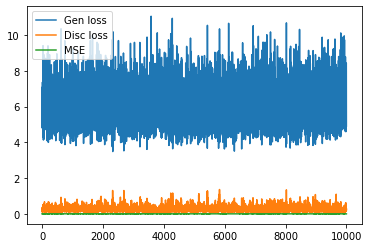

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


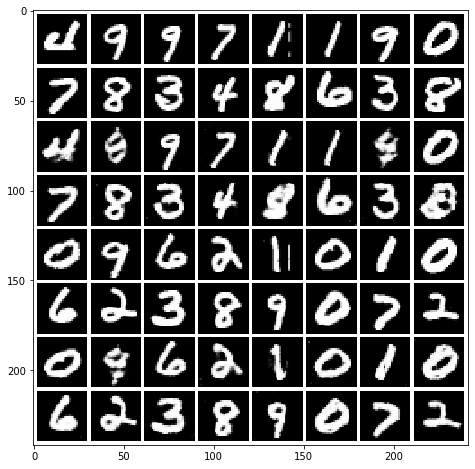

Mean squared dist: 0.024019225
epoch: 100 	 step:0 	 loss: 4.164
epoch: 100 	 step:100 	 loss: 7.272
epoch: 100 	 step:200 	 loss: 5.338
epoch: 100 	 step:300 	 loss: 5.634
epoch: 100 	 step:400 	 loss: 5.559
epoch: 100 	 step:500 	 loss: 6.041
epoch: 100 	 step:600 	 loss: 6.164
epoch: 100 	 step:700 	 loss: 6.053
epoch: 100 	 step:800 	 loss: 5.994
epoch: 100 	 step:900 	 loss: 5.445
epoch: 100 	 step:1000 	 loss: 6.295
epoch: 100 	 step:1100 	 loss: 5.955
epoch: 100 	 step:1200 	 loss: 5.644
epoch: 100 	 step:1300 	 loss: 6.343
epoch: 100 	 step:1400 	 loss: 6.895
epoch: 100 	 step:1500 	 loss: 5.52
epoch: 100 	 step:1600 	 loss: 6.515
epoch: 100 	 step:1700 	 loss: 5.752
epoch: 100 	 step:1800 	 loss: 5.655


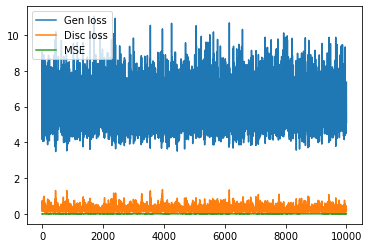

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


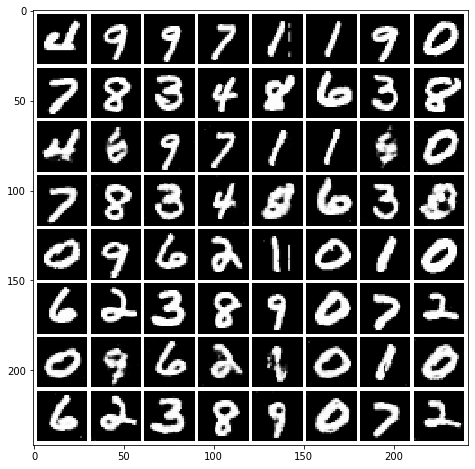

Mean squared dist: 0.023792174


In [114]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/FCGenerator2048MNIST_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/ConvDiscriminator64MNIST_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [34]:
### LOAD MODEL ####

model_nr = 8

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_nr), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/cGAN/ConvDiscriminator64MNIST_{}.sd".format(model_nr), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [35]:
# Calculate test predictions #

test_predicted, test_original = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


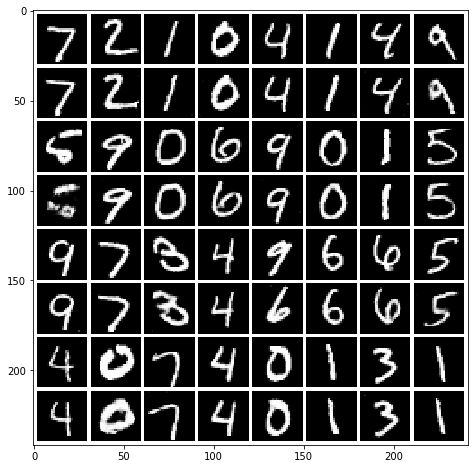

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


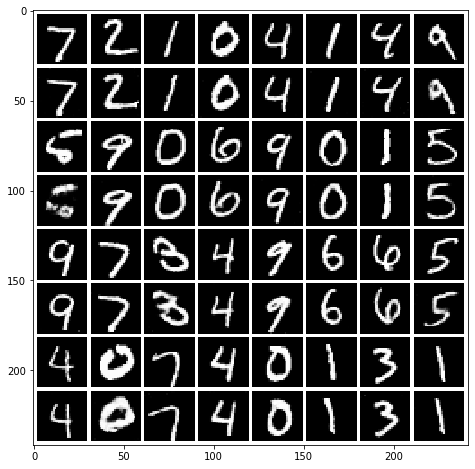

In [36]:
# Print test predictions 2 #
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}.png".format(model_nr))

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}_reg.png".format(model_nr))

In [37]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.025981584240980737, std: 0.019475880623920968
  MAE: 0.05072387514337606, std: 0.02566946743033566
  SSIM: 0.7880634322396365, std: 0.13513304380788213
  PhCo-MSE: 0.02173478933309525, std: 0.015707624373845146
  PhCo-MAE: 0.0454442903310337, std: 0.021043226243189068
  PhCo-SSIM: 0.8143290645686727, std: 0.1097529281355567
  CroCo-MSE: 0.018594421935858918, std: 0.010482823355338382
  CroCo-MAE: 0.04167613401023118, std: 0.016687104175923968
  CroCo-SSIM: 0.8354831964219742, std: 0.08449413146471373

Magnitude error:
  MSE Magnitude: 4.058178910591094, std: 2.6334708733215235

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02598 | 0.05072 | 0.7881 | 0.02173 | 0.04544 | 0.8143 | 0.01859 | 0.04168 | 0.8355 | 4.058 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | clipping | Loss | Size | epochs | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | FC + FC | 1e-1 | log GAN + 1e3 * MAE | 2048 | 100 | 0.02343 | 0.04836 | 0.7998 | 0.01910 | 0.04278 | 0.8280 | 0.01680 | 0.04014 | 0.8436 | 3.912 |
| 2 | FC + FC |  1e-1 | log GAN + 1e3 * MSE | 2048 | 100 | 0.02073 | 0.05373 | 0.7889 | 0.01791 | 0.04989 | 0.8112 | __0.01549__ | 0.04687 | 0.8271 | 4.722 |
| 3 | FC + FC |  1e-1 | log GAN + 1e2 * MAE | 2048 | 100 | 0.02987 | 0.06530 | 0.6992 | 0.03464 | 0.07054 | 0.6814 | 0.02476 | 0.05901 | 0.7334 | 7.281 |
| __4__ | FC + CNN |  0.0 | log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.02386 | 0.04874 | 0.7979 | 0.01935 | 0.04301 | 0.8275 | 0.01676 | __0.03992__ | __0.8449__ | 3.702 |
| 5 | FC + CNN |  1e-1 | log GAN + 1e1 * MAE | 2048 + 64 | 100 | 0.03362 | 0.05890 | 0.7438 | 0.02757 | 0.05152 | 0.7820 | 0.02327 | 0.04680 | 0.8057 | 5.164 |
| 6 | FC + CNN |  0.0 | log GAN + 1e1 * MAE | 2048 + 64 | 100 | 0.03362 | 0.05915 | 0.7418 | 0.02829 | 0.05259 | 0.7764 | 0.02351 | 0.04724 | 0.8036 | 5.203 |
| 7 | FC + CNN | 0.0 | log GAN + 1e4 * MAE | 2048 + 64 | 100 | 0.02354 | 0.04797 | 0.8004 | 0.01978 | 0.04305 | 0.8262 | 0.01723 | 0.04014 | 0.8426 | 4.010 |
| 8 | FC + CNN | 0.0 | log GAN + 1e2 * MAE | 2048 + 64 | 100 | 0.02598 | 0.05072 | 0.7881 | 0.02173 | 0.04544 | 0.8143 | 0.01859 | 0.04168 | 0.8355 | 4.058 |


In [83]:
# Latent z optimization

def genopt(sample_magnitudes, gen, disc, device, init_x=None, max_steps=5000, max_loss=0.0, mue=1.0, lr=1.0):
    
    if disc is not None:
        disc.to(device)
        disc.eval()
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
    
    for i in range(max_steps):
        magnitudes = calc_mags(last_out)

        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=(1, 2, 3))
        reconstruction = torch.sum(mse_all)
        #adversarial = -torch.mean(torch.log(disc(torch.cat([last_out, sample_magnitudes], dim=1))))
        #loss = reconstruction + mue * adversarial
        loss = reconstruction + mue * torch.mean(z ** 2)
        
        if loss < max_loss:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all

Batch 1/1 finished


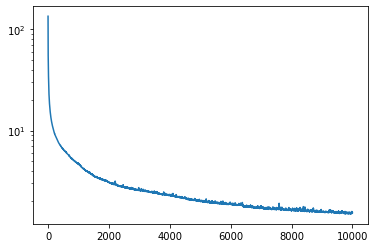

In [89]:
### Latent z optimization ###

num_batches = 1
batch_size = 32
max_steps = 10000
max_loss = 0.0
mue = 0.0
lr = 1.0

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, disc=None, device=device,
                                          max_steps=max_steps, max_loss=max_loss, mue=mue, lr=lr)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [91]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_original_2.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_2.p", "wb"))

In [65]:
### LOAD RESULTS ###
import pickle

model_nr = "4_1024"

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_original_{}.p".format(model_nr), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_{}.p".format(model_nr), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


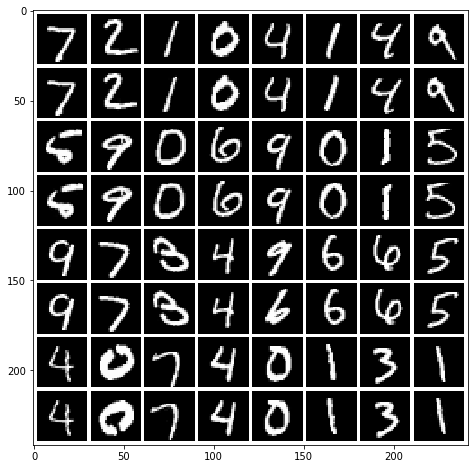

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


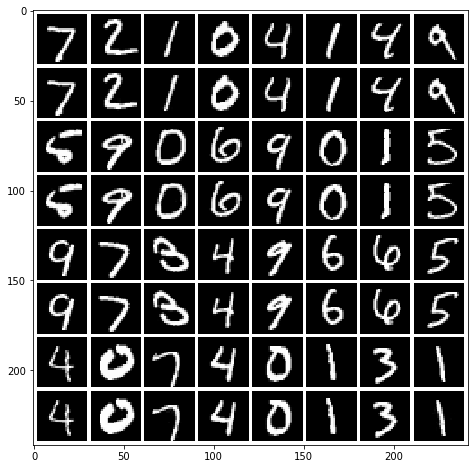

In [66]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}_10000latentSteps.png".format(model_nr))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}_10000latentSteps_reg.png".format(model_nr))

In [67]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.022252613758852867, std: 0.02951717464516534
  MAE: 0.0373209039910103, std: 0.04199432874189103
  SSIM: 0.8324401162253678, std: 0.20182488127228865
  PhCo-MSE: 0.001189640406798172, std: 0.005424334405224542
  PhCo-MAE: 0.0044927472178429555, std: 0.010564600635884769
  PhCo-SSIM: 0.9882902990364724, std: 0.05171066139448868
  CroCo-MSE: 0.0010028243025596668, std: 0.004614749003643938
  CroCo-MAE: 0.0042616945116327, std: 0.009763217347466682
  CroCo-SSIM: 0.9897873966570632, std: 0.04511847847981153

Magnitude error:
  MSE Magnitude: 0.030886159348912173, std: 0.1132629180969909

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02225 | 0.03732 | 0.8324 | 0.001190 | 0.004493 | 0.9883 | 0.001003 | 0.004262 | 0.9898 | 0.03089 |


## Evaluation for different z optimizations (32 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 0.0 | 1.0 | 0.02714 | 0.04291 | 0.8164 | 0.001689 | 0.007683 | 0.9828 | 0.001021 | 0.006489 | 0.9901 | 0.05683 |
| 2 | 10000 | 0.0 | 1.0 | 0.01275 | 0.02456 | 0.9006 | 0.001332 | 0.006999 | 0.9859 | 0.001178 | 0.006644 | 0.9879 | 0.04849 |
| 3 | 10000 | 0.0 | 1.0 | 0.02927 | 0.05433 | 0.7615 | 0.01156 | 0.03199 | 0.8788 | 0.009699 | 0.02972 | 0.8887 | 1.275 |
| 4 | 10000 | 0.0 | 1.0 | 0.02541 | 0.04258 | 0.8155 | 0.0001587 | 0.002545 | 0.9980 | 0.0001587 | 0.002545 | 0.9980 | 0.01140 |
| 5 | 10000 | 0.0 | 1.0 | 0.02861 | 0.04727 | 0.7951 | 0.002519 | 0.01058 | 0.9829 | 0.001615 | 0.009601 | 0.9855 | 0.1509 |
| 6 | 10000 | 0.0 | 1.0 | 0.02507 | 0.04185 | 0.8174 | 0.001112 | 0.008422 | 0.9875 | 0.0009450 | 0.008093 | 0.9894 | 0.1108 |
| 7 | 10000 | 0.0 | 1.0 | 0.02413 | 0.04123 | 0.8144 | 0.004162 | 0.01197 | 0.9621 | 0.002490 | 0.009644 | 0.9765 | 0.1157 |
| 8 | 10000 | 0.0 | 1.0 | 0.02613 | 0.04383 | 0.8023 | 0.001234 | 0.005298 | 0.9919 | 0.001234 | 0.005298 | 0.9919 | 0.04612 |



## Final Evaluation (1024 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 10000 | 0.0 | 1.0 | 0.02225 | 0.03732 | 0.8324 | 0.001190 | 0.004493 | 0.9883 | 0.001003 | 0.004262 | 0.9898 | 0.03089 |